In [2]:
import os
import torch
import numpy as np
import pickle
from tokenizer import Tokenizer
from generation_manager import GeneratorManager

In [55]:
from model_manager import CTRLmodel
model = CTRLmodel().to("cuda")
path_model = "/home/saitto/progen/ckpt/model_TEST.pth"
model.loadCheckpoint(path_model)

from tokenizer import Tokenizer
# Assuming Tokenizer is defined in another file, say tokenizer.py,
# you would import it like this:

# Create an instance of the Tokenizer class
tokenizer = Tokenizer()

# Example amino acid sequence
sequence_aa = "MSSKSKPKDASQRRRSLEPAE"

# Assuming you want to convert each amino acid in the sequence to its control index
# and aa_to_ctrl_idx is a dictionary loaded within the Tokenizer instance that maps
# amino acids to control indices, you would access it like this:
input_indices = [tokenizer.aa_to_ctrl_idx[aa] for aa in sequence_aa]

total_array = np.array(input_indices).reshape(1, -1)

def predict(inputs):
    with torch.no_grad():
        inputs = torch.tensor(inputs)
        if torch.cuda.is_available():
            inputs = inputs.cuda()
        output = model(inputs)
        output = output[:,:,-26:-1] # remove non-AA token logits
        return output

output = predict(total_array).squeeze()


In [2]:
tokenizer = Tokenizer()
print('tokenizer loaded')

curr_model_path = 'ckpt/training_ckpt_4/model_only_state_dict_v0Last_lr0001.pth' # model checkpoint
print('loading model from:', curr_model_path)
# Saving only state_dict:
#torch.save(model.state_dict(), model_state_dict_path)
#model_state_dict_path = load_model_path + 'model_only_state_dict_v0Last.pth'
#print('Model state dict saved')

tokenizer loaded
loading model from: ckpt/training_ckpt_4/model_only_state_dict_v0Last_lr0001.pth


In [12]:
with open('/home/saitto/progen/ProGen/my_data/test.p', 'rb') as f:
    data = pickle.load(f)
names = list(data.keys())


In [30]:
import torch

In [35]:
range_ = [x for x in range(0, 400, 50)]
range_

[0, 50, 100, 150, 200, 250, 300, 350]

In [38]:
torch.log(torch.tensor([1])).

torch.Size([1])

In [2]:
from tokenizer import Tokenizer
from model_manager import CTRLmodel
import torch
from torch.functional import F
from torch import log
import pickle
import numpy as np

In [3]:
model = CTRLmodel().to("cuda")
path_model = "/home/saitto/progen/ckpt/model_TEST.pth"
model.loadCheckpoint(path_model)
vocab_len = 129407
tokenizer = Tokenizer()
with open('/home/saitto/progen/ProGen/my_data/test.p', 'rb') as f:
    data = pickle.load(f)
names = list(data.keys())
keywords = [data[name]["kw"] for name in names]
begAAindex = [len(keywords[n]) for n in range(len(keywords))]
sequences = [data[name]["seq"] for name in names]
inputs = []
for n in range (len(sequences)):
    keywords[n] = [int(kw) for kw in keywords[n]]
    inputs.append(keywords[n] + [tokenizer.aa_to_ctrl_idx[aa] for aa in sequences[n]])
padIndex = [len(input) for input in inputs]
maximum = max([len(i) for i in inputs])
input_tensor = torch.zeros(len(inputs), maximum, dtype=torch.long)
for n, input in enumerate(inputs):
    input_tensor[n, :len(input)] = torch.tensor(input, dtype=torch.long)
input_tensor = input_tensor.cuda()
batch_size = 64  # Adjust based on your GPU memory
n_batches = (input_tensor.shape[0] + batch_size - 1) // batch_size  # Compute the number of batches needed

MODEL SIZE: 
1280
Found PyTorch checkpoint at  /home/saitto/progen/ckpt/model_TEST.pth


In [22]:
#input_tensor[0]
for i in range(1000):
    print('last keyword',input_tensor[i, begAAindex[i]-1])
    print('first aa',input_tensor[i, begAAindex[i]])
    print('beg aa',begAAindex[i])
    print('last aa',input_tensor[i, padIndex[i]-1])
    print('first pad',input_tensor[i, padIndex[i]])
    print('pad ind',padIndex[i])


last keyword tensor(2, device='cuda:0')
first aa tensor(129392, device='cuda:0')
beg aa 2
last aa tensor(129381, device='cuda:0')
first pad tensor(0, device='cuda:0')
pad ind 297
last keyword tensor(2, device='cuda:0')
first aa tensor(129392, device='cuda:0')
beg aa 2
last aa tensor(129399, device='cuda:0')
first pad tensor(0, device='cuda:0')
pad ind 301
last keyword tensor(2, device='cuda:0')
first aa tensor(129392, device='cuda:0')
beg aa 2
last aa tensor(129395, device='cuda:0')
first pad tensor(0, device='cuda:0')
pad ind 292
last keyword tensor(2, device='cuda:0')
first aa tensor(129392, device='cuda:0')
beg aa 2
last aa tensor(129397, device='cuda:0')
first pad tensor(0, device='cuda:0')
pad ind 292
last keyword tensor(1, device='cuda:0')
first aa tensor(129392, device='cuda:0')
beg aa 2
last aa tensor(129387, device='cuda:0')
first pad tensor(0, device='cuda:0')
pad ind 194
last keyword tensor(1, device='cuda:0')
first aa tensor(129392, device='cuda:0')
beg aa 2
last aa tensor(

IndexError: index 497 is out of bounds for dimension 1 with size 497

In [7]:
full_output = torch.zeros(len(input_tensor), maximum, 25, dtype=torch.float32).cuda()  # Initialize an empty tensor to store the predictions
model.eval()  # Set the model to evaluation mode if not already
with torch.no_grad():  # Ensure gradients aren't computed for efficiency
    for i in range(n_batches):
        if i == n_batches - 1:
            batch_end = input_tensor.shape[0]
            batch_start = i * batch_size
        else:
            batch_start, batch_end = i * batch_size, (i + 1) * batch_size
        
        batch = input_tensor[batch_start:batch_end, :]
        output = model(batch)[:,:,-26:-1]
        full_output[batch_start:batch_end, :, :] = output
#save full output
torch.save(full_output.cpu(), '/home/saitto/progen/ProGen/my_data/full_output.pt')

In [23]:
#load full output
full_output = torch.load('/home/saitto/progen/ProGen/my_data/full_output.pt').cuda()

In [67]:
hard_accs = []
ppls = []
trial = []
logits = []
for sample_i in range(full_output.shape[0]): # each sample in batch
    if begAAindex[sample_i] == 0:
        y_pred = full_output[sample_i][:-1]
        y_actual = input_tensor[sample_i][1:] - vocab_len + 26
    else: # if there is a keyword
        y_pred = full_output[sample_i][begAAindex[sample_i]-1:padIndex[sample_i]-1]
        y_actual = input_tensor[sample_i][begAAindex[sample_i]:padIndex[sample_i]]  - vocab_len + 26

    total_correct = 0
    total_ent = 0
    if sample_i < 5:
        logits.append(y_pred.cuda())
    y_pred = F.softmax(y_pred, dim=1)
    if sample_i < 5:
        trial.append(y_pred.cuda())
    if sample_i < 5:
        raise Exception('stop')
    # calculate perplexity
    for ii in range(0,y_pred.shape[0]): # each token in available tokens

        ent = torch.log(y_pred[ii][y_actual[ii]]).item()
        total_ent+=ent
        total_correct += (y_pred[ii].argmax() == y_actual[ii]).item()
        


    ppl = np.exp(-total_ent/y_pred.shape[0])
    ppls.append(ppl)

    hard_accs.append(total_correct / len(y_pred))


Exception: stop

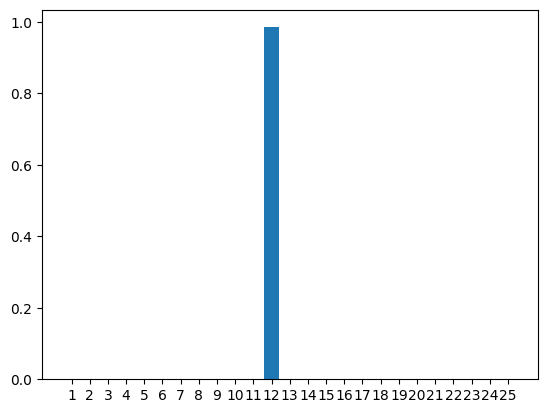

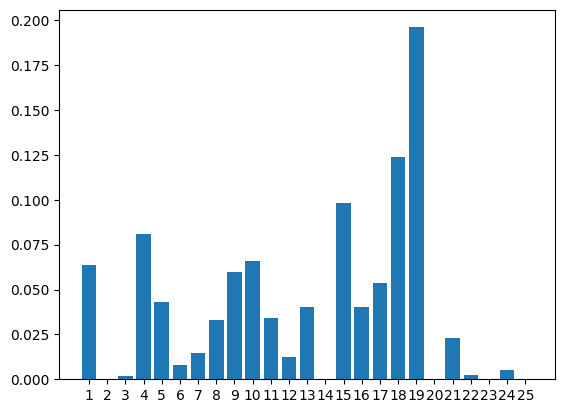

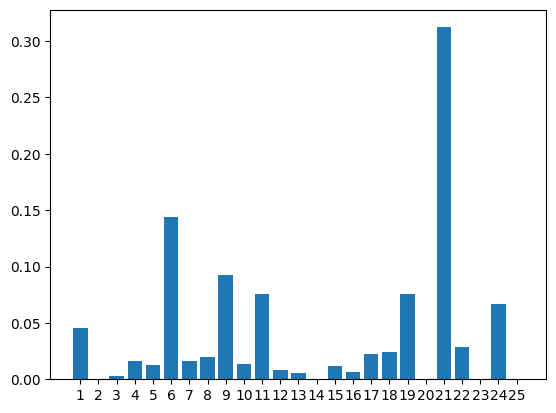

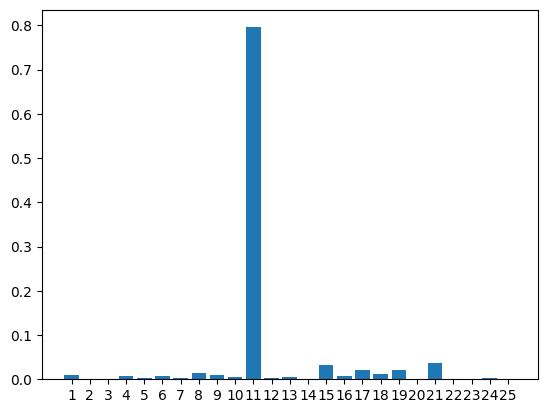

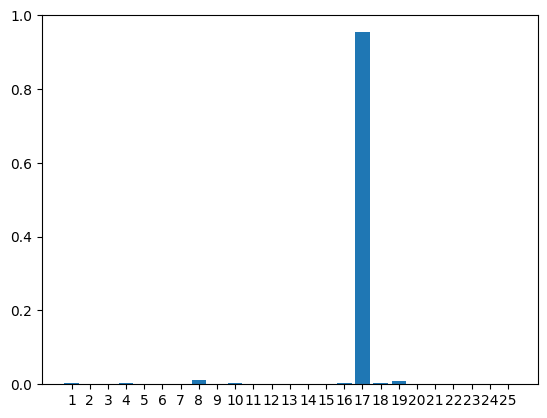

In [84]:
logits
for i in range (logits[0].shape[0]- 290):
    plt.figure(i)
    results = np.exp(logits[0][i])/np.sum(np.exp(logits[0][i]))
    values = range(1,26)
    plt.bar(values, results)
    plt.xticks(values)

/tmp/ipykernel_23290/3292196480.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(i)


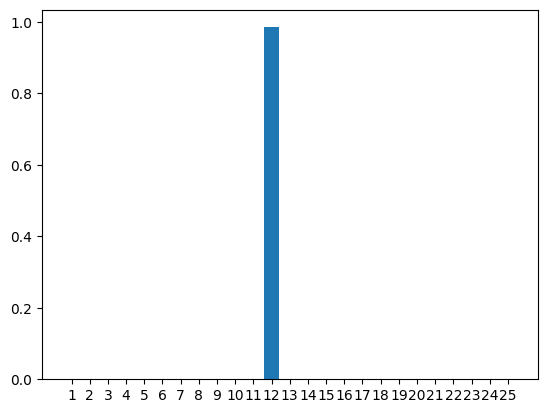

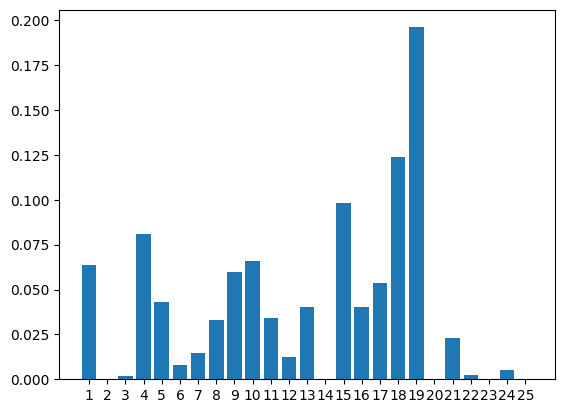

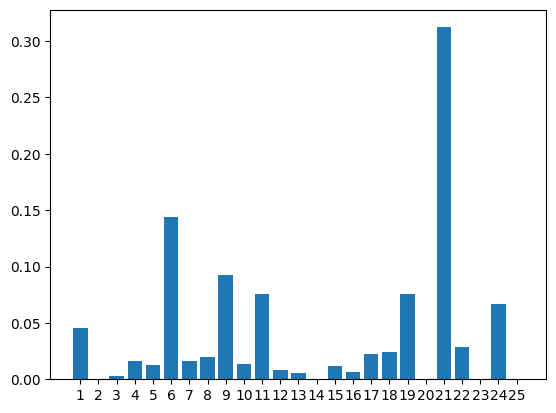

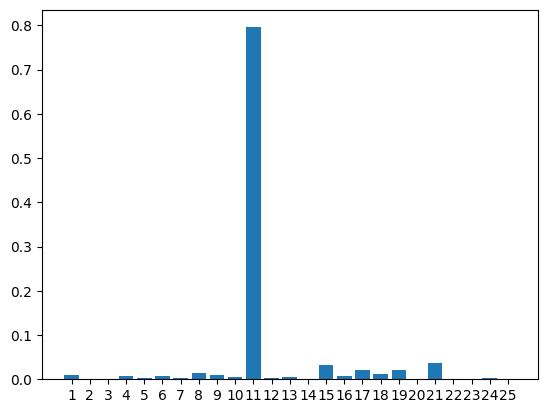

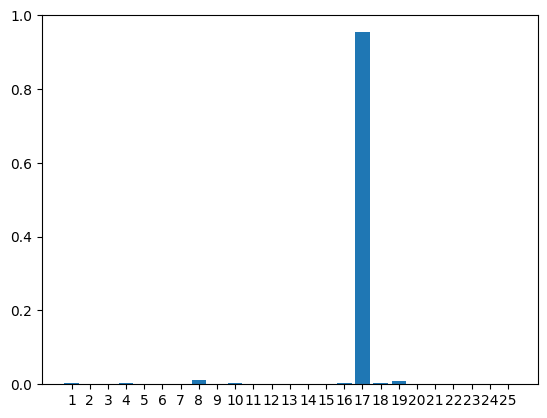

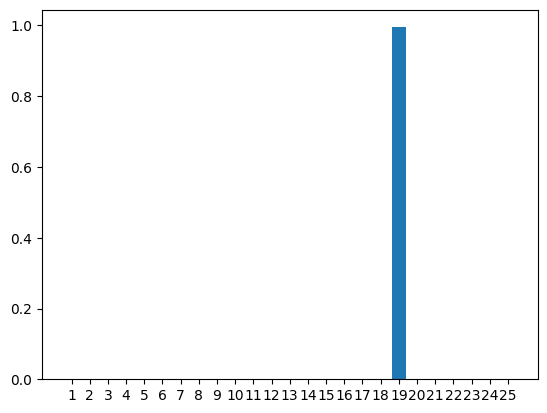

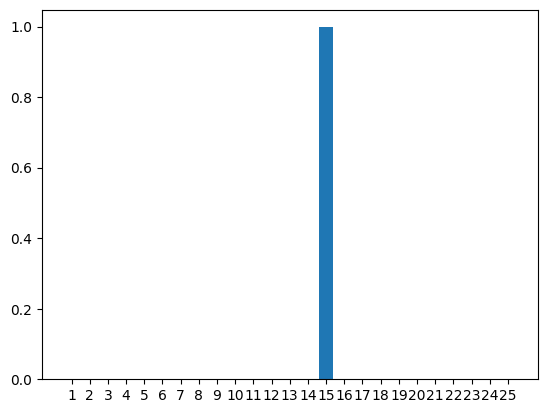

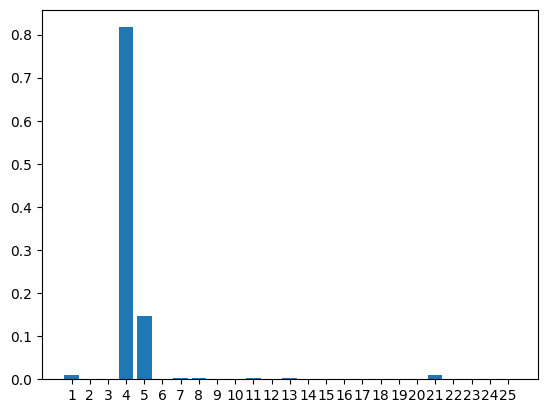

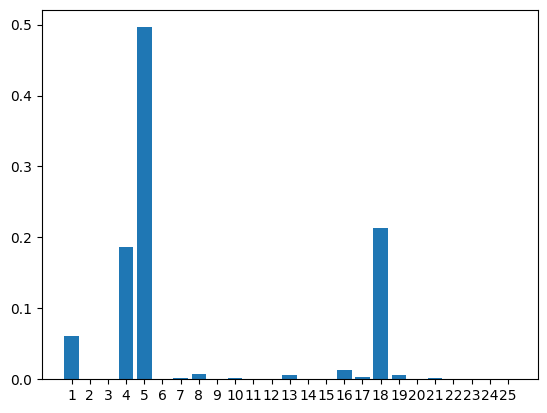

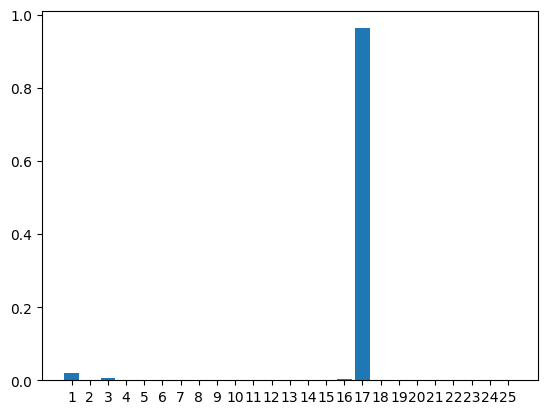

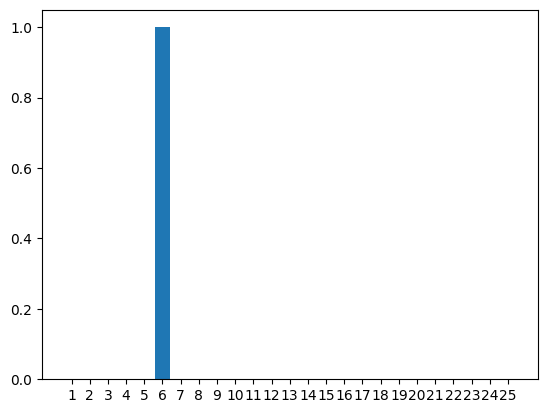

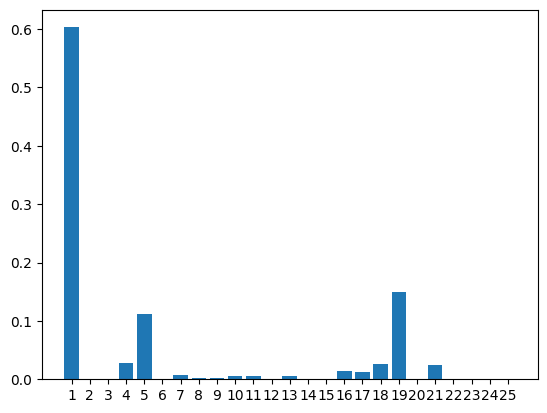

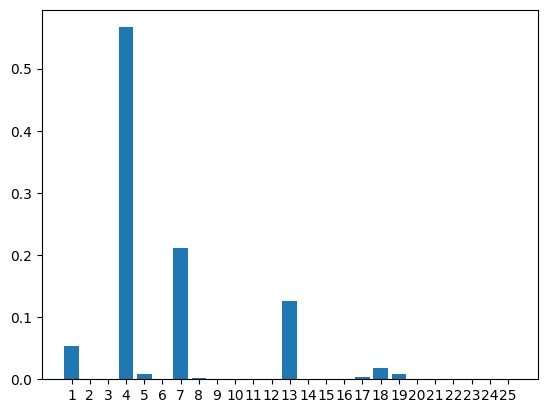

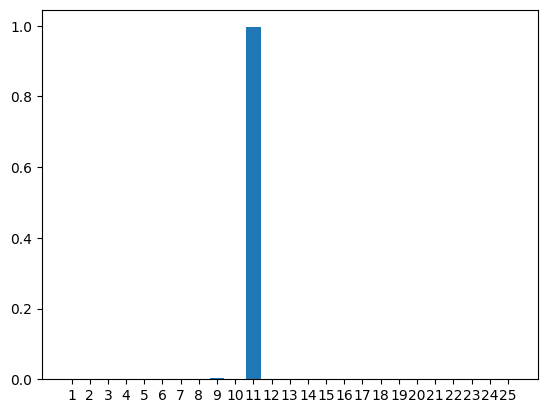

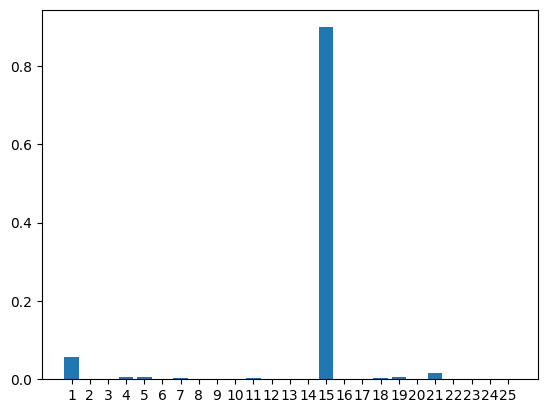

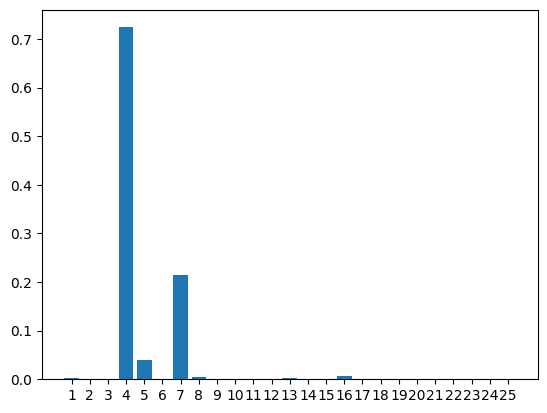

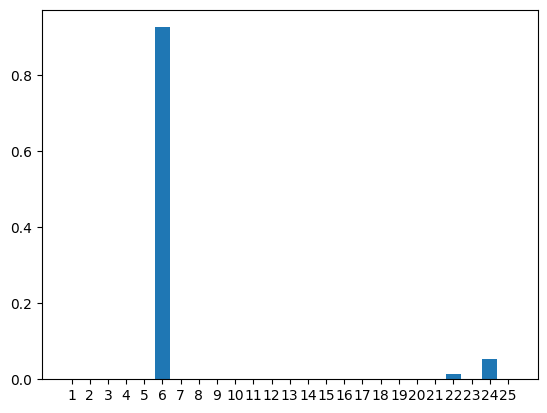

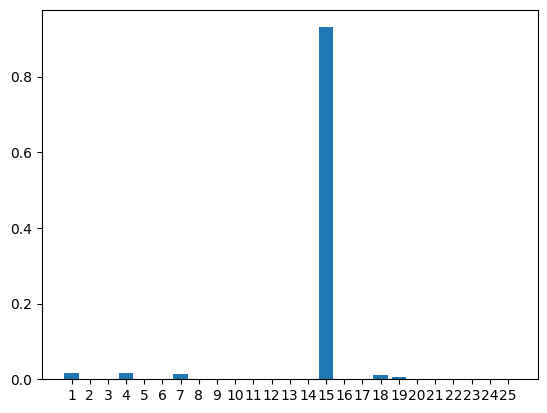

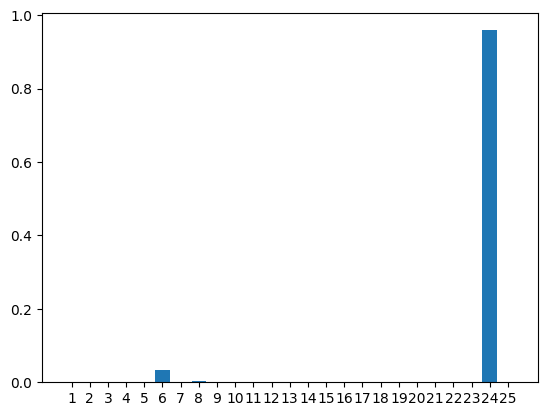

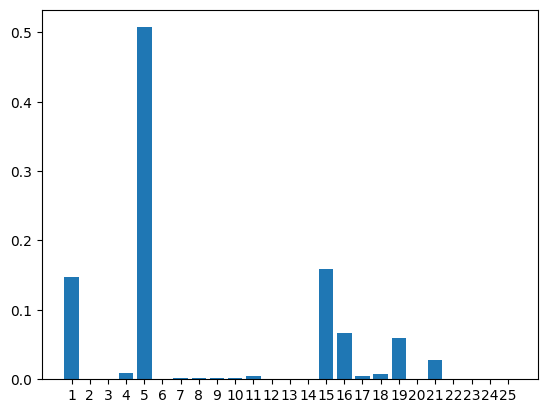

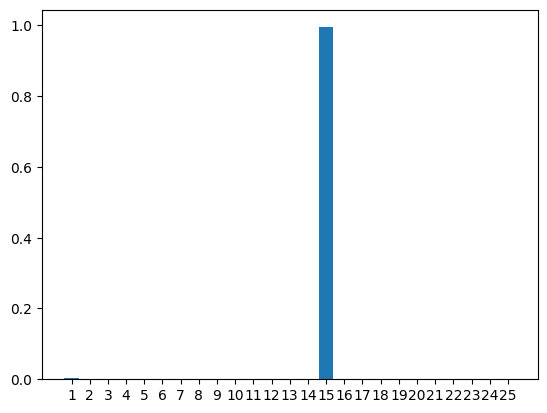

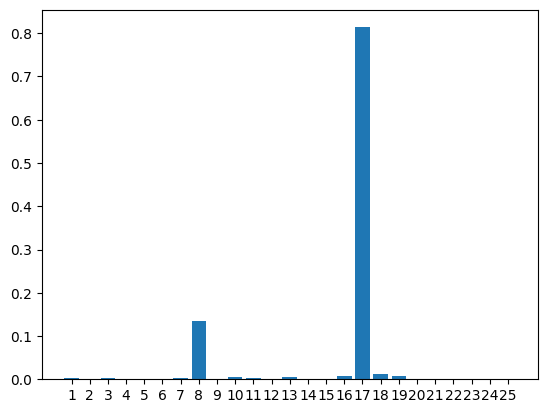

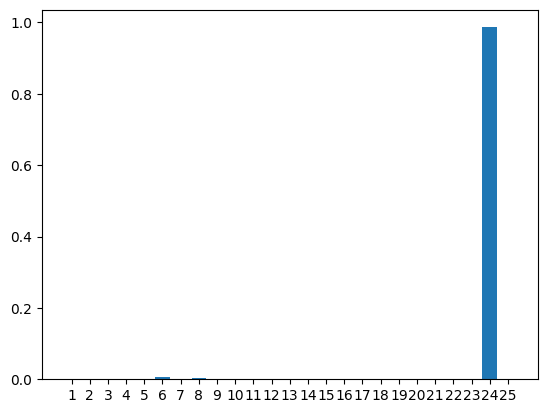

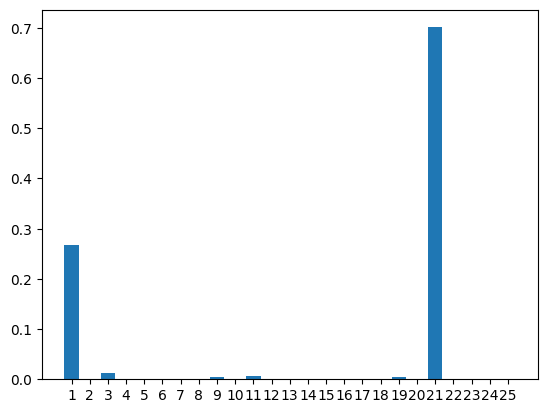

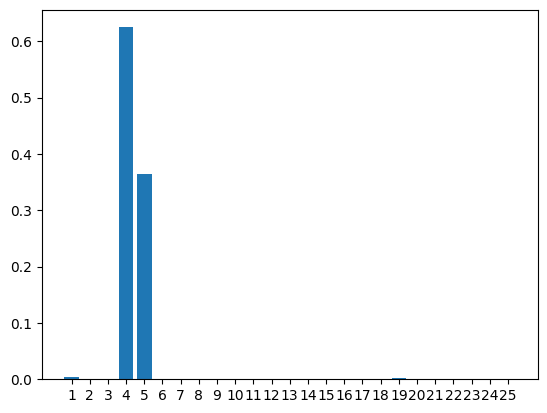

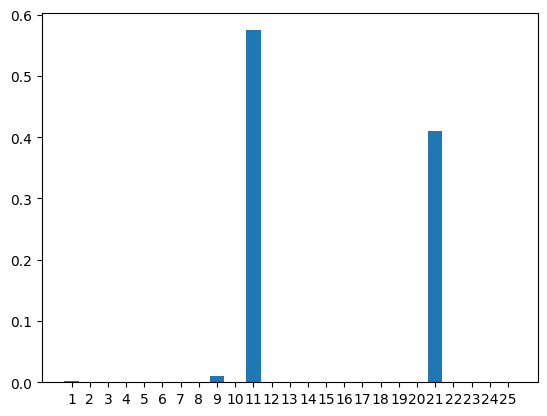

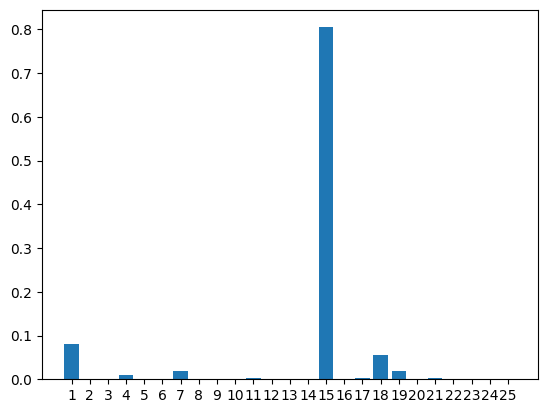

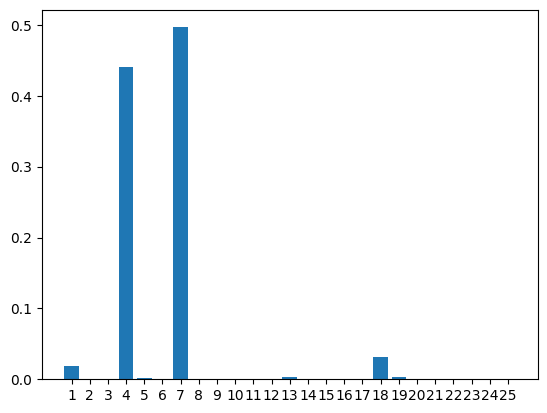

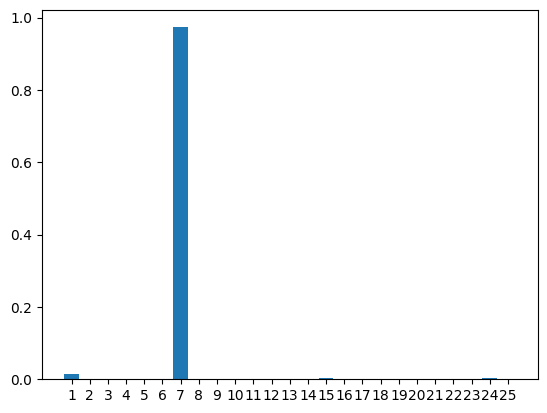

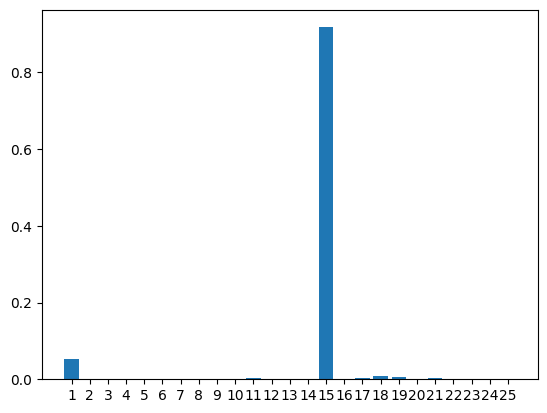

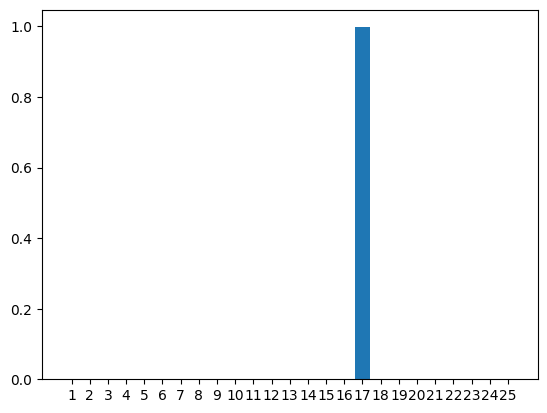

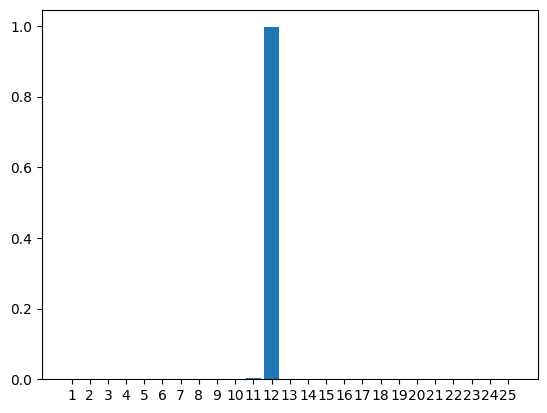

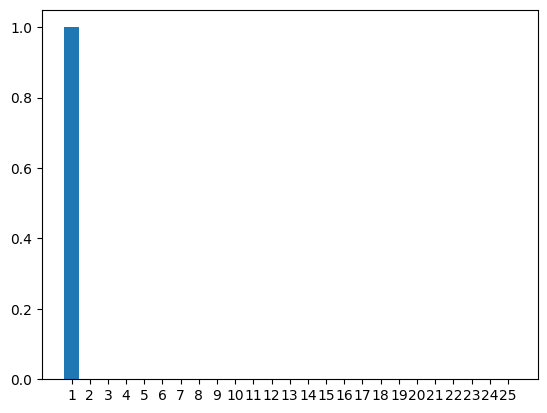

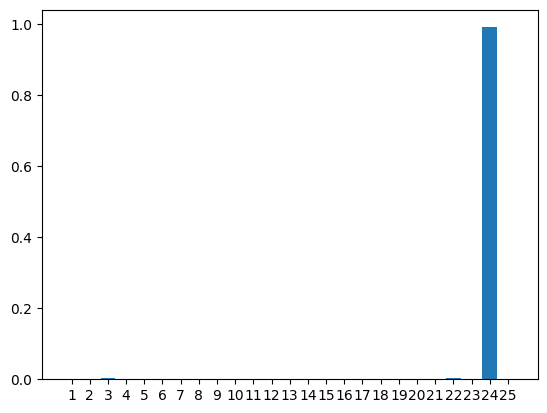

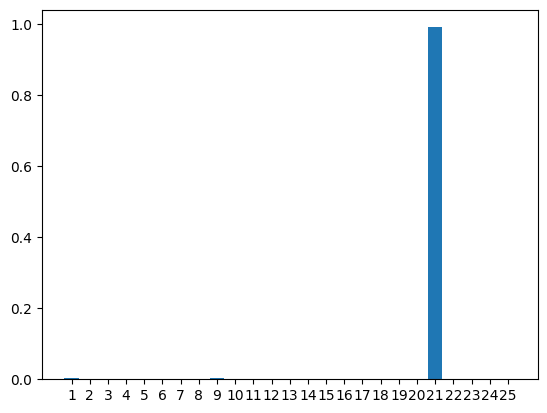

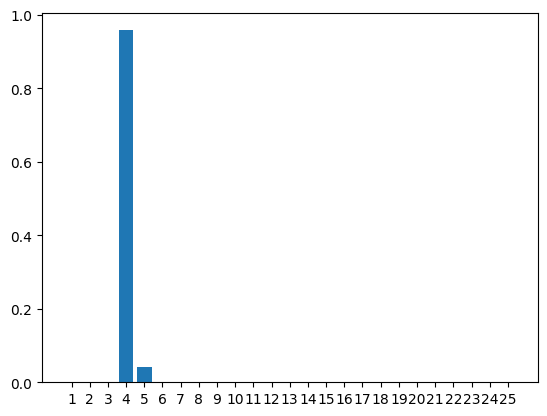

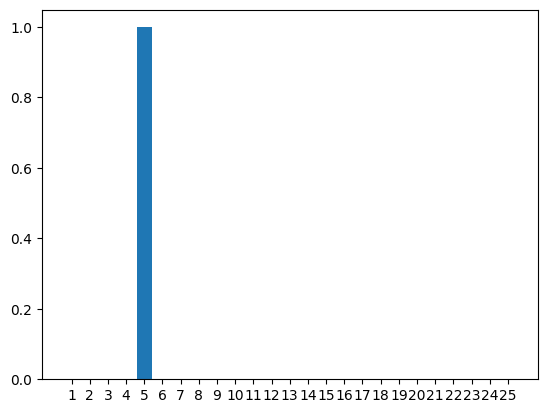

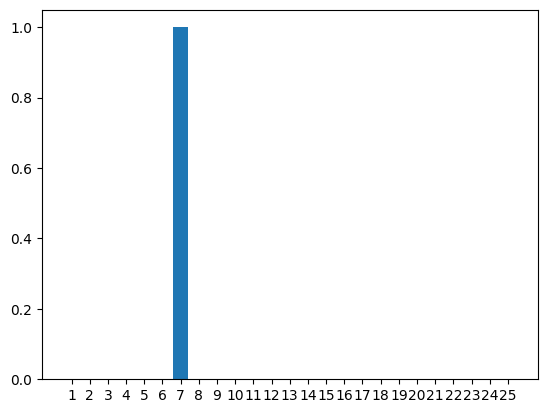

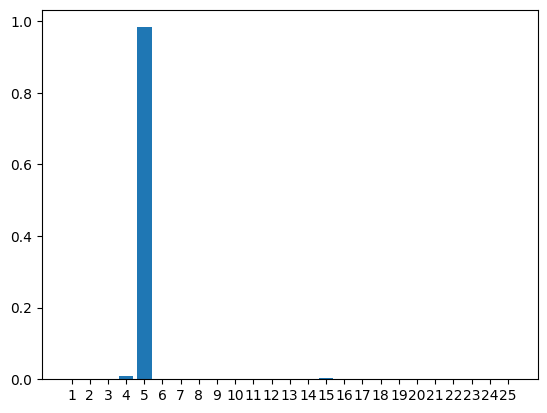

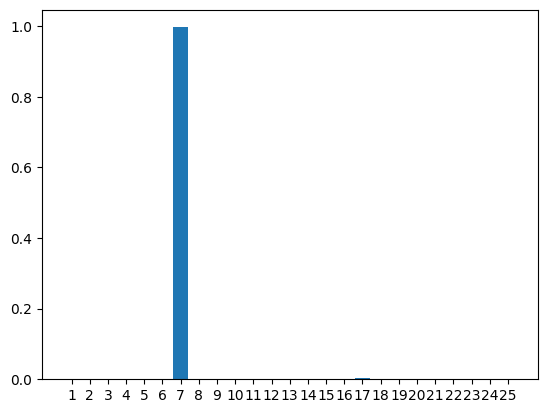

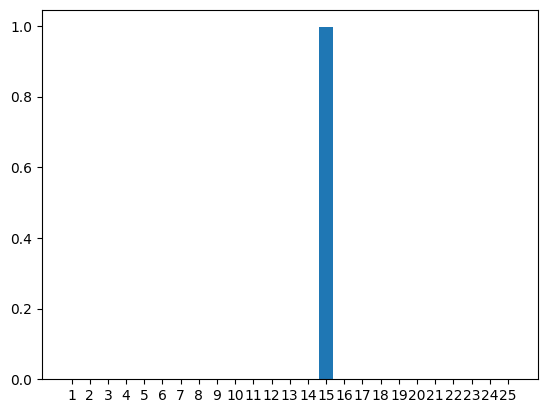

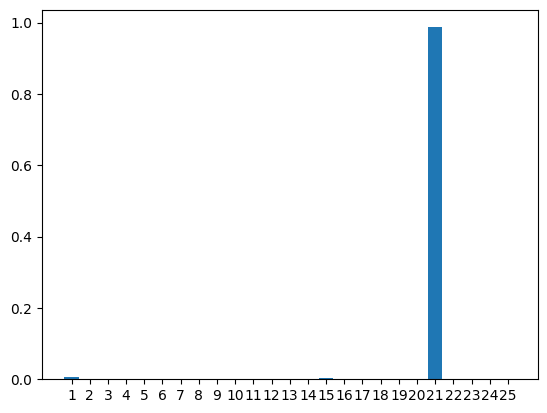

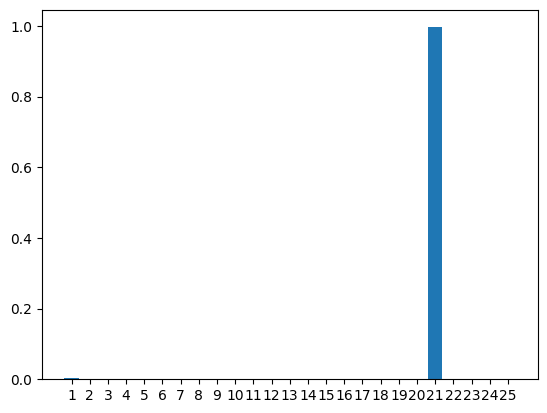

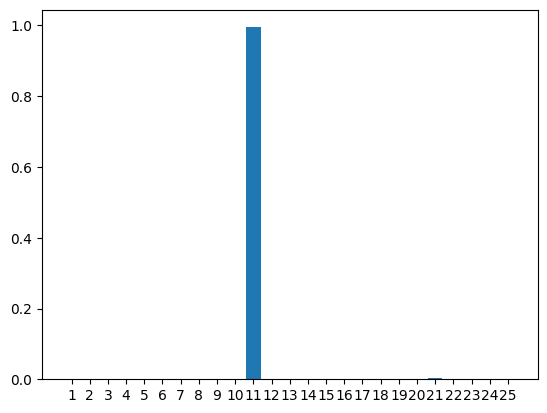

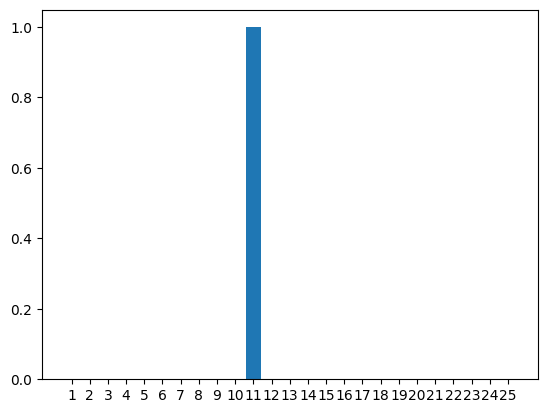

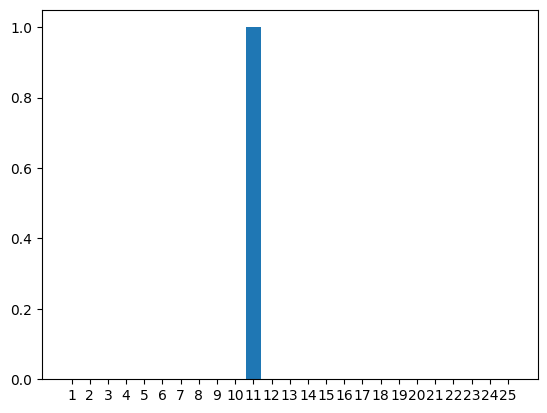

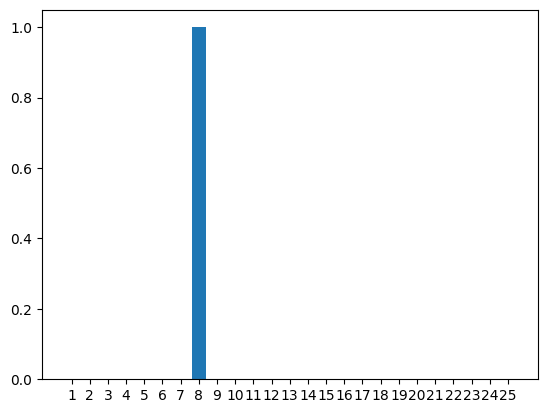

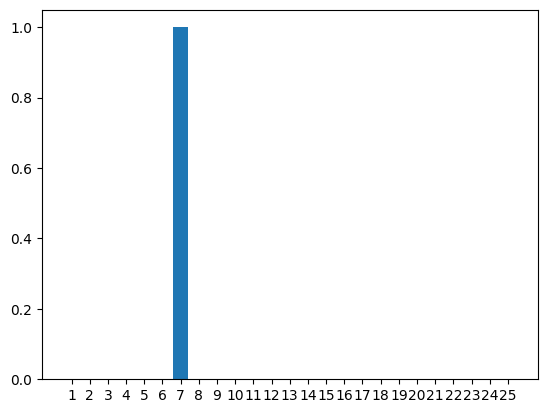

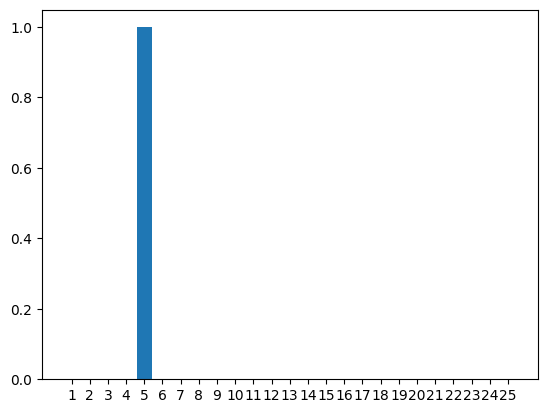

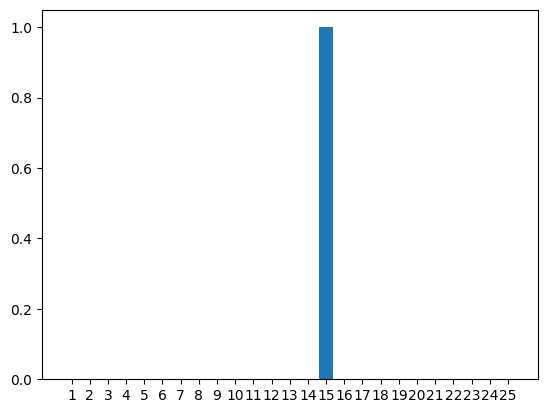

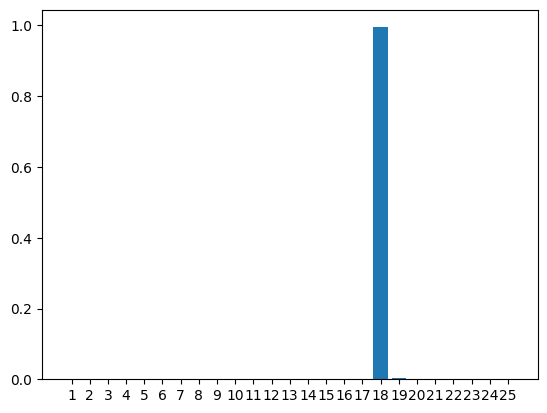

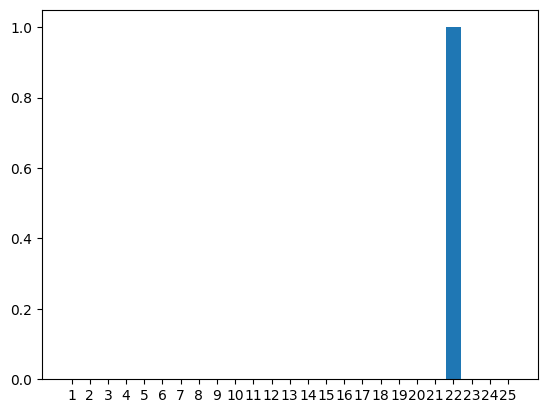

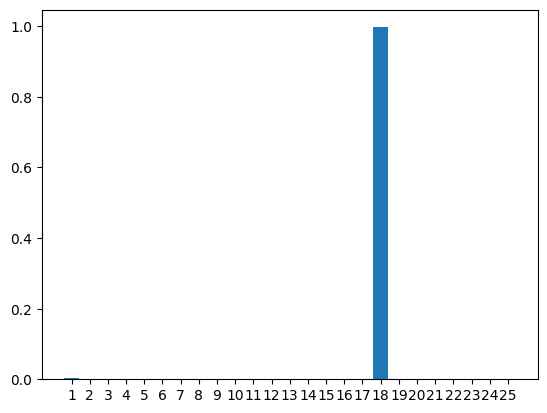

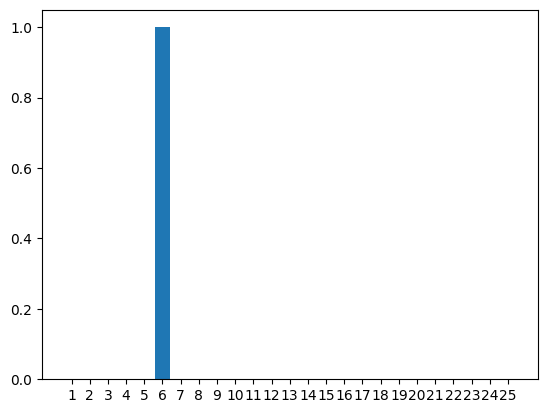

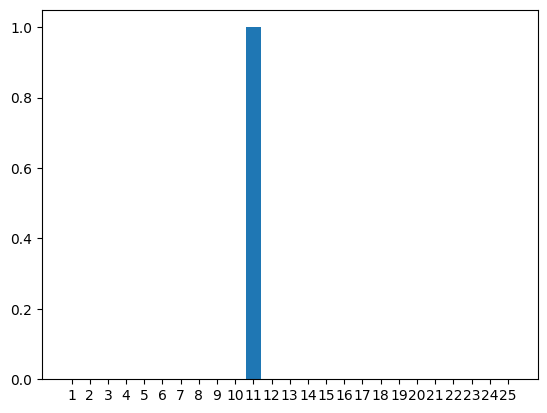

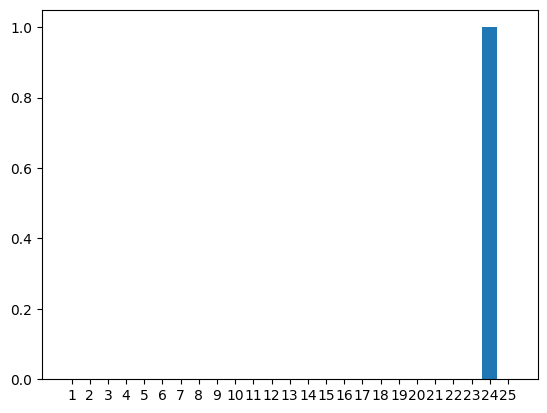

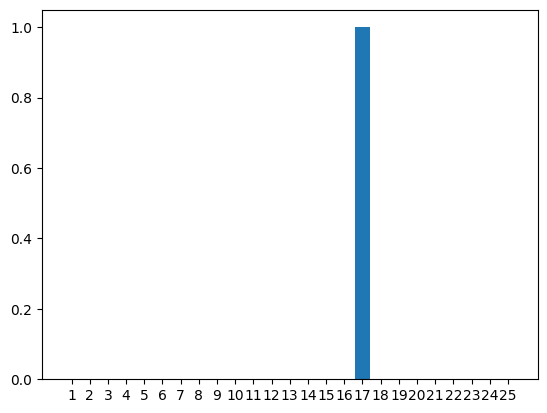

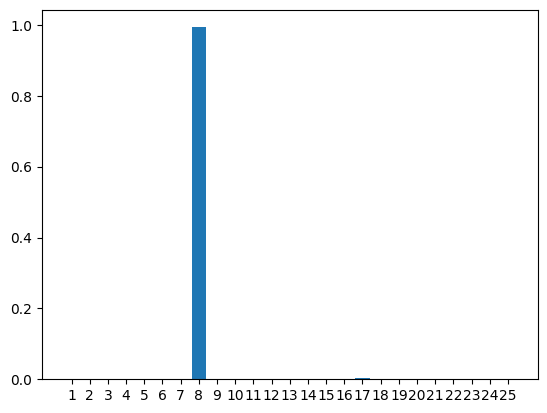

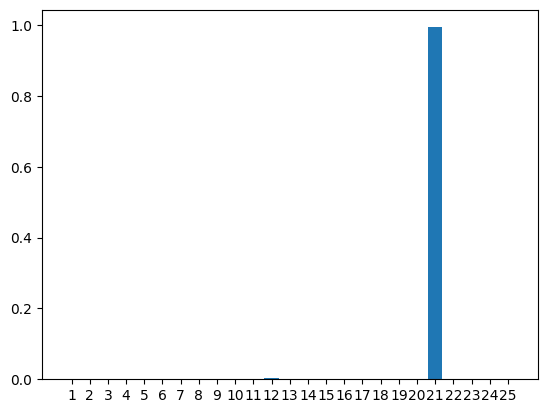

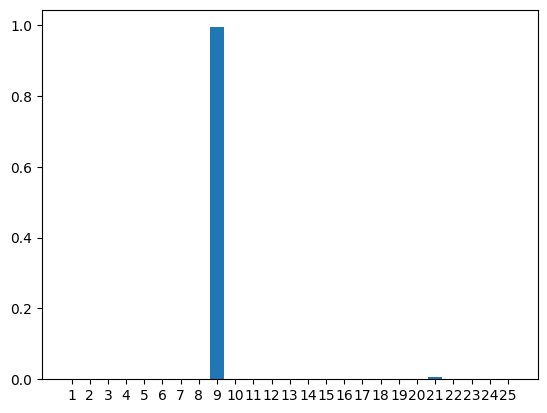

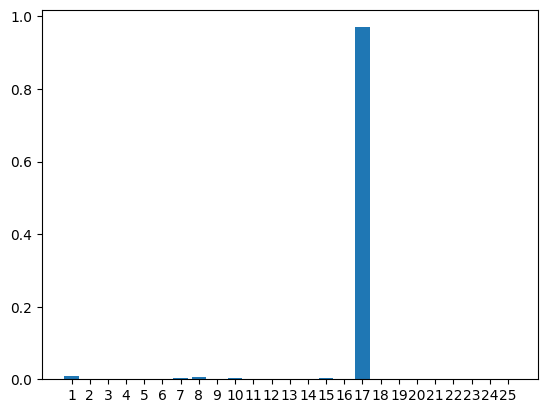

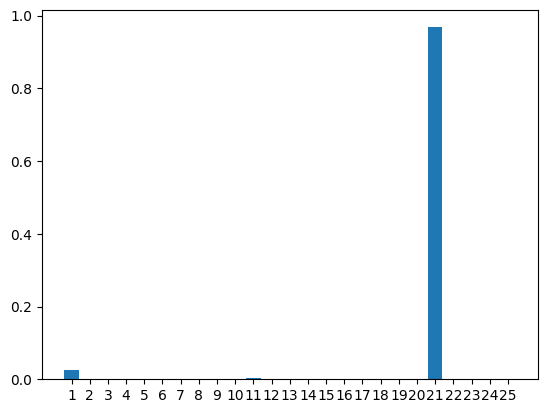

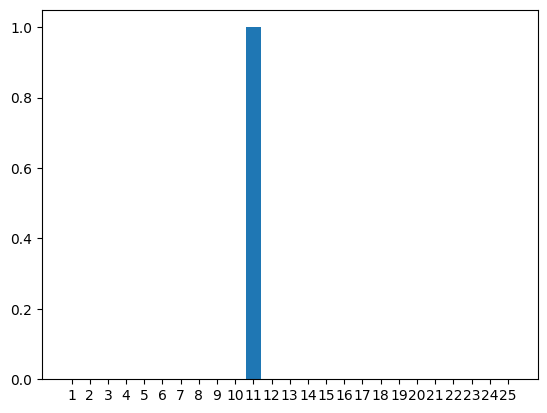

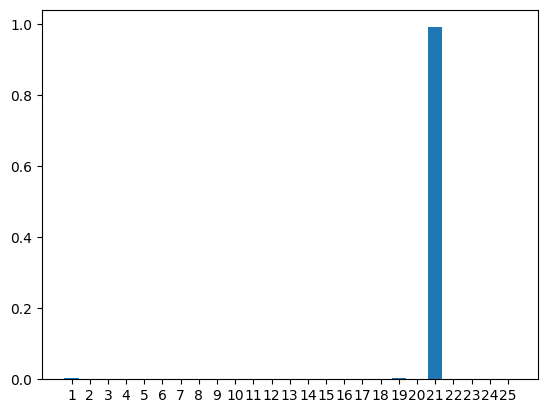

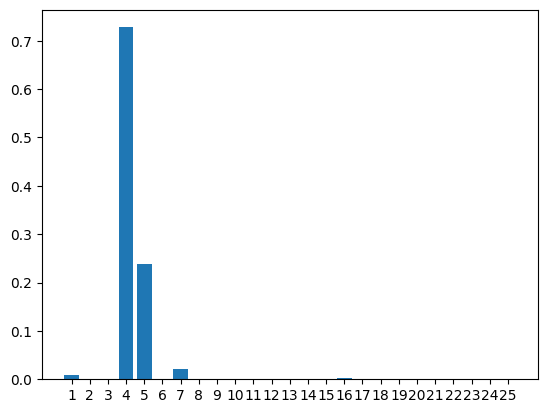

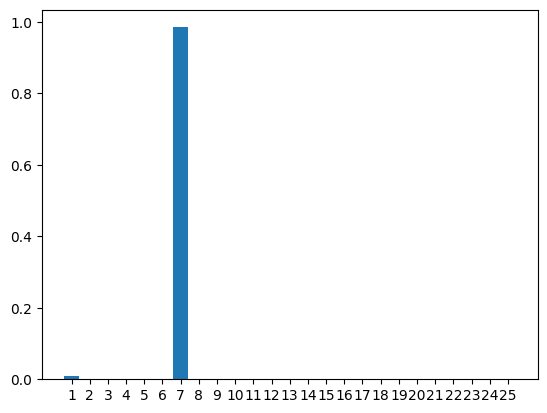

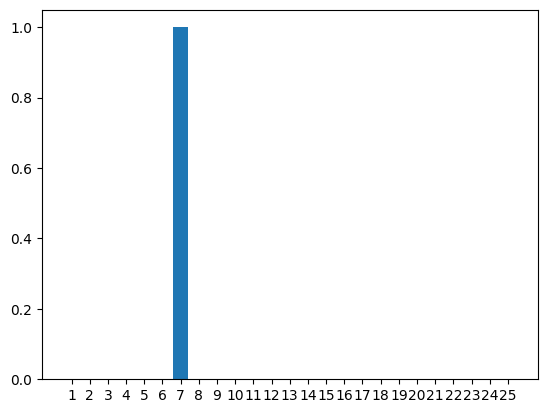

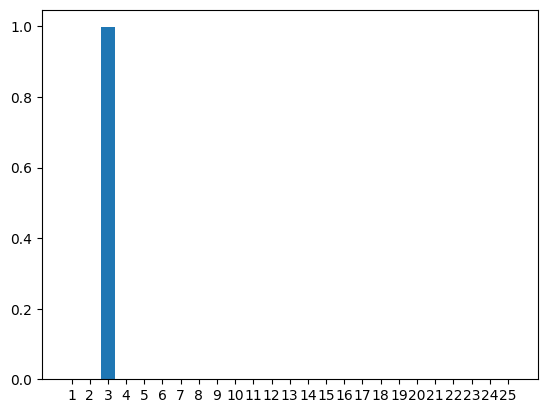

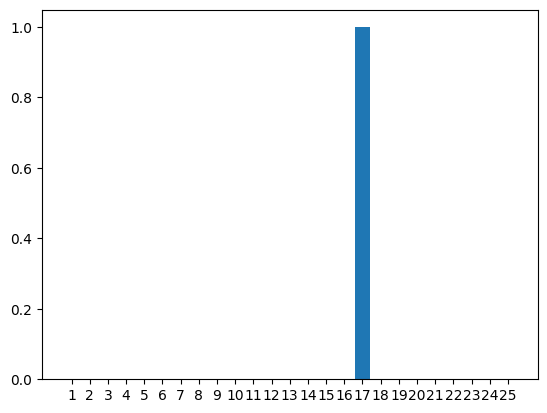

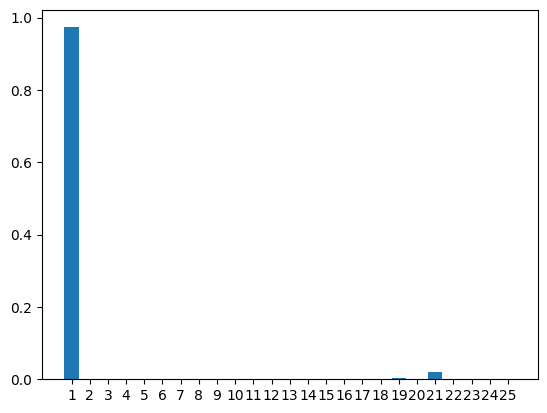

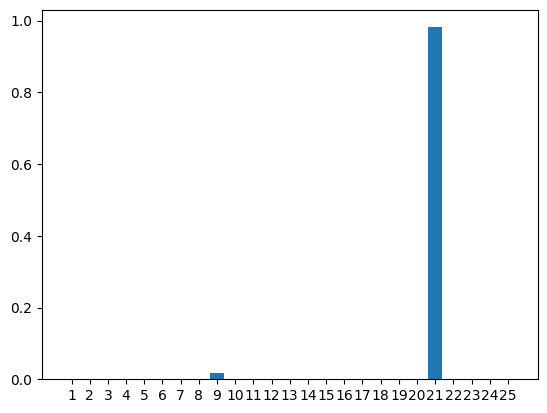

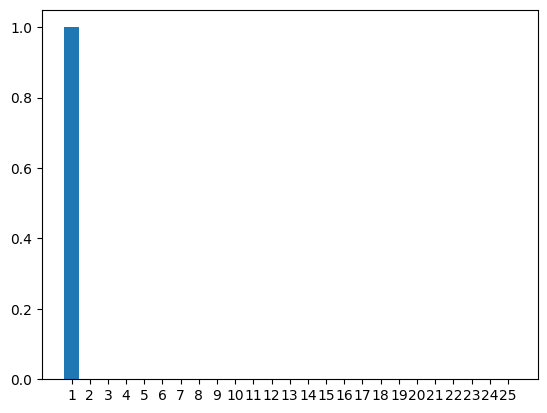

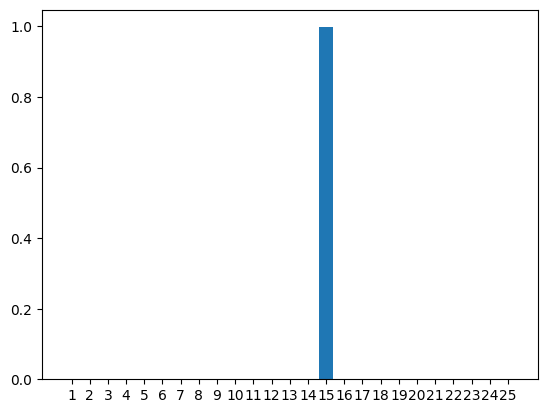

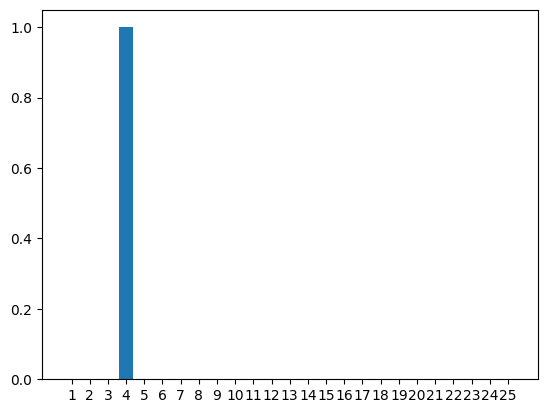

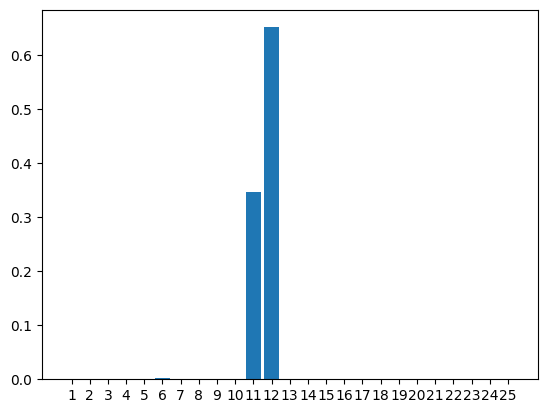

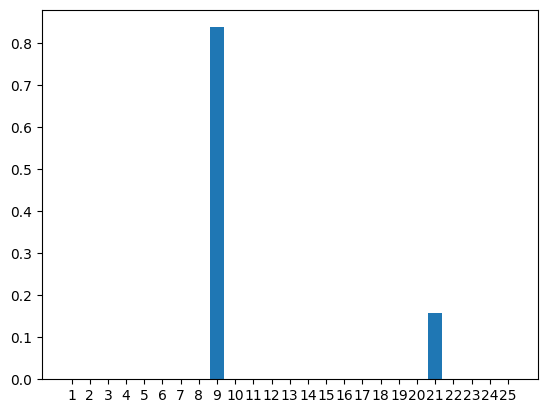

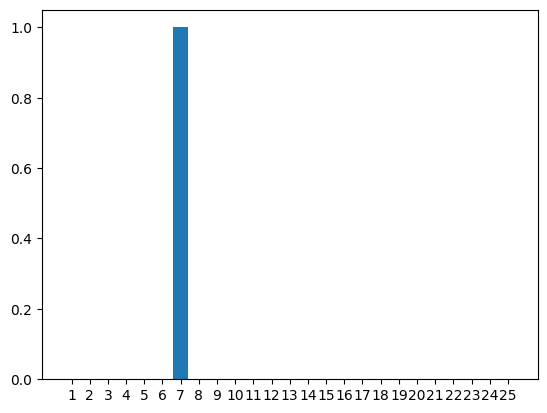

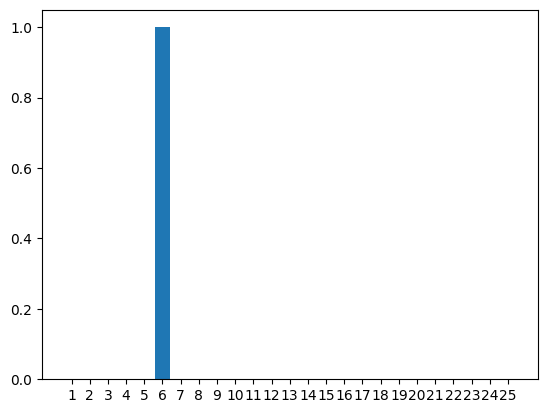

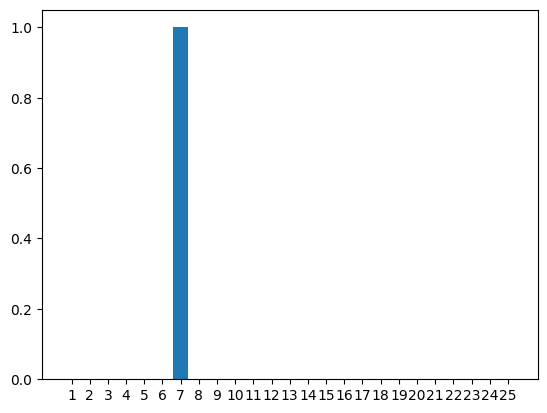

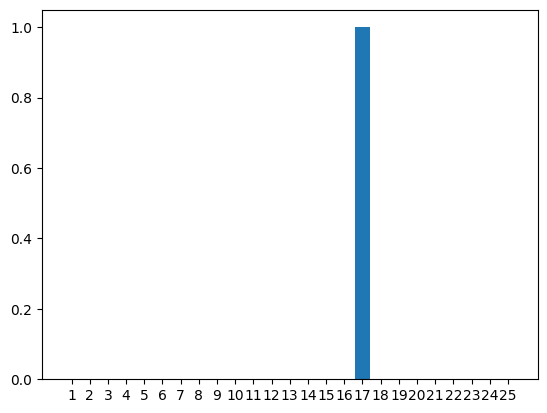

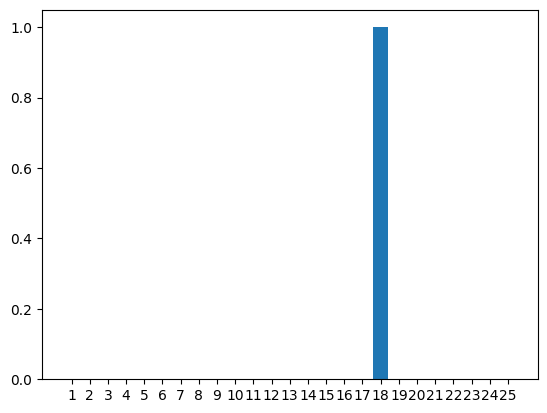

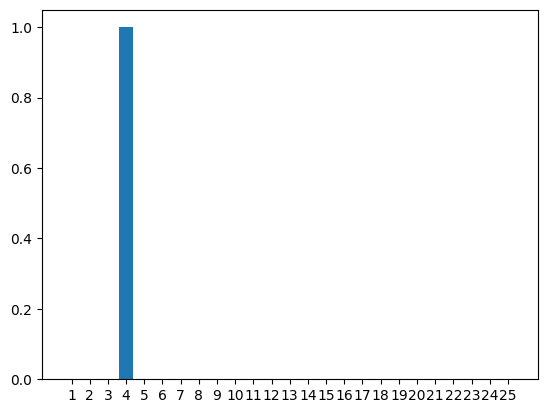

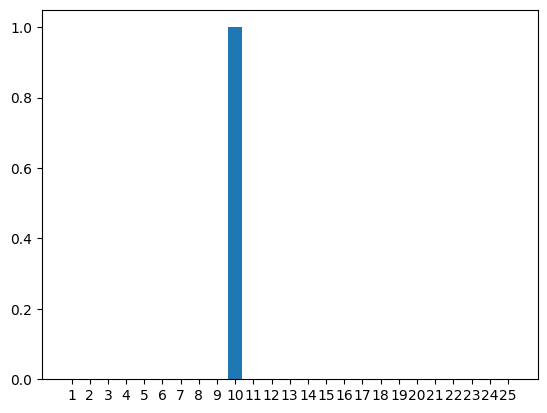

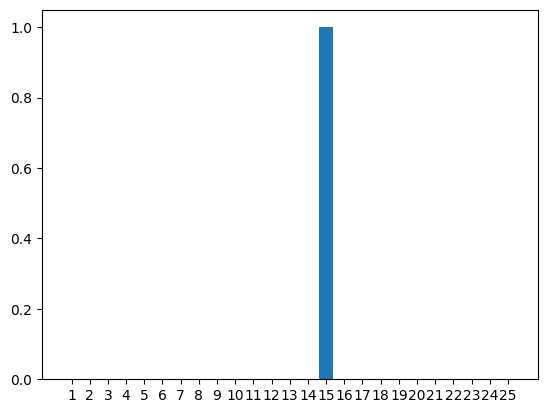

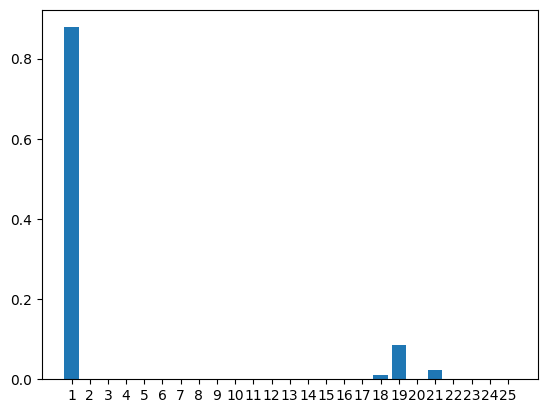

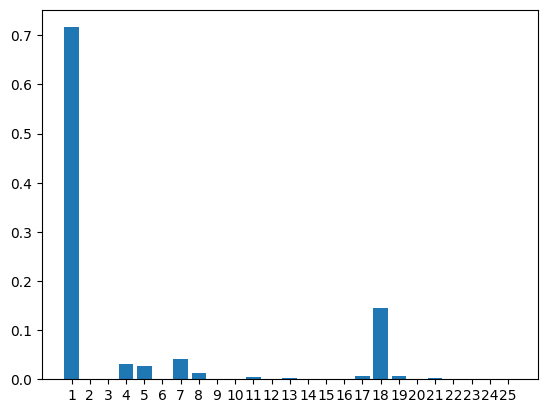

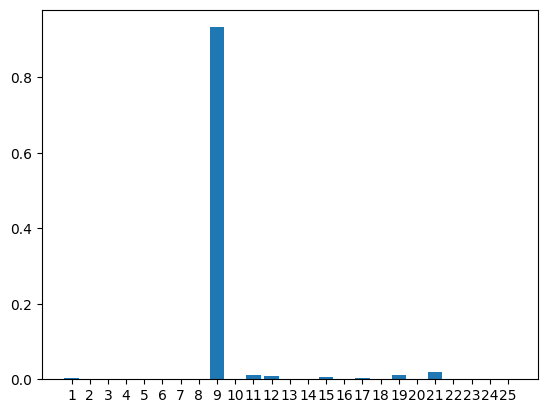

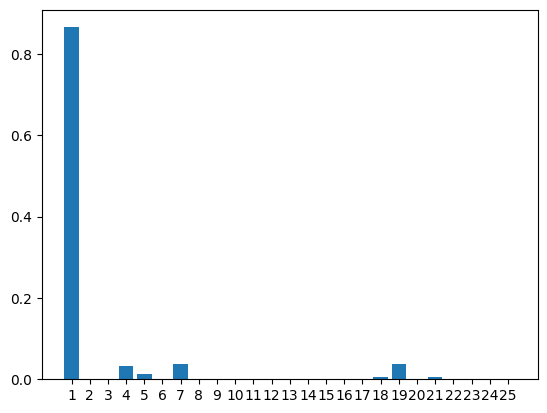

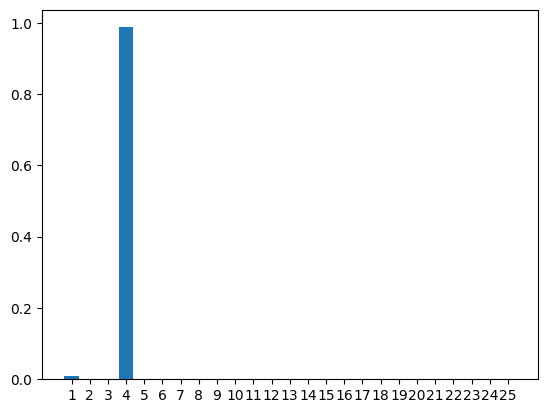

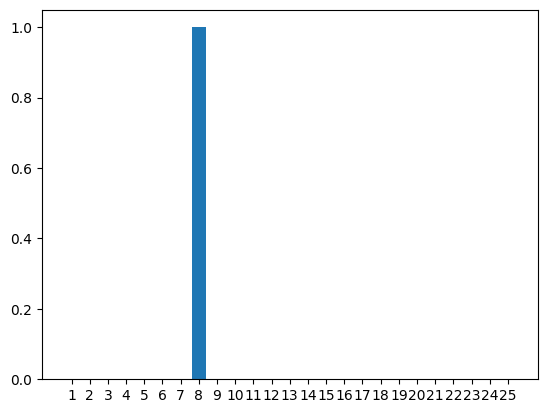

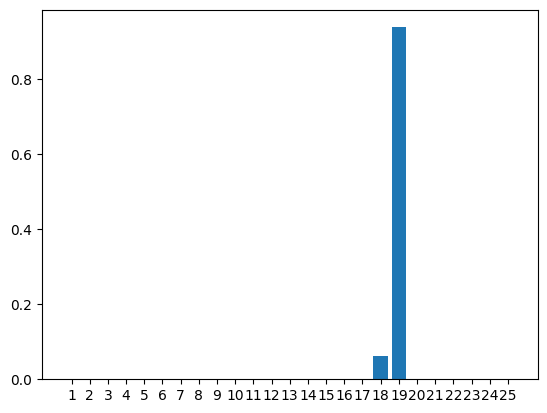

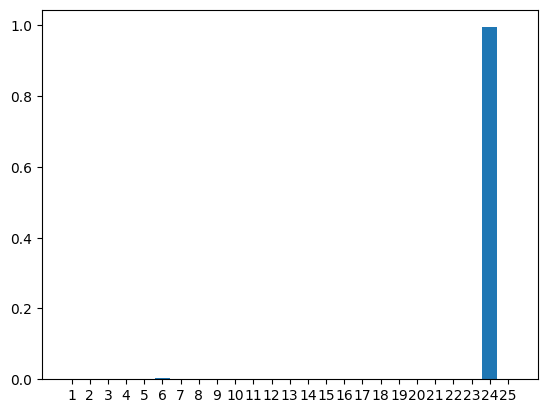

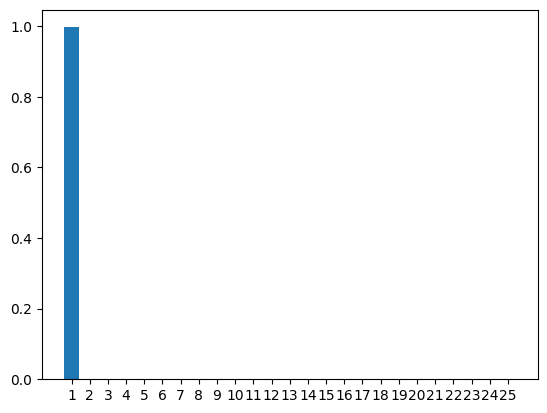

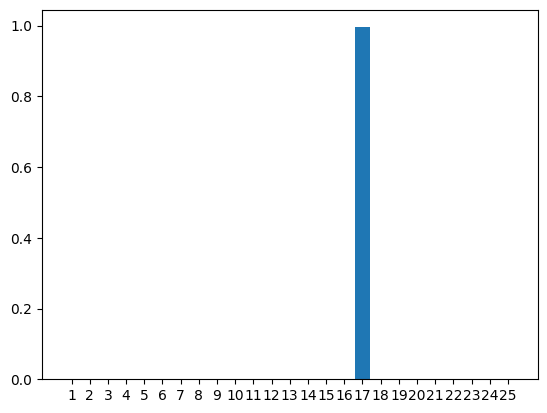

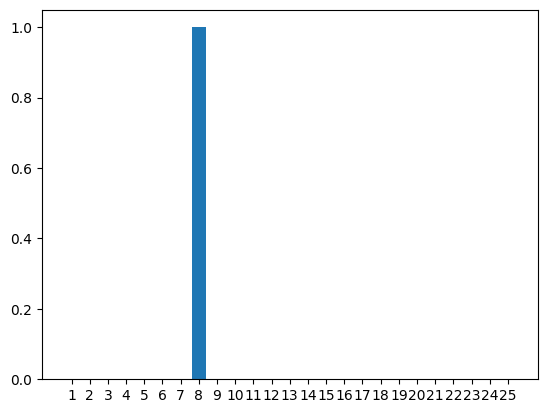

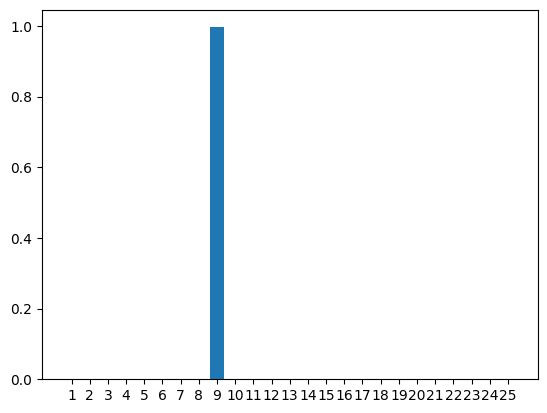

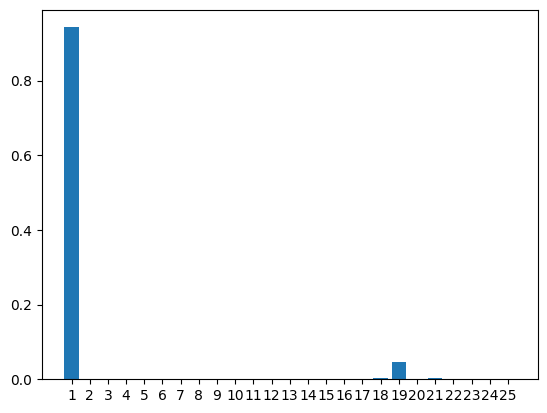

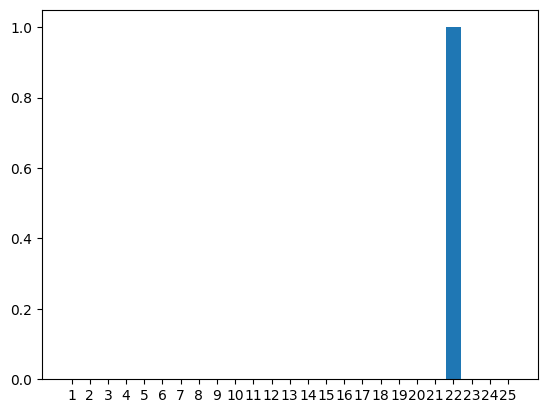

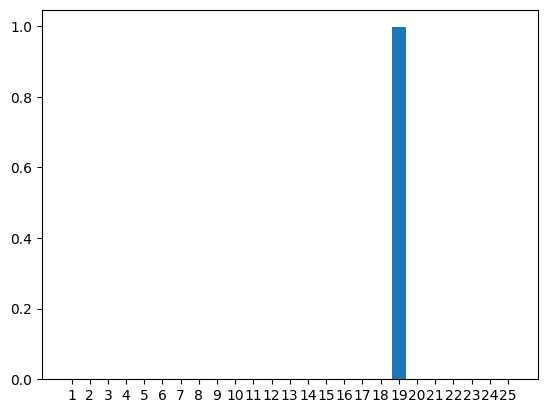

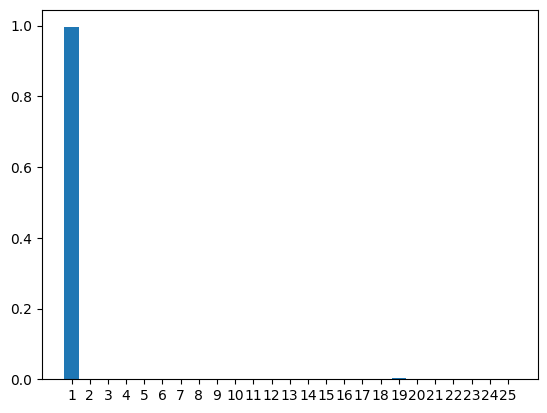

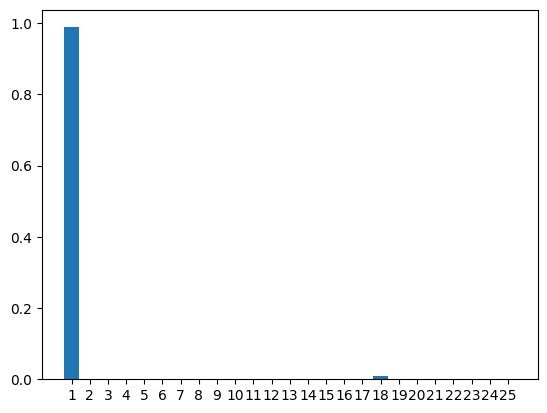

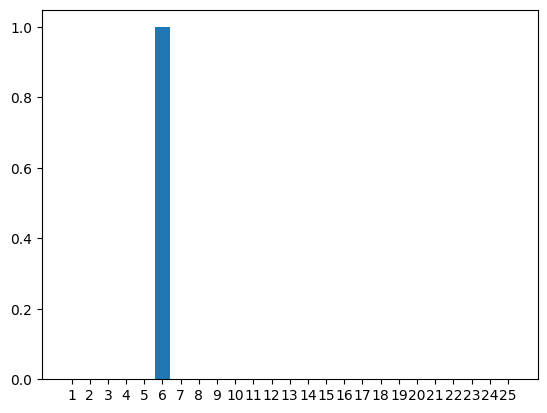

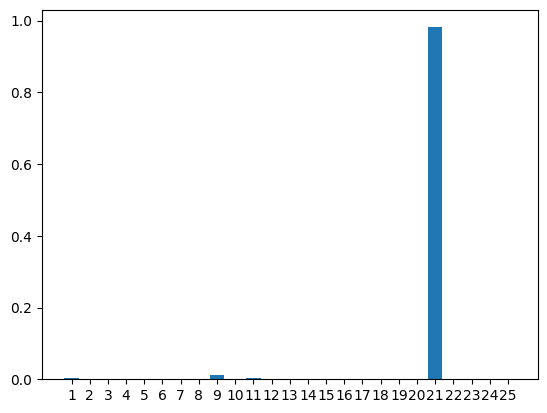

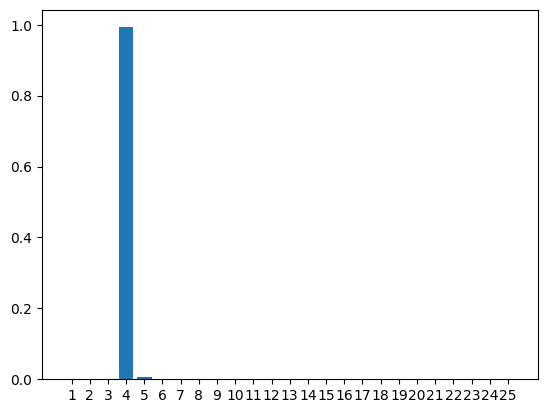

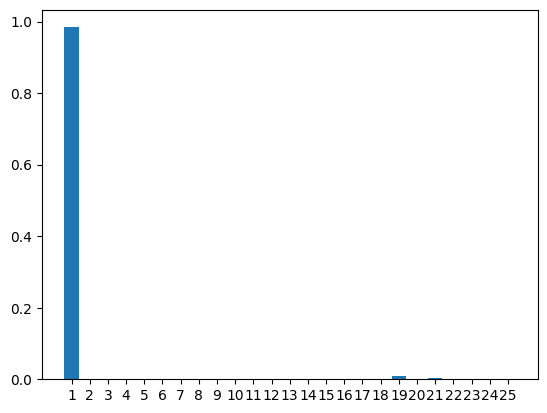

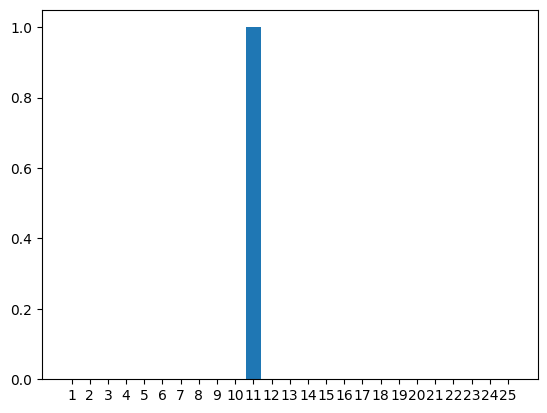

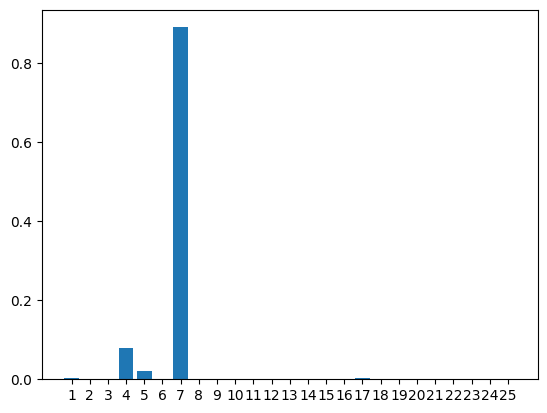

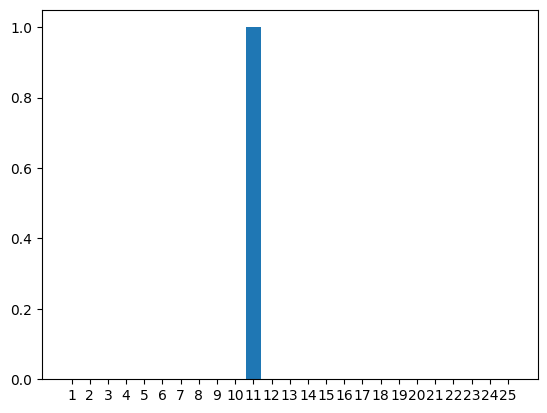

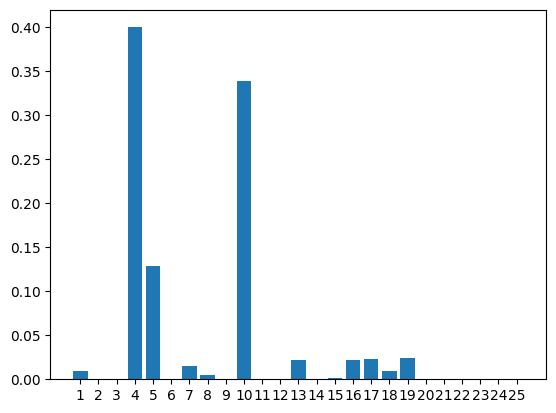

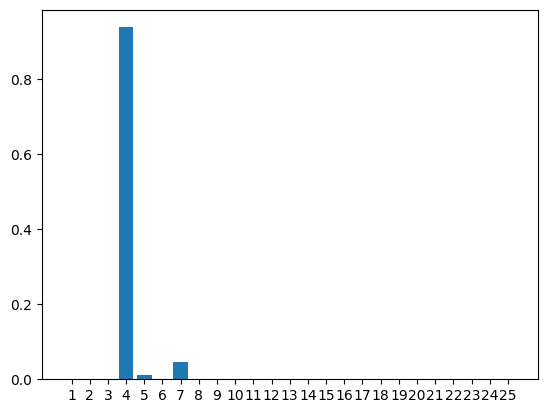

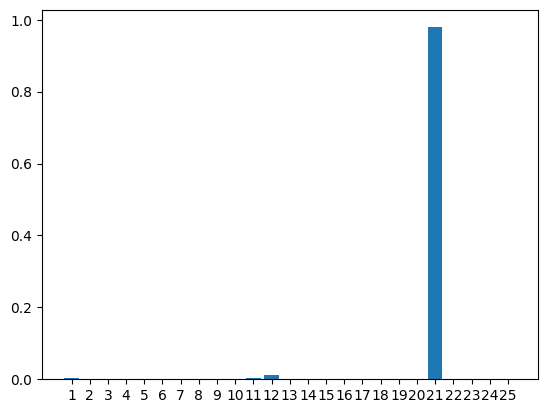

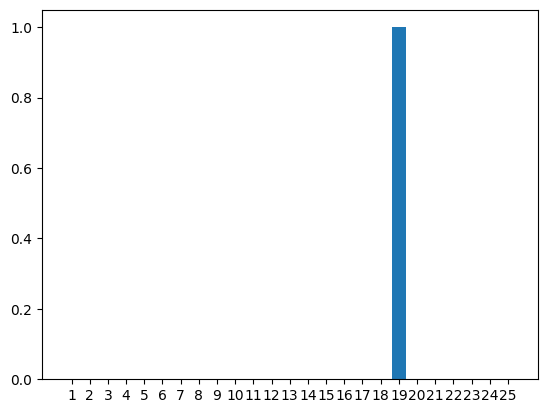

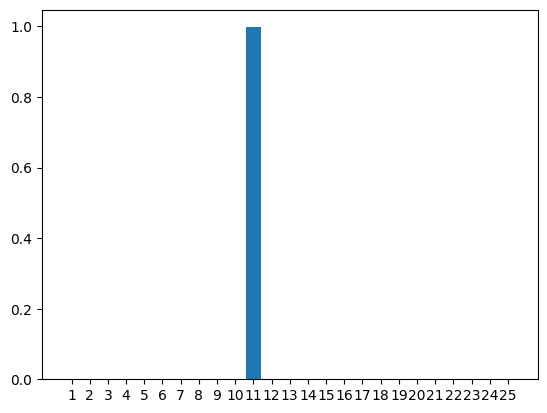

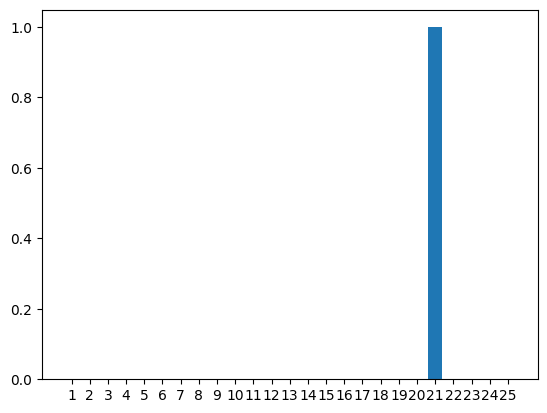

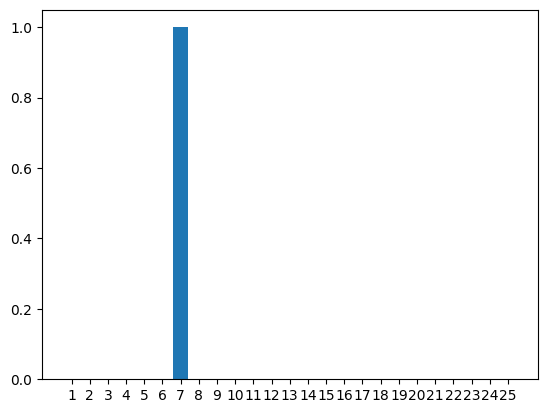

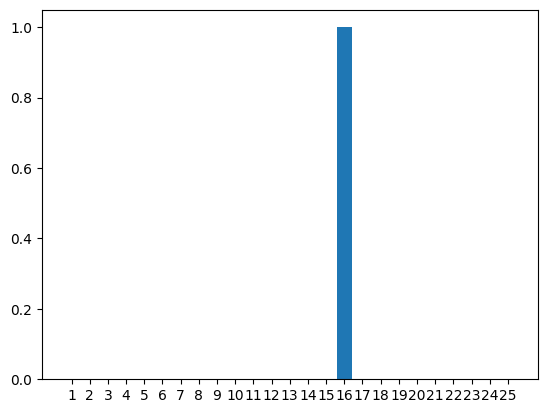

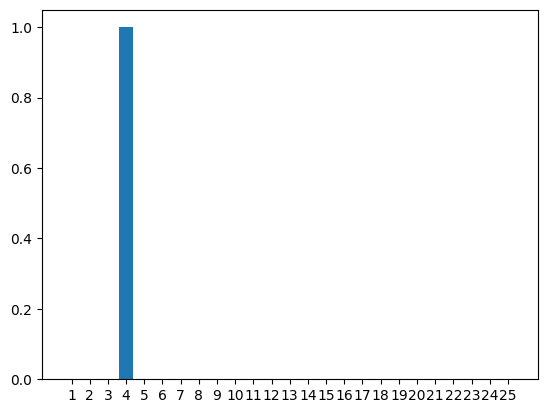

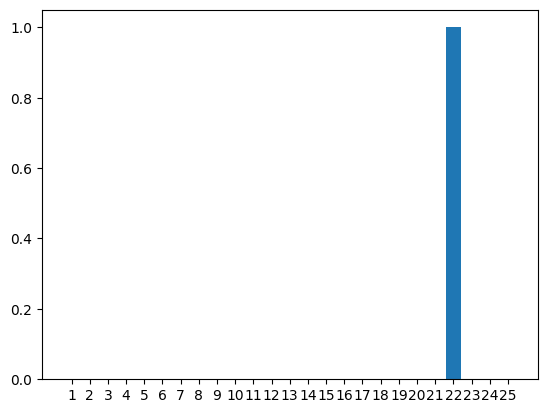

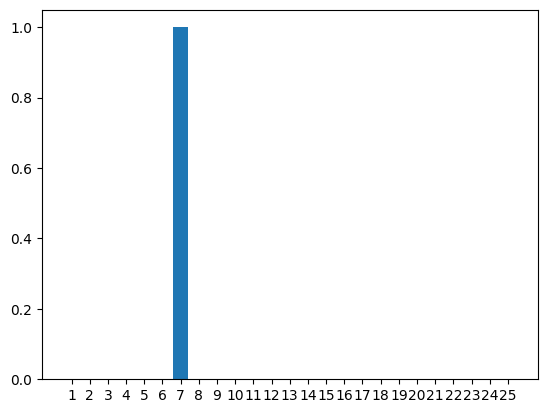

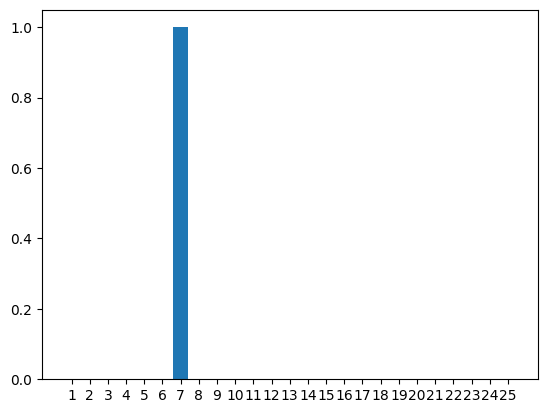

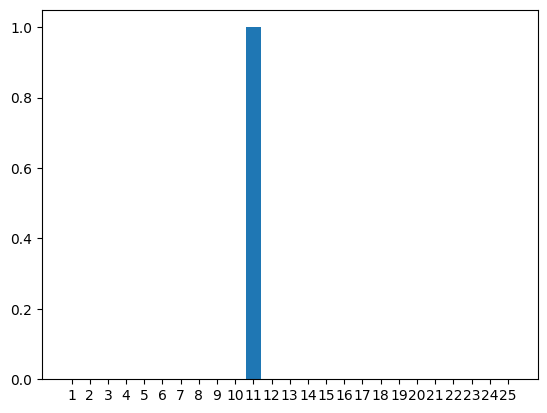

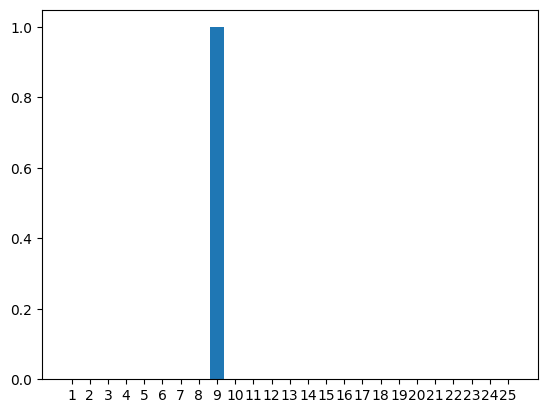

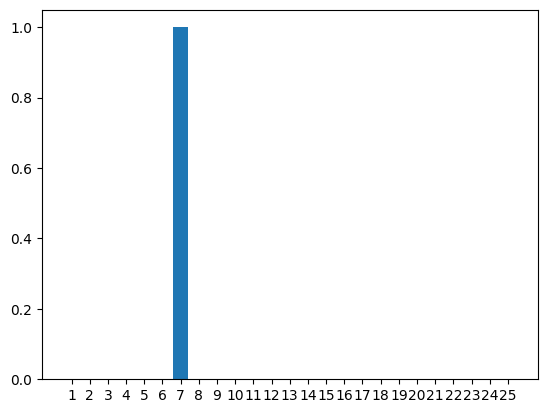

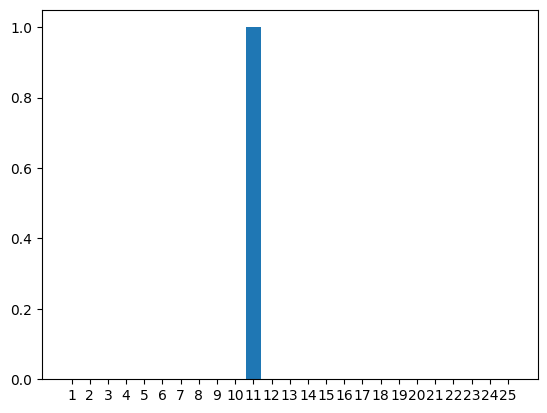

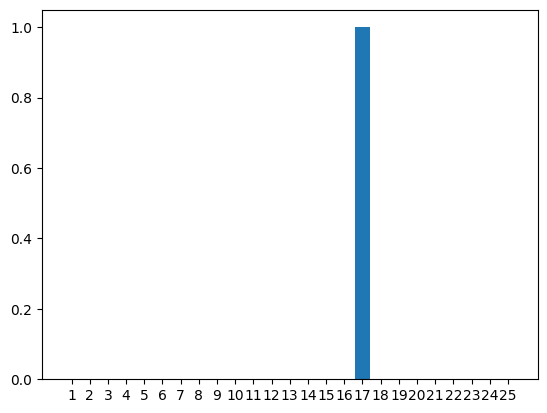

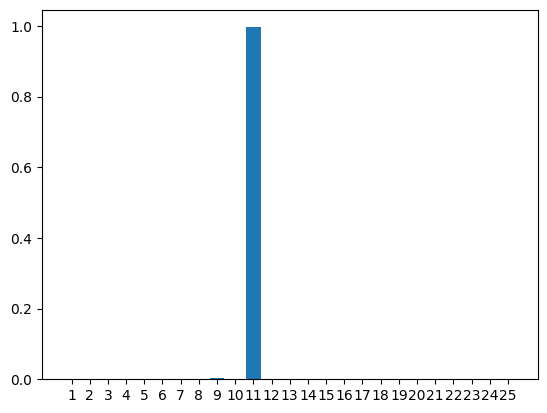

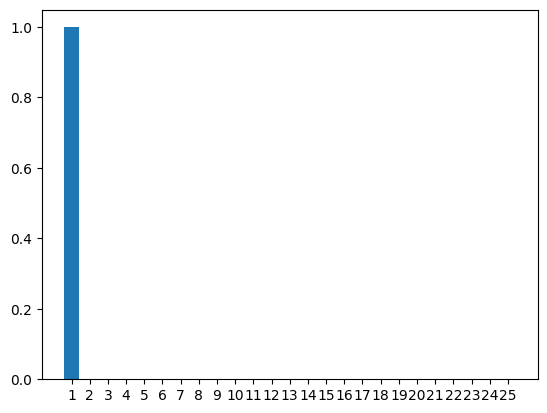

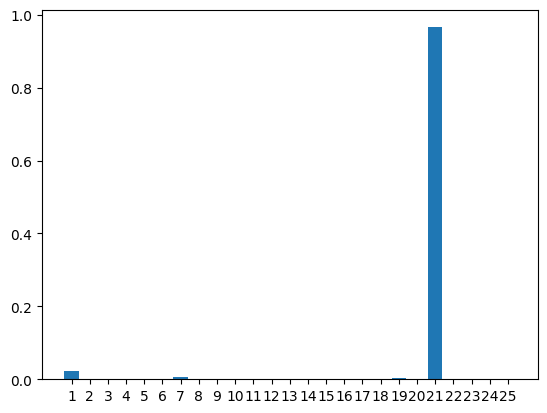

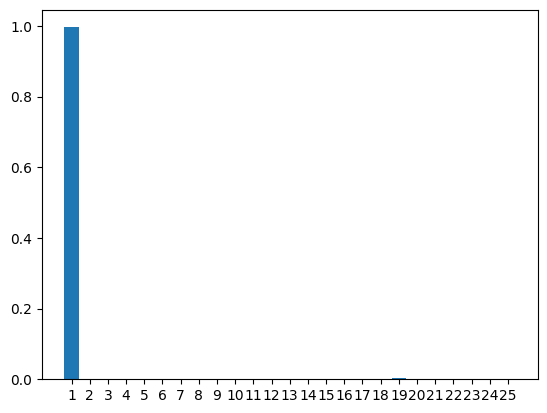

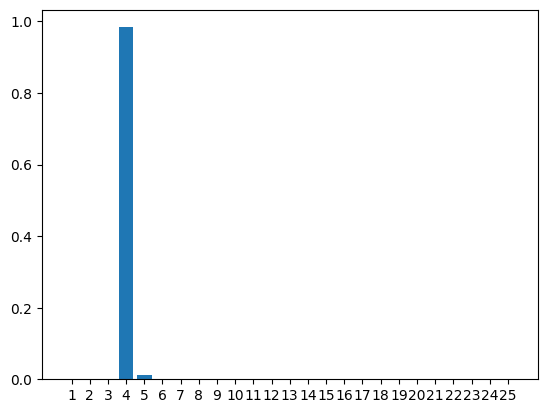

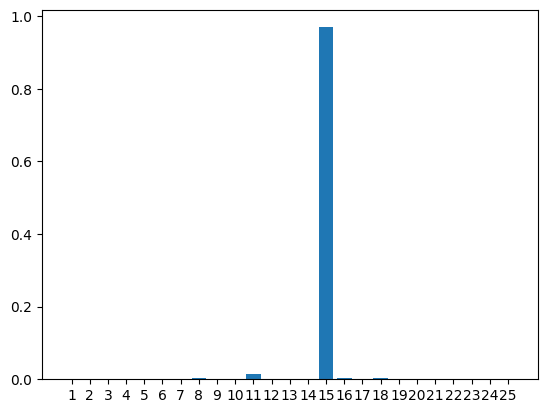

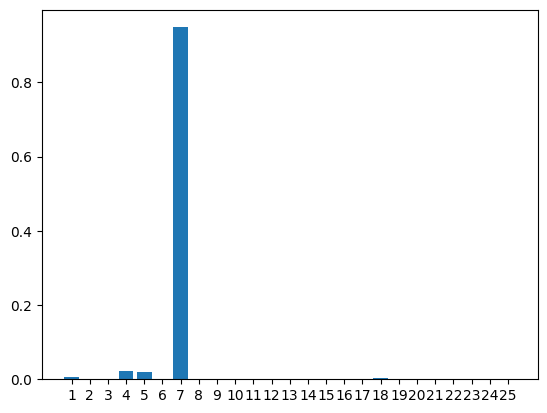

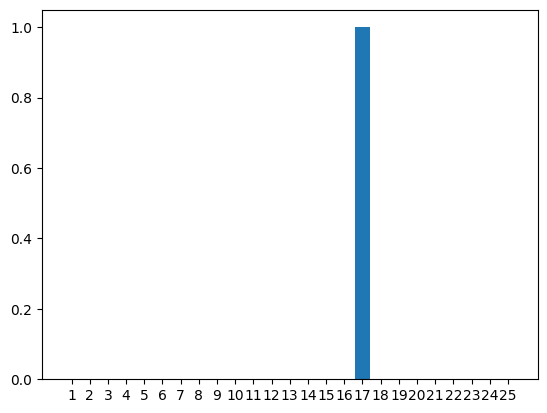

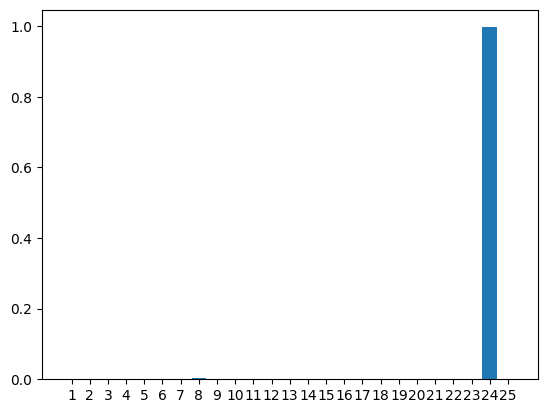

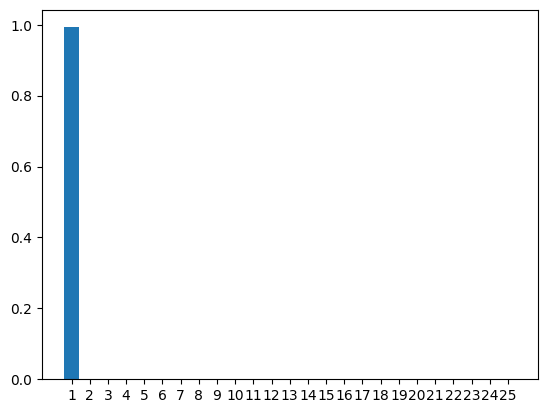

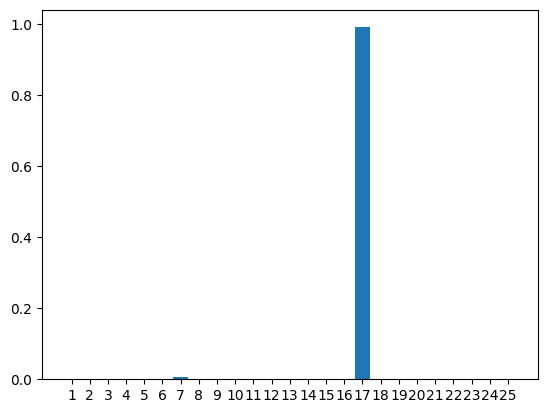

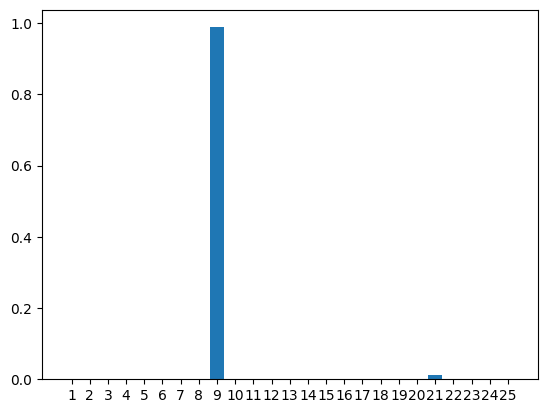

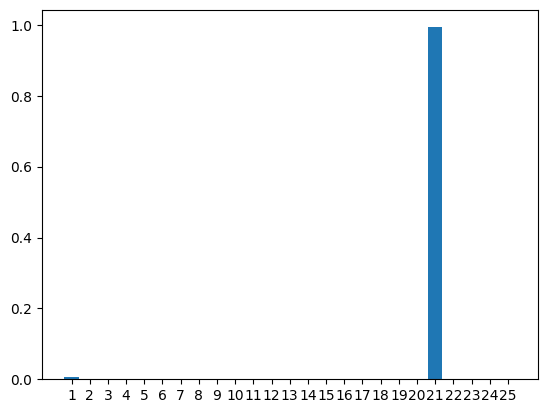

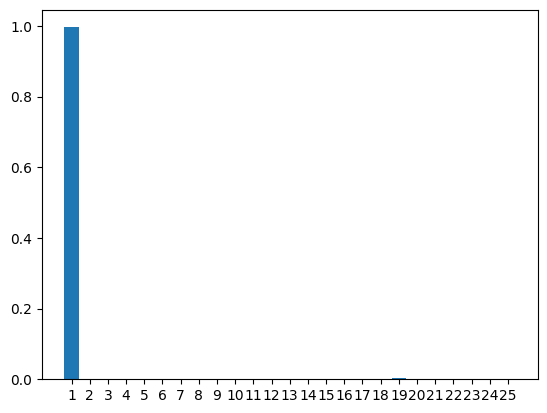

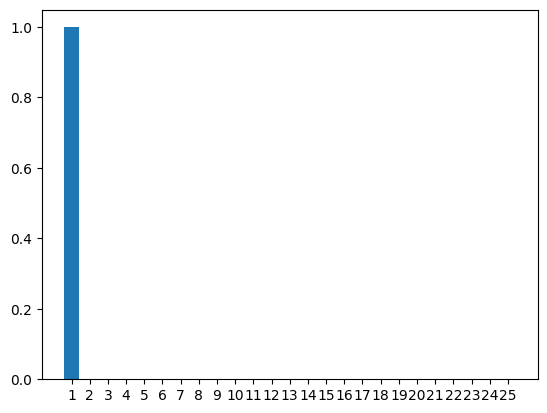

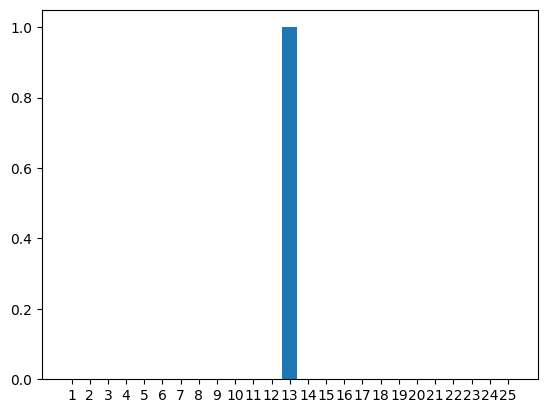

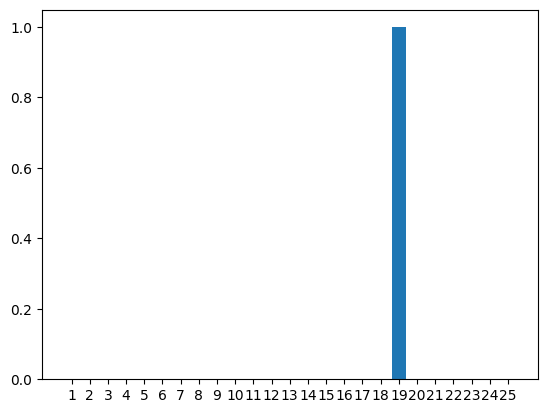

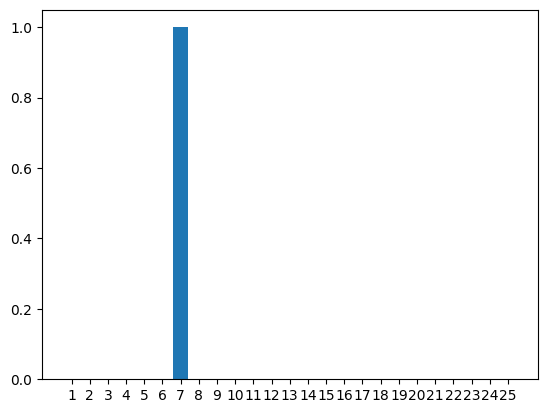

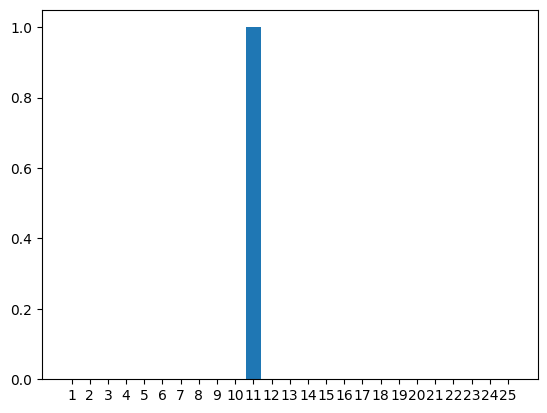

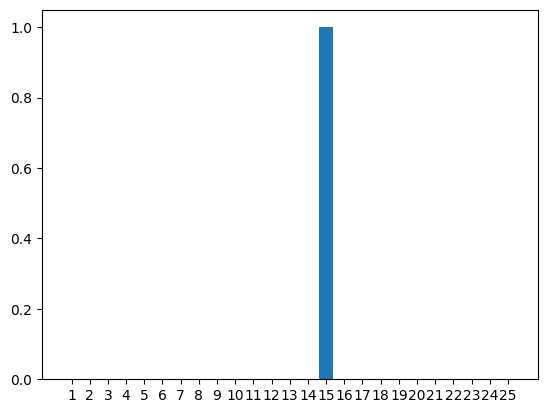

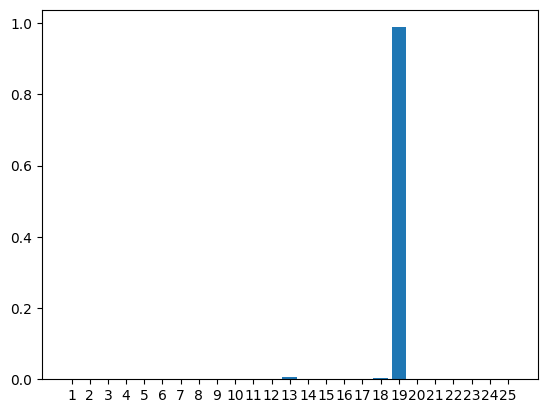

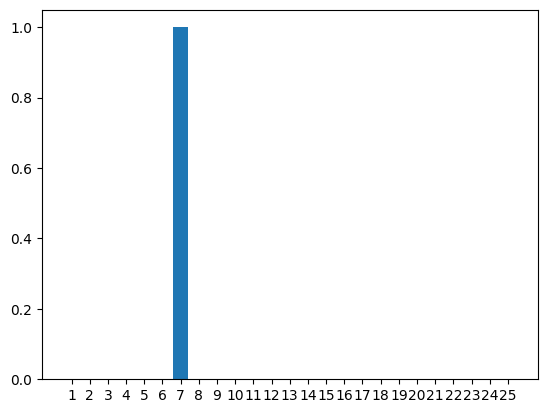

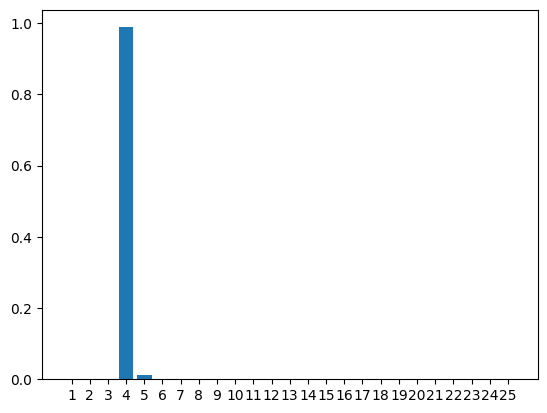

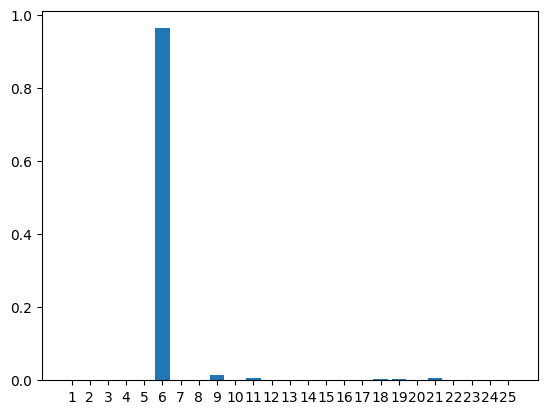

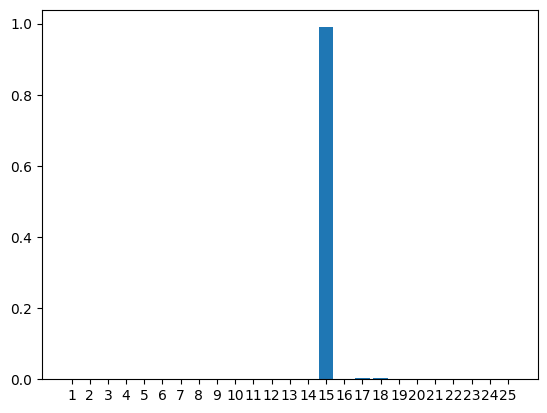

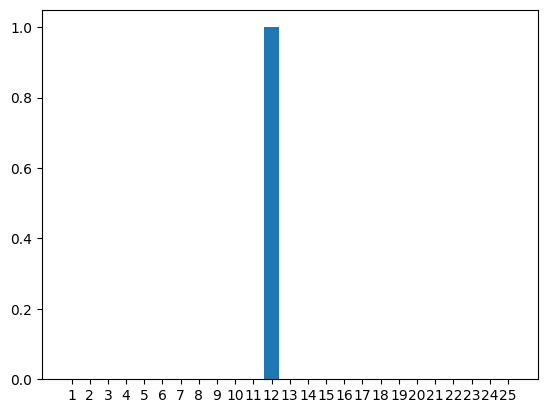

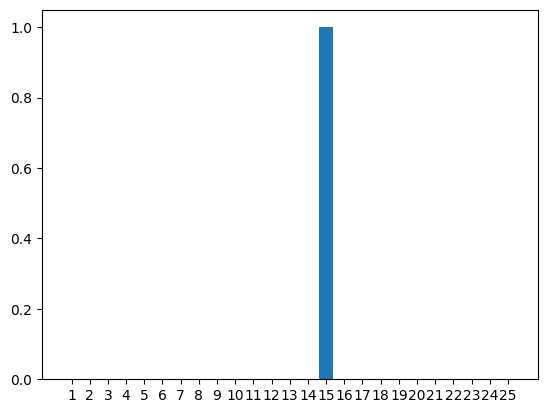

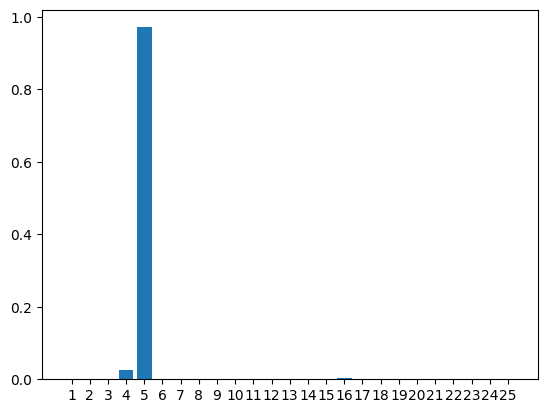

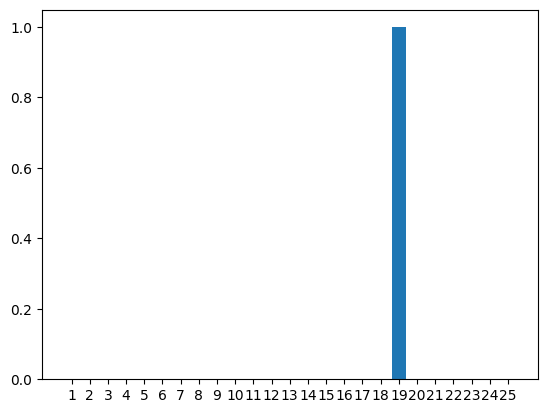

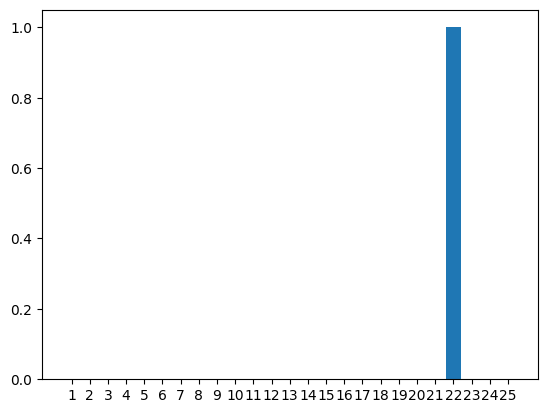

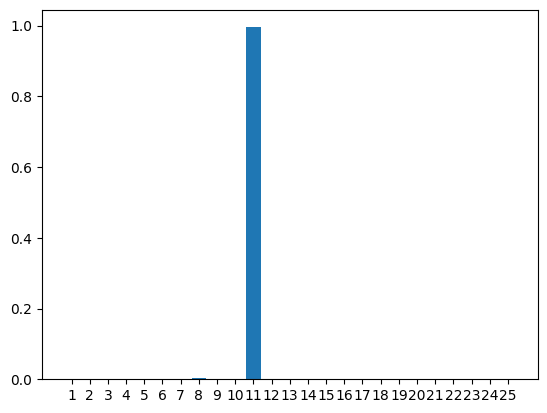

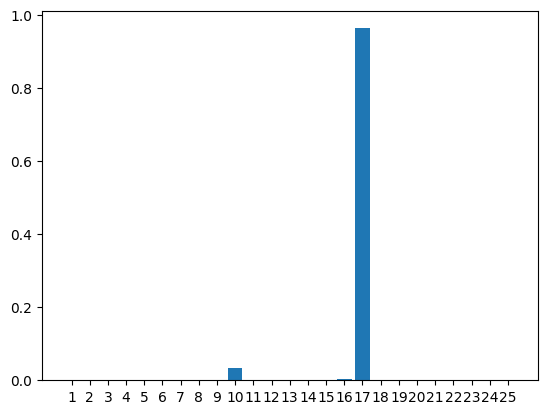

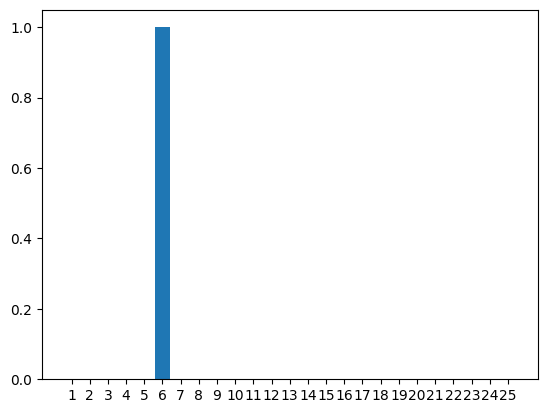

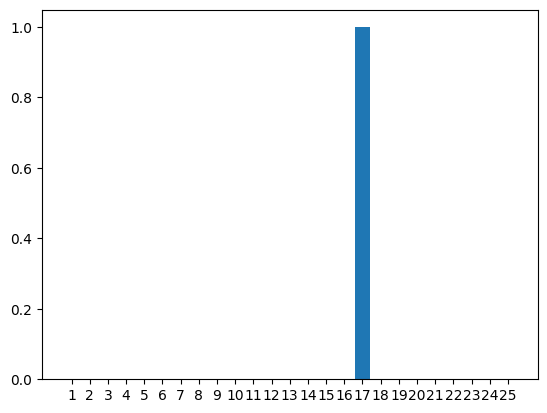

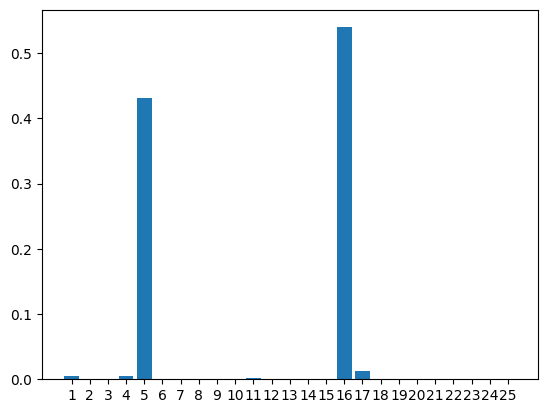

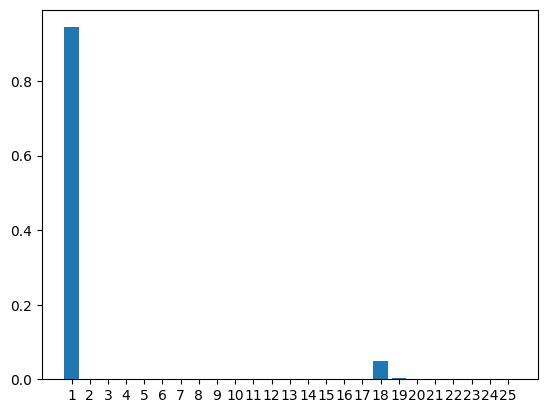

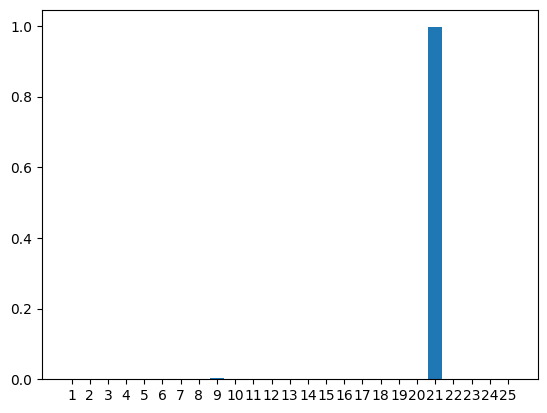

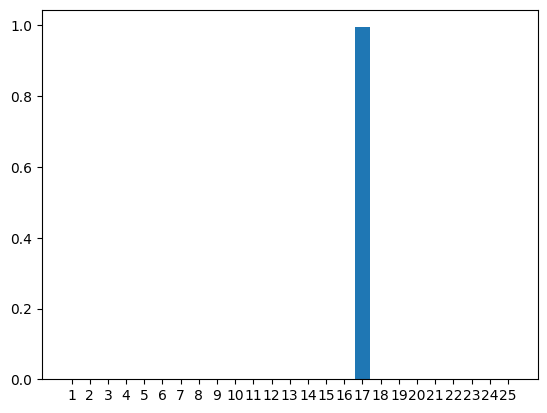

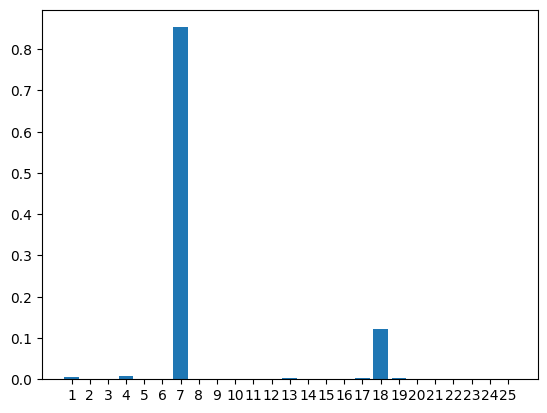

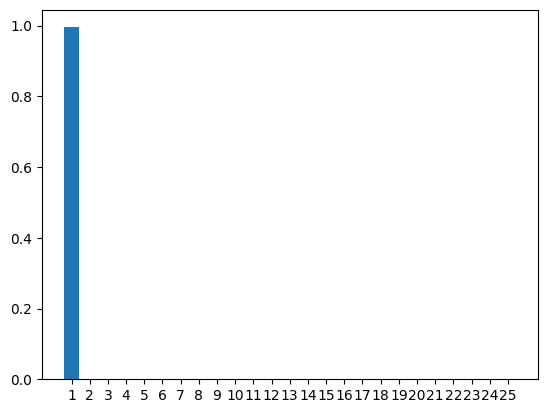

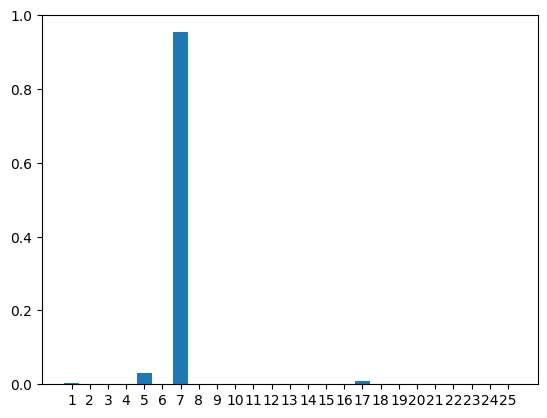

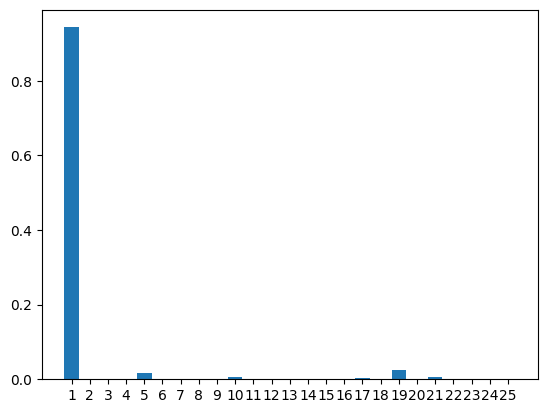

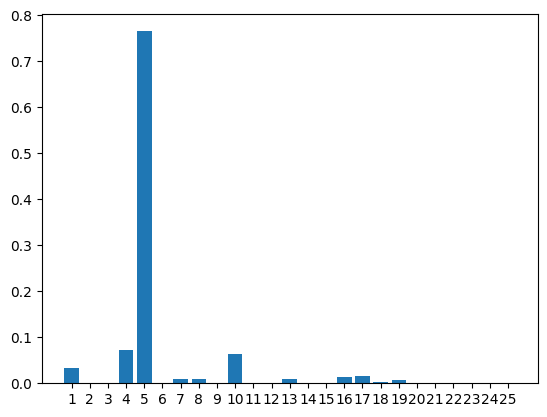

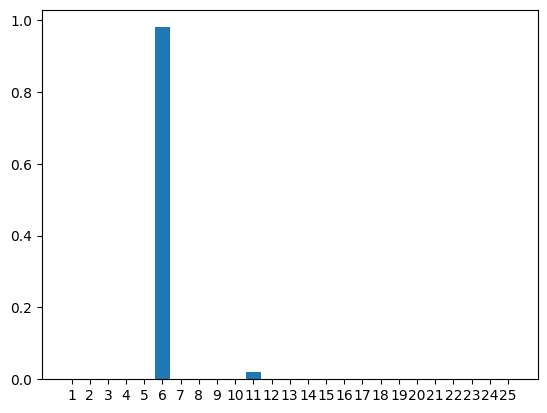

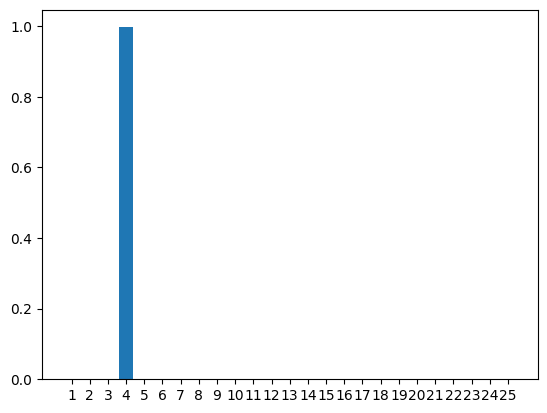

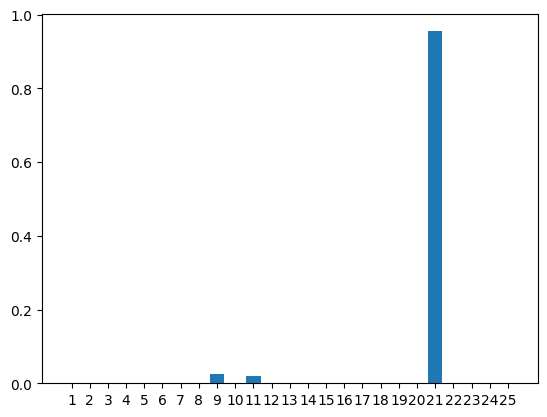

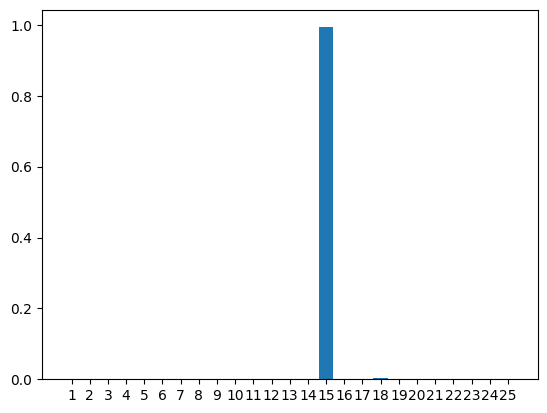

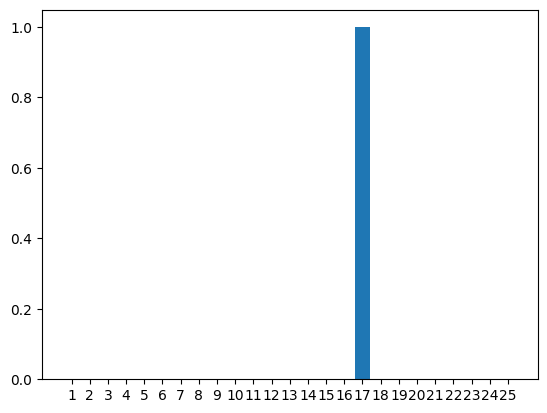

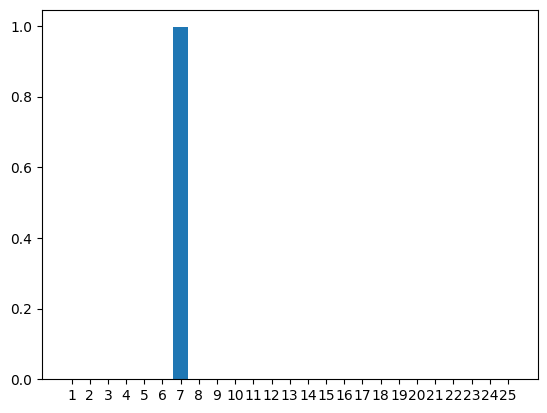

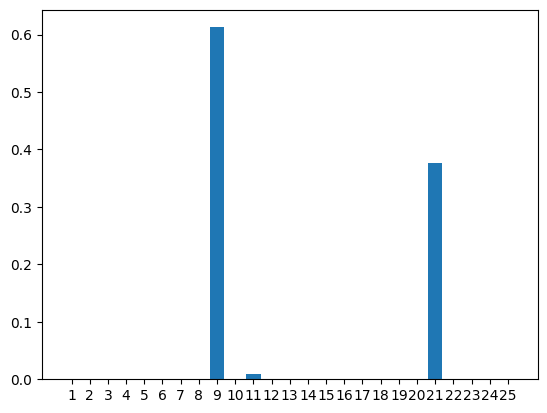

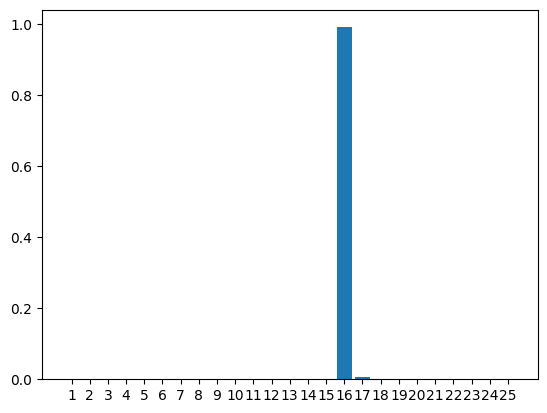

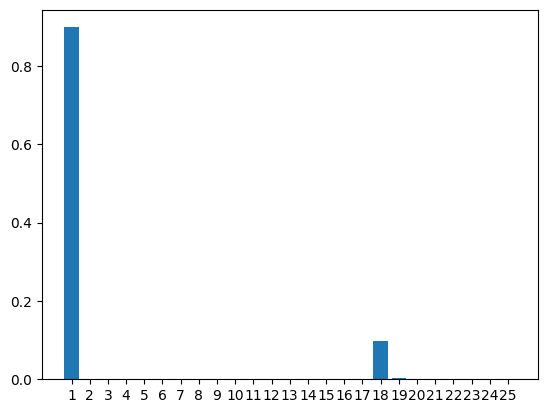

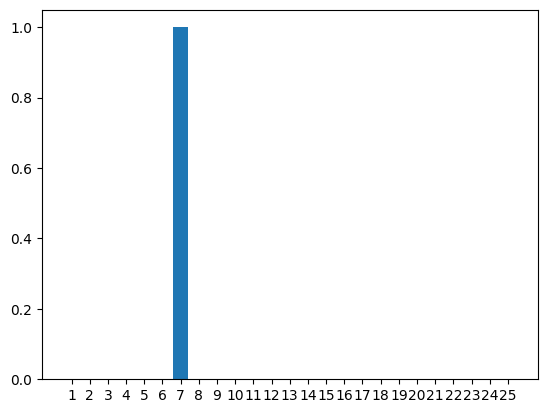

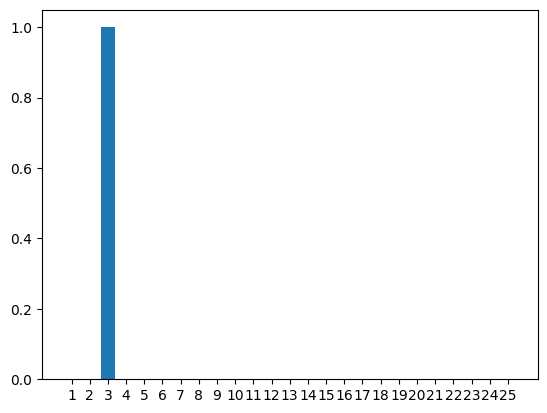

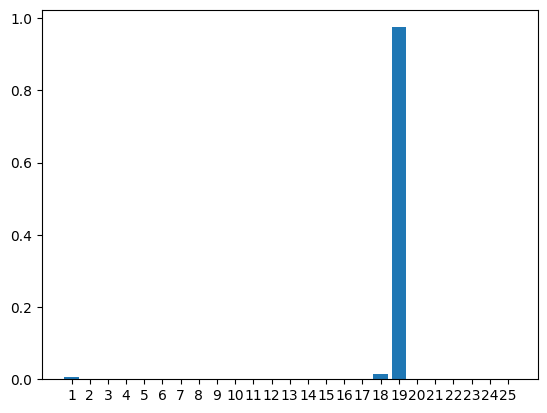

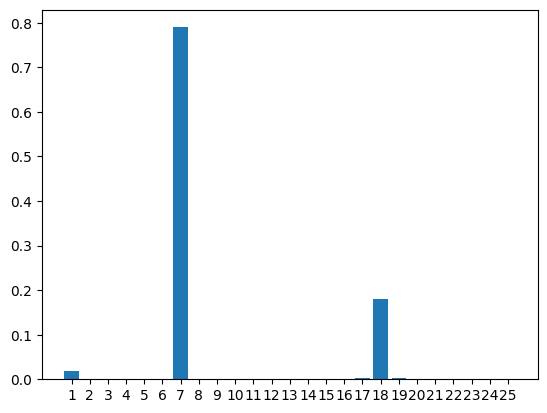

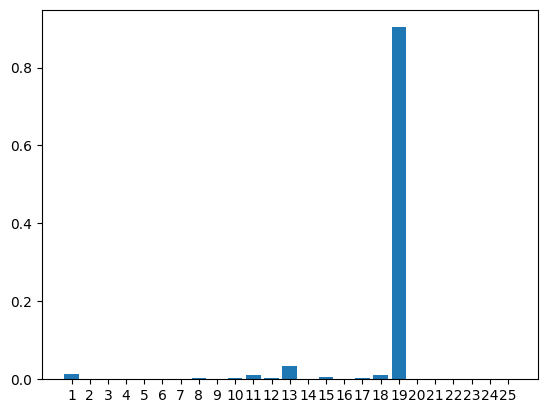

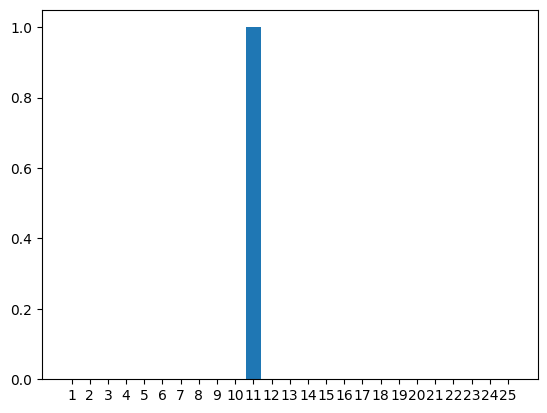

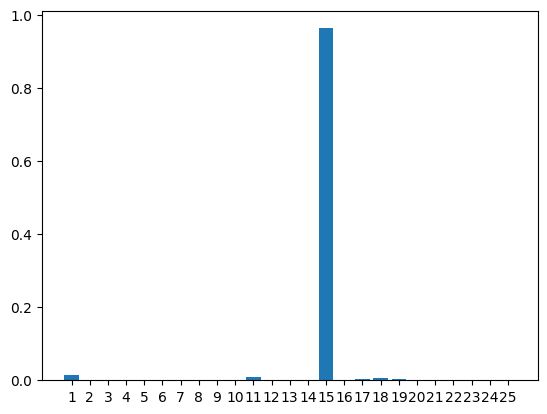

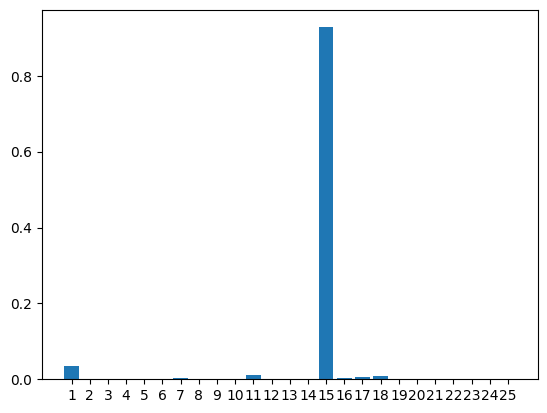

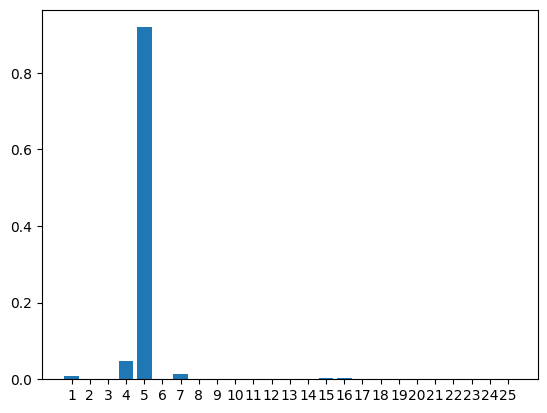

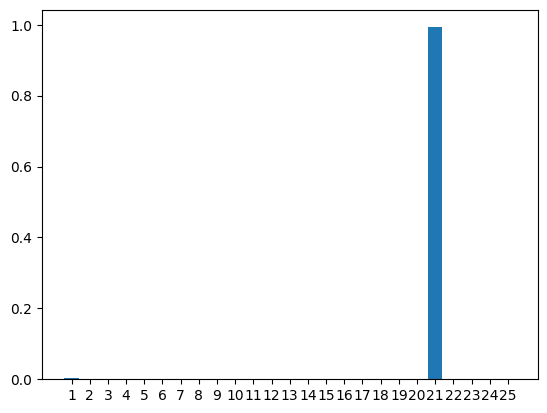

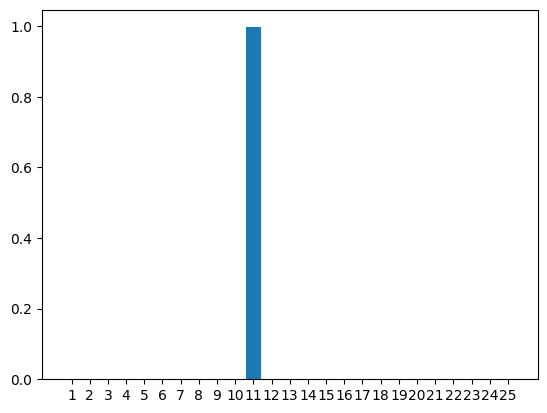

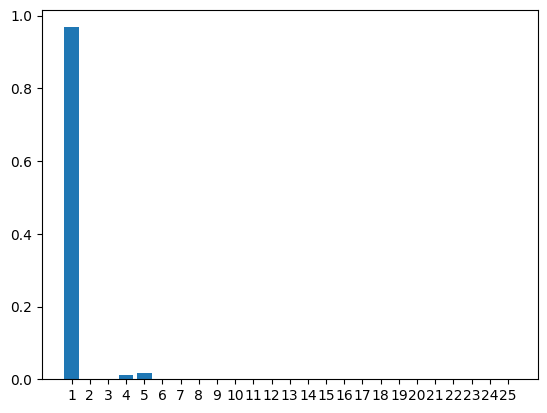

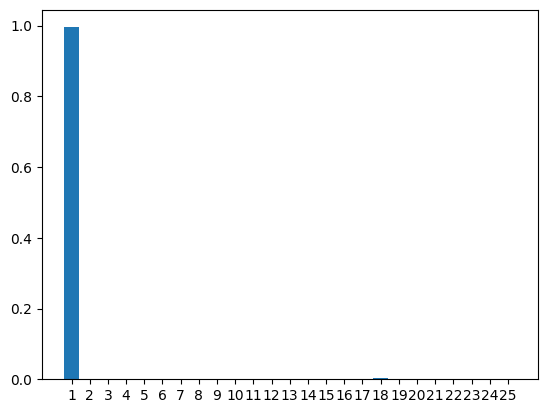

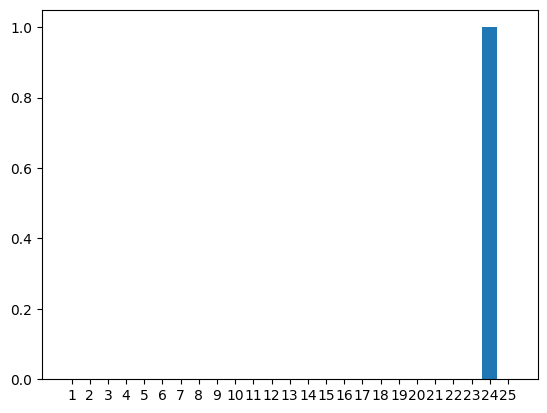

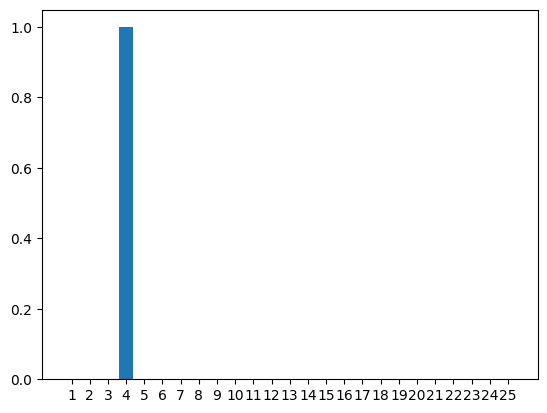

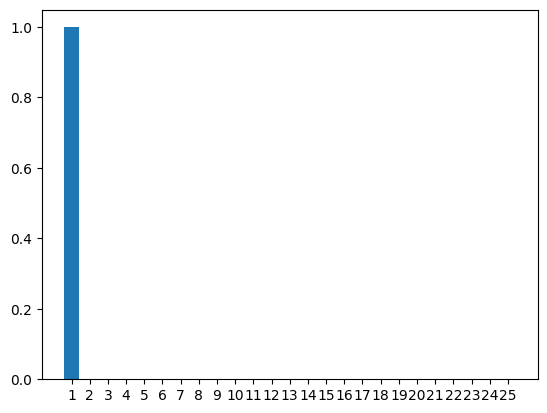

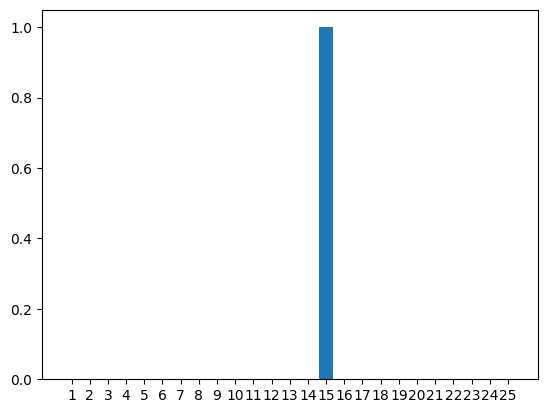

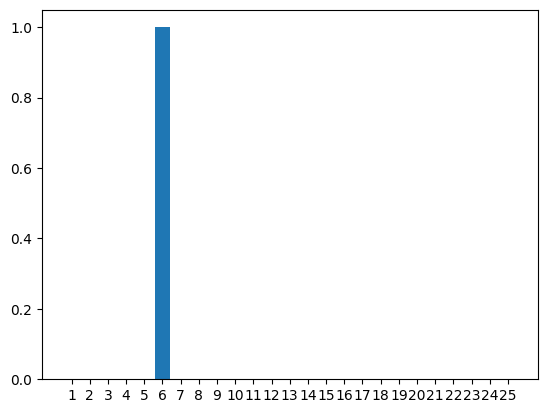

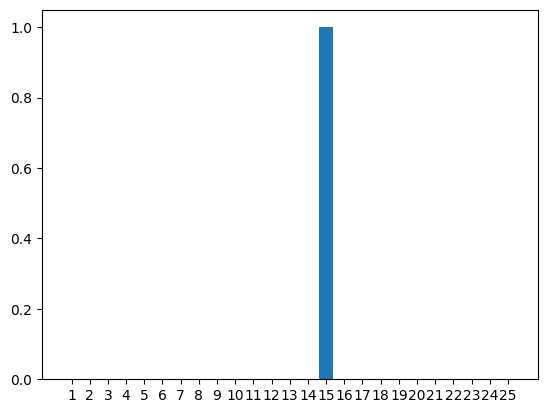

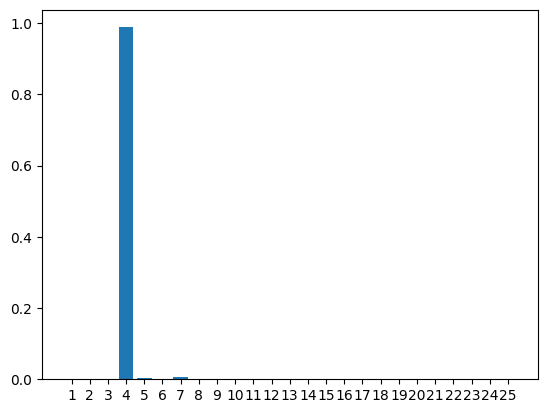

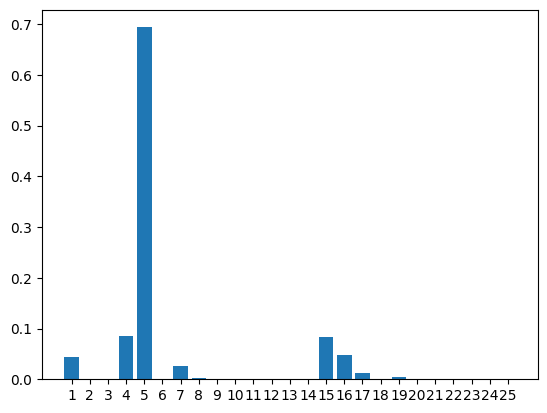

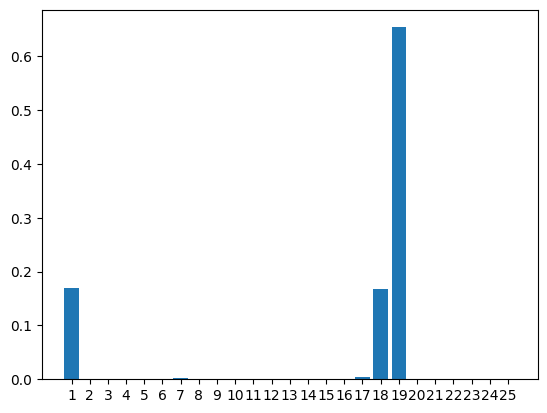

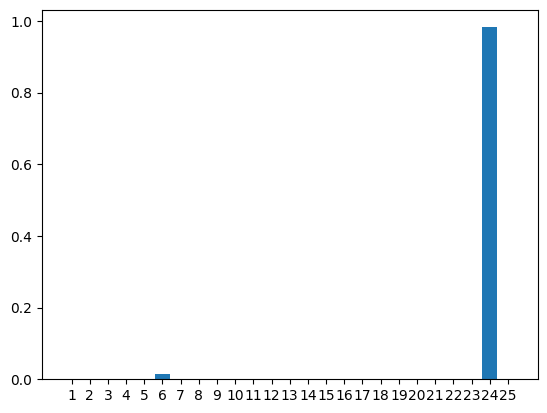

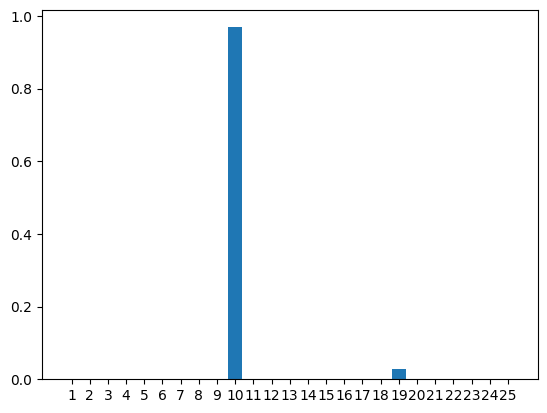

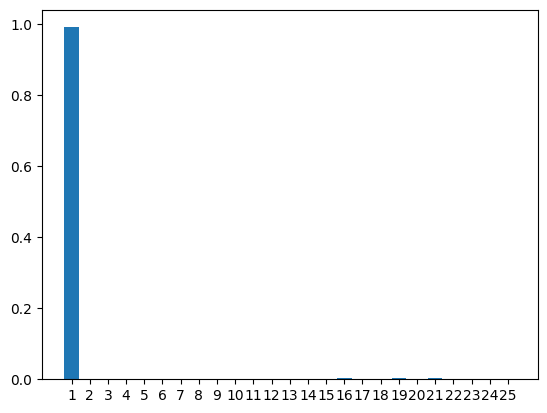

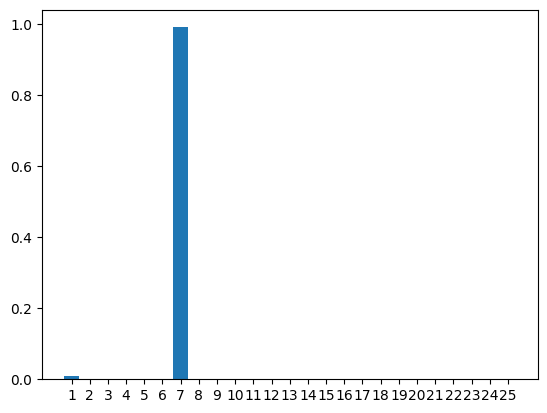

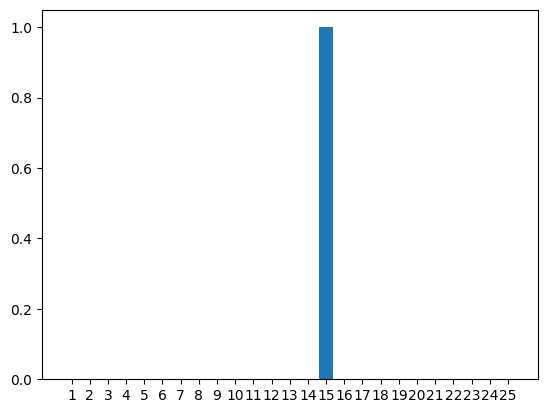

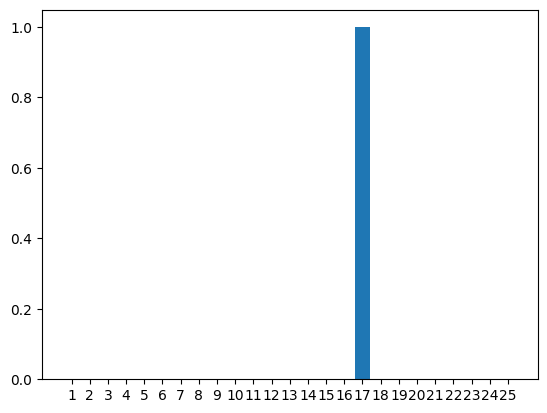

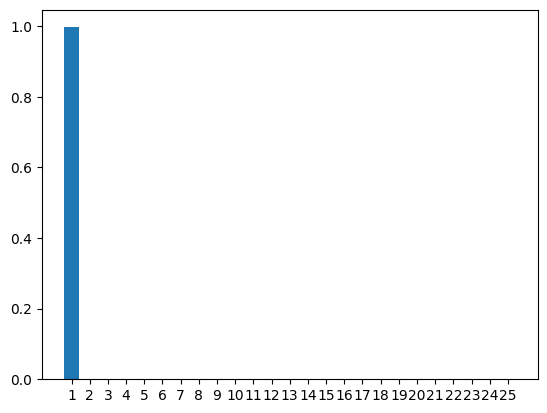

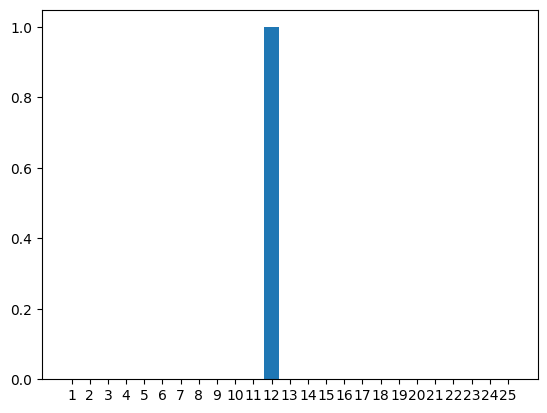

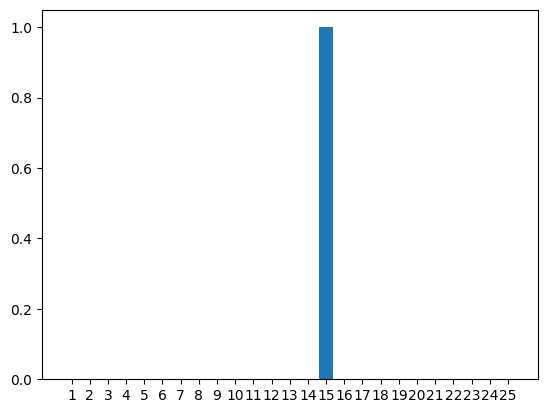

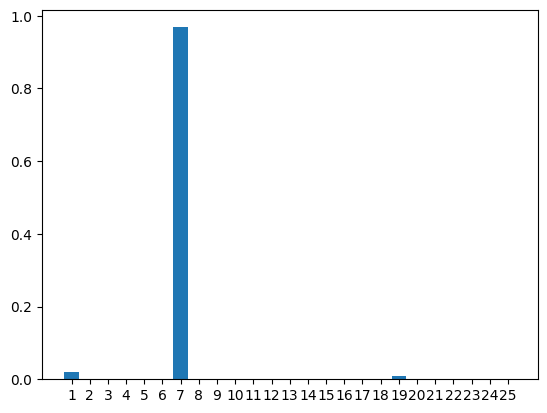

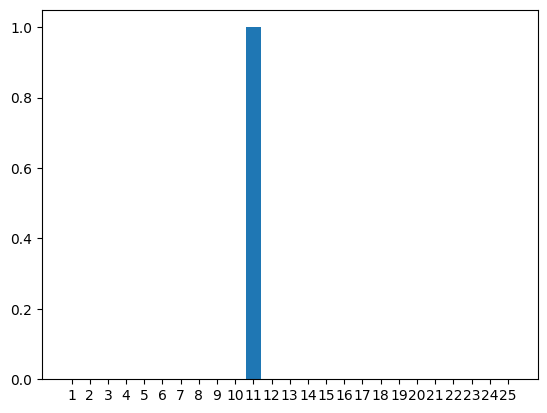

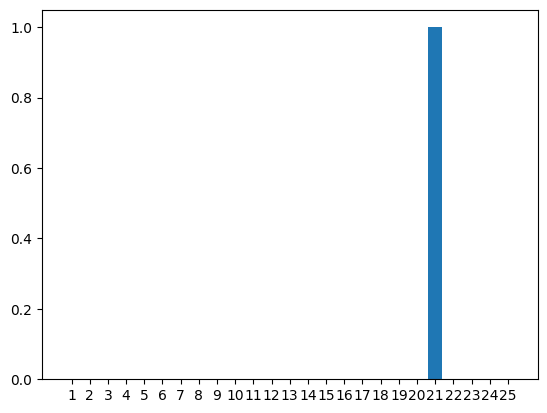

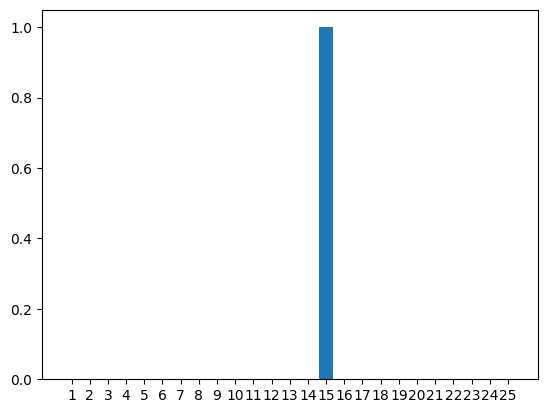

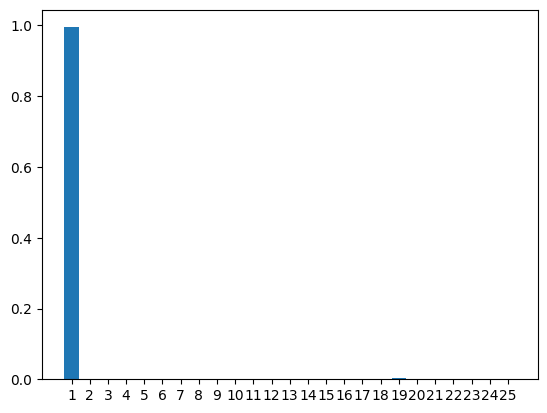

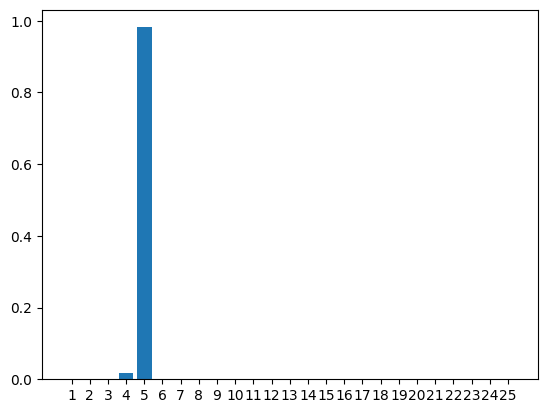

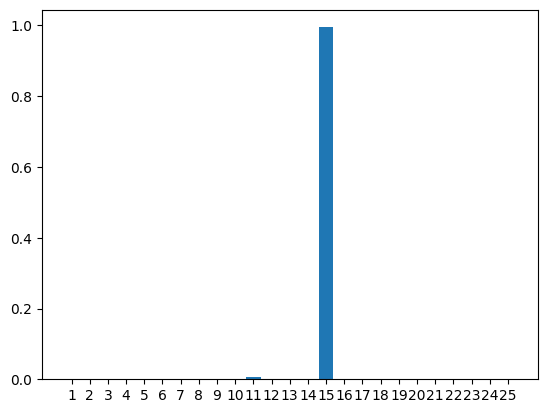

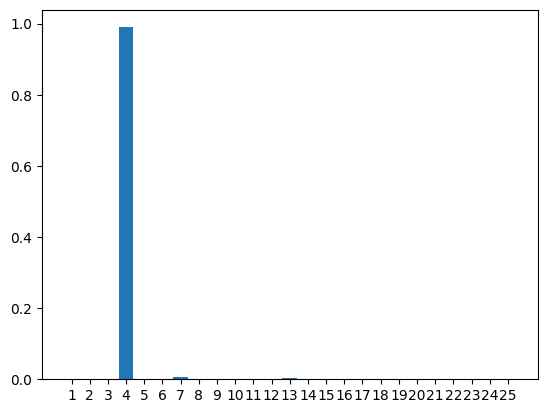

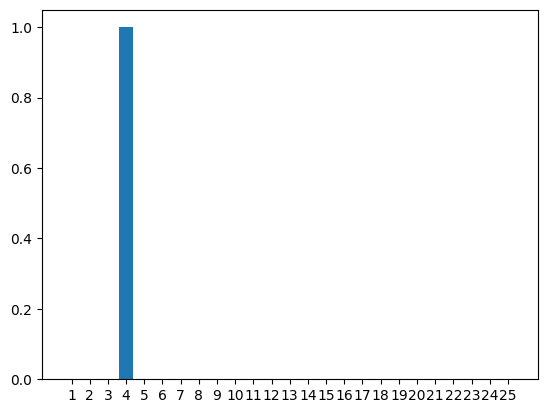

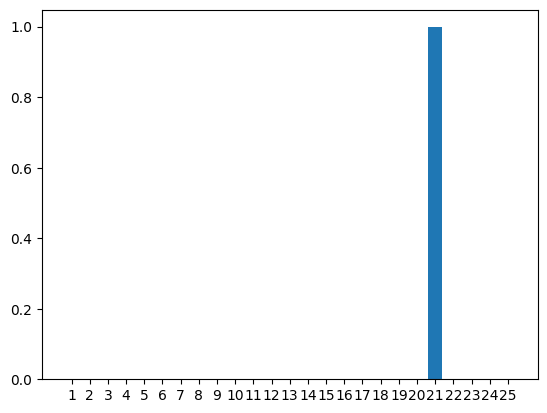

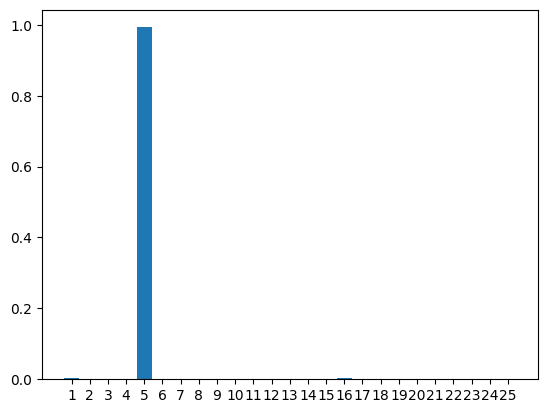

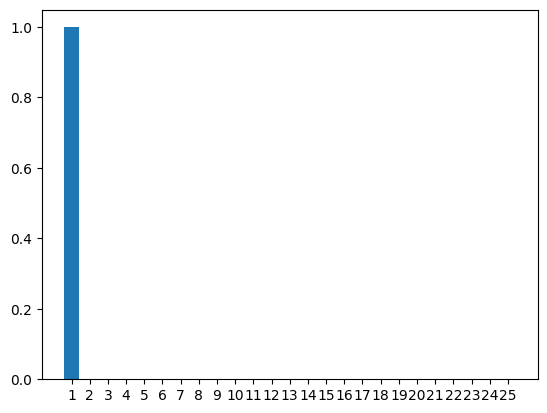

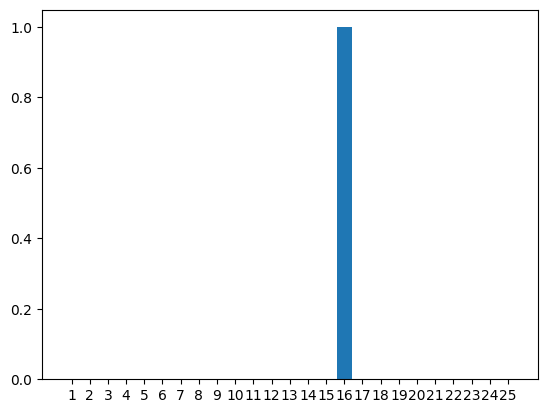

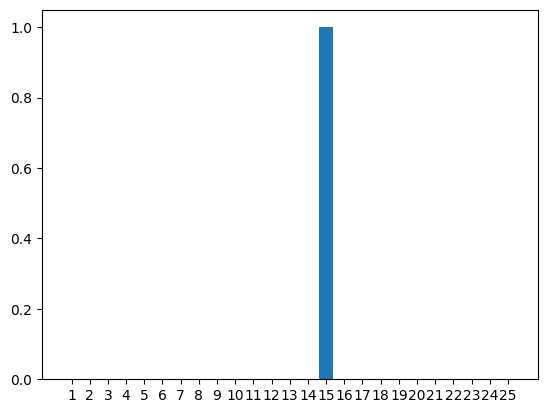

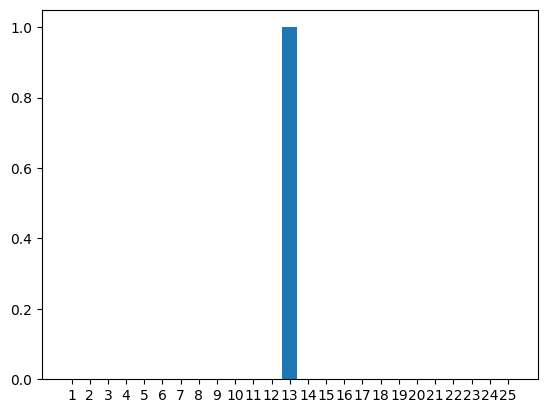

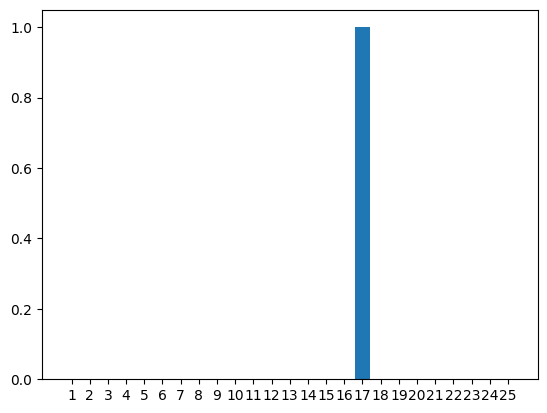

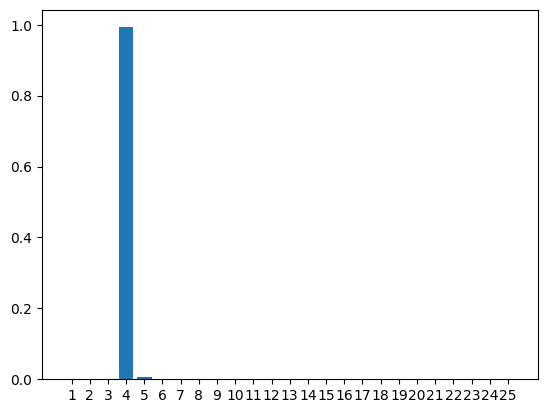

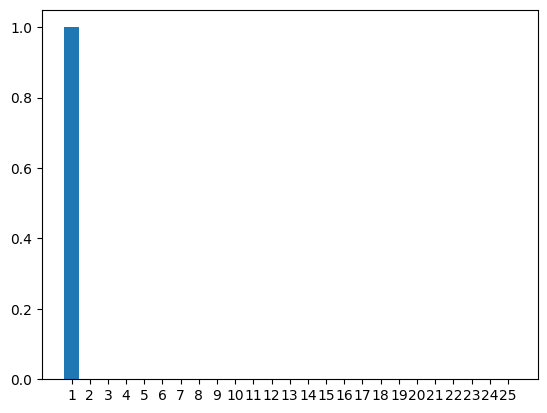

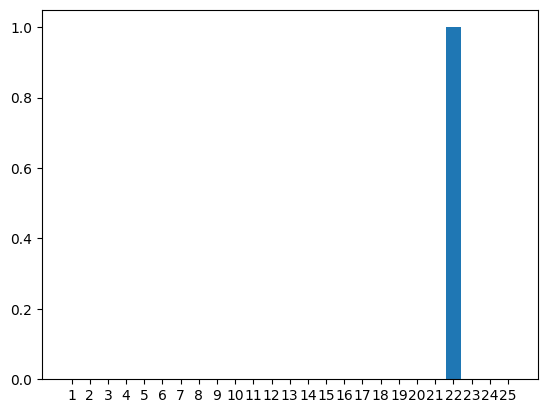

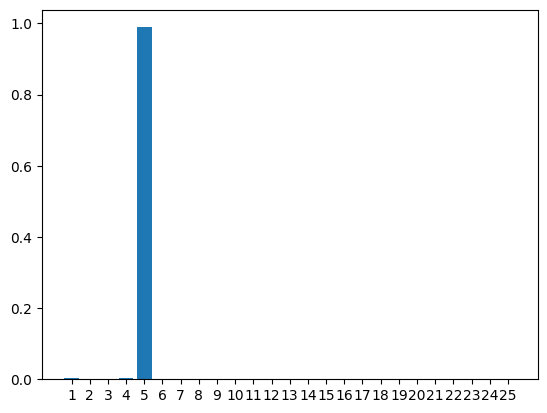

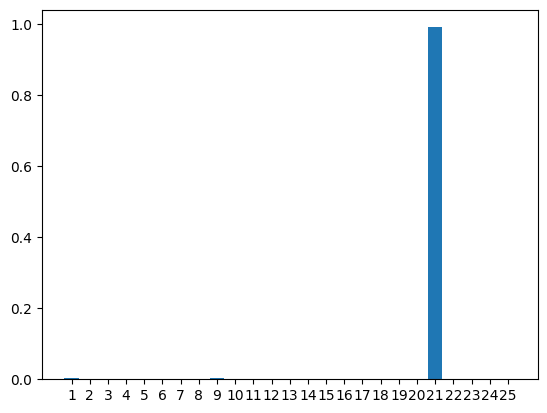

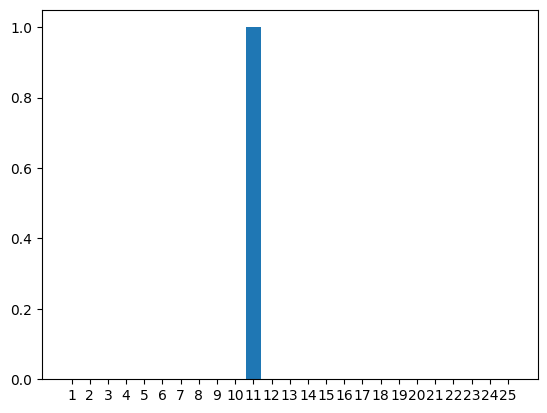

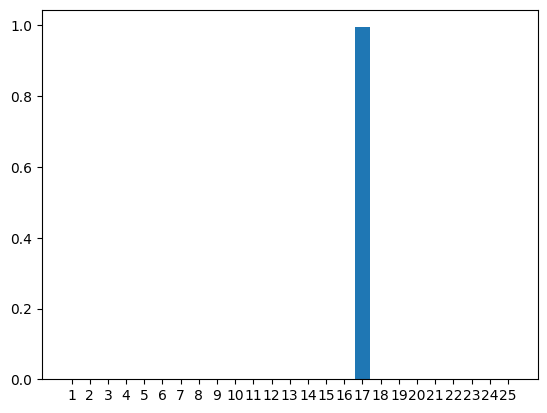

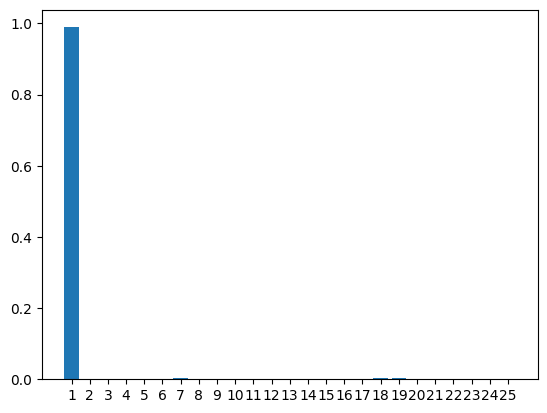

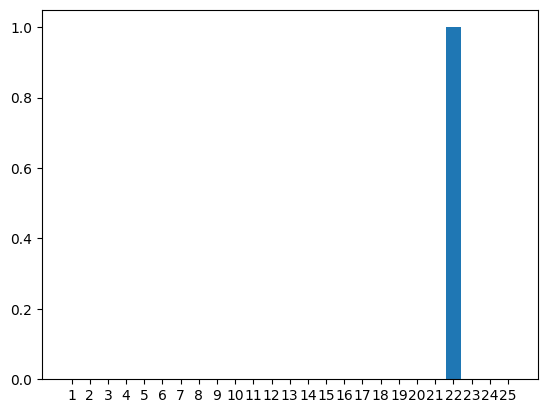

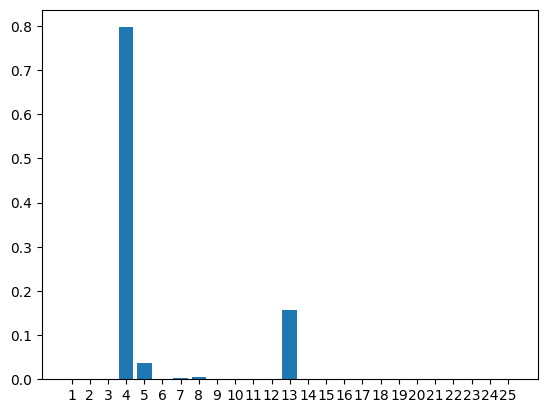

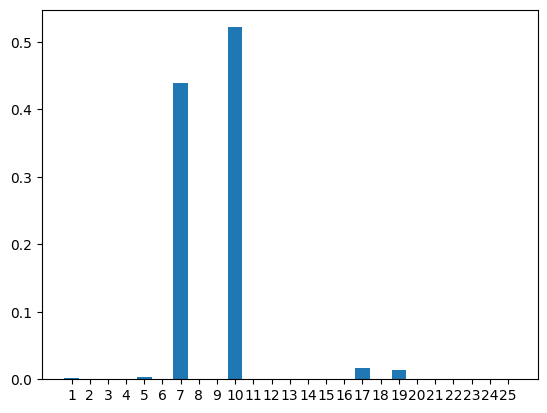

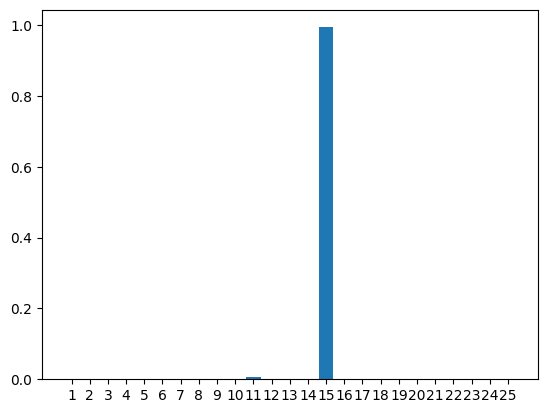

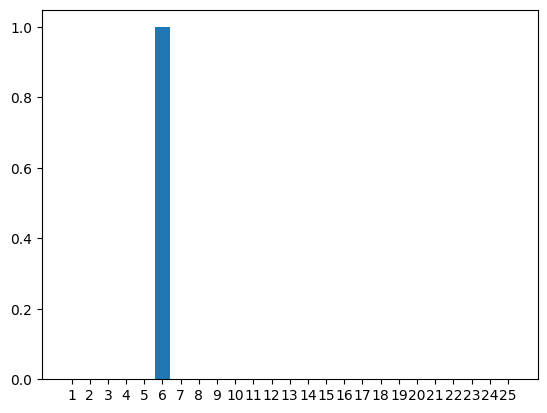

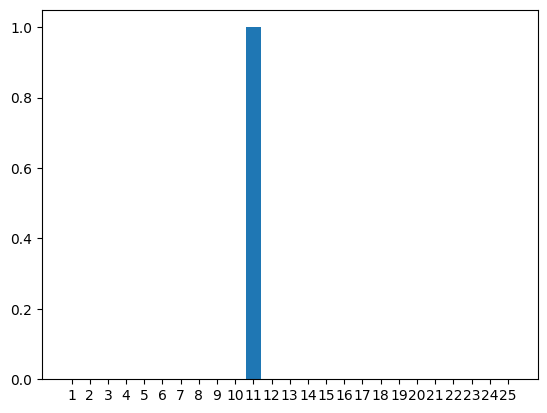

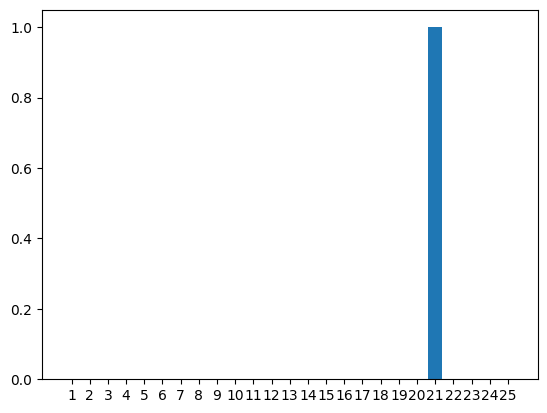

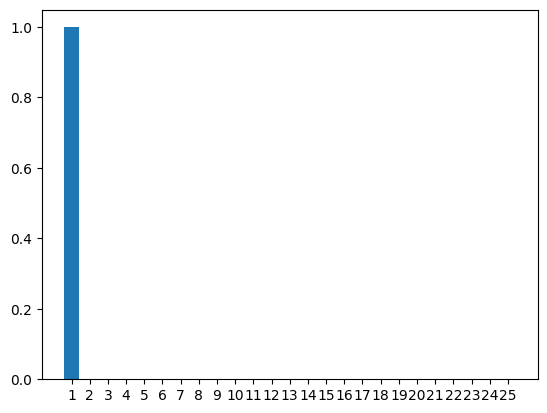

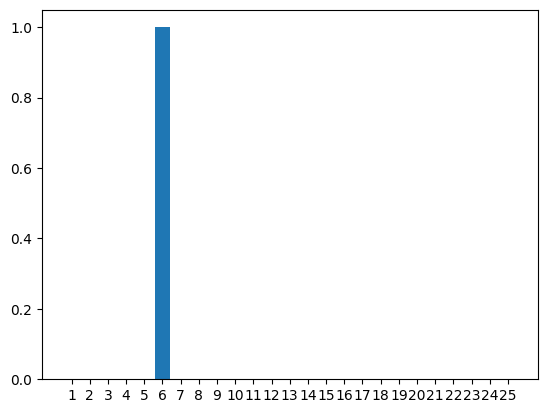

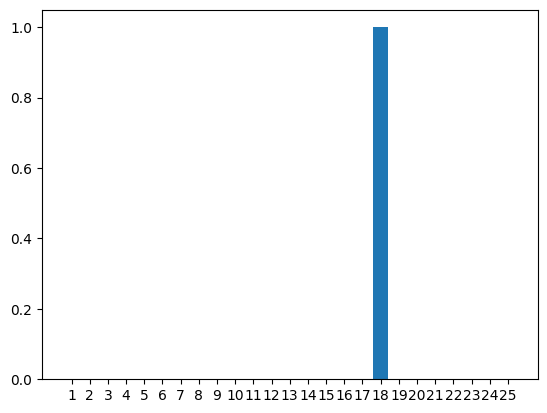

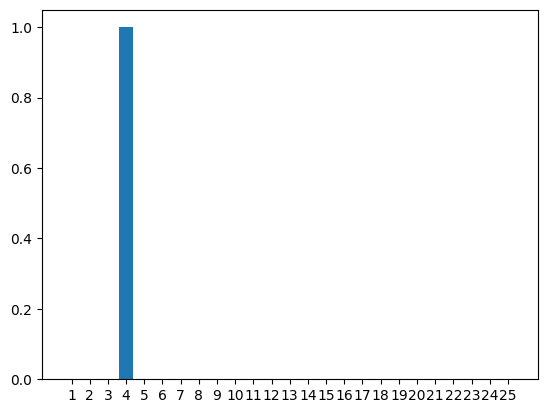

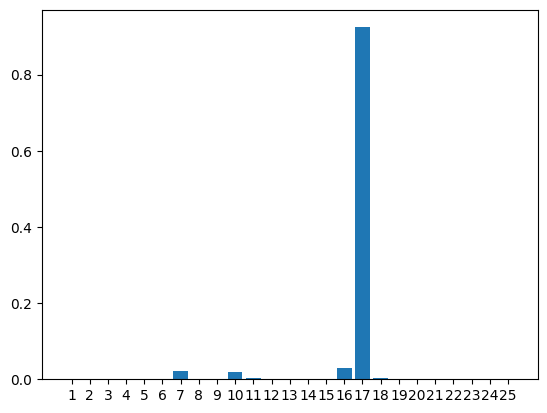

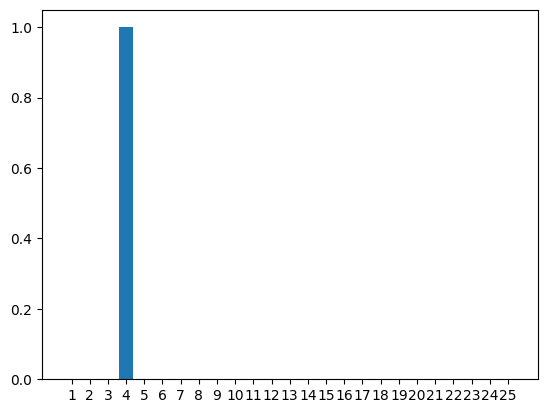

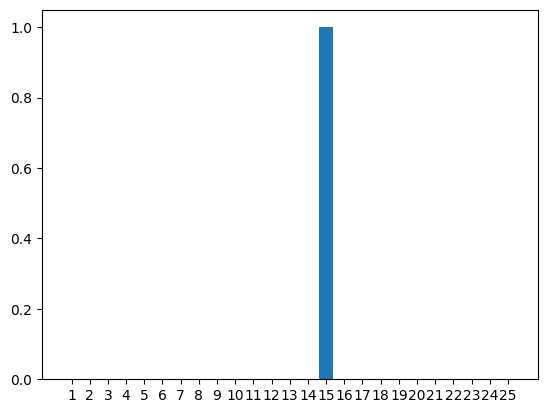

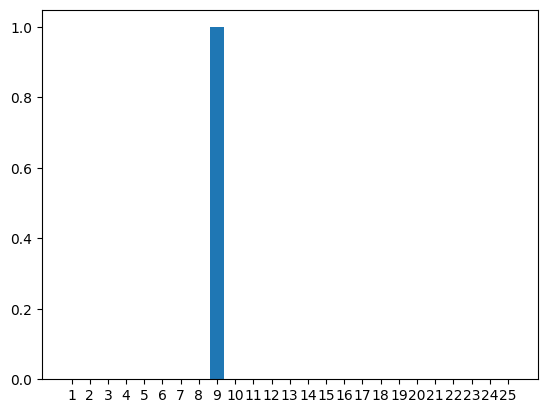

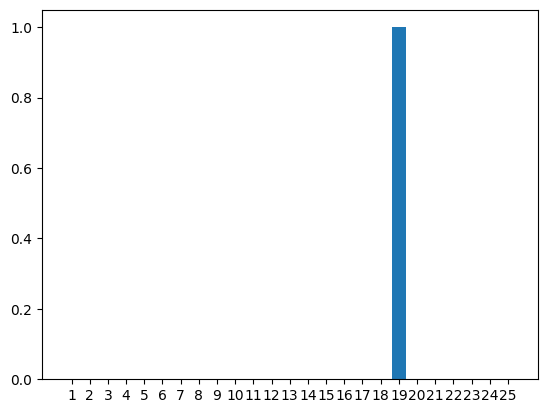

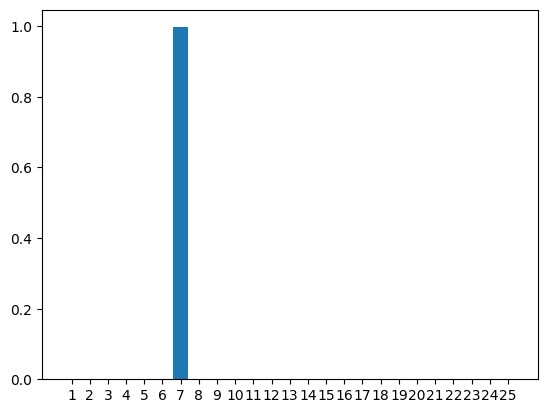

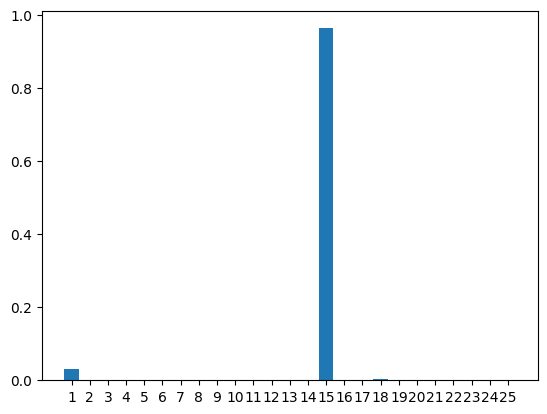

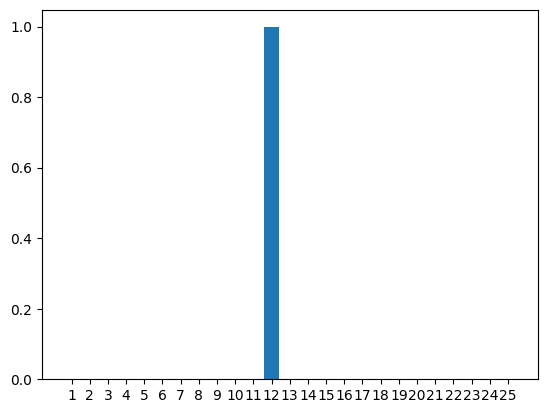

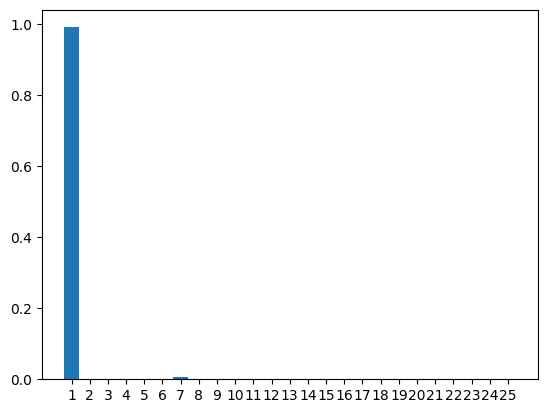

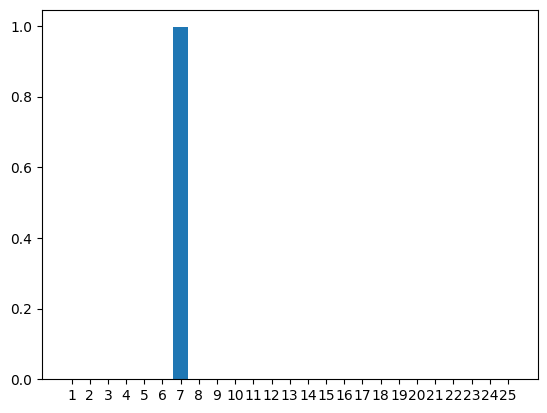

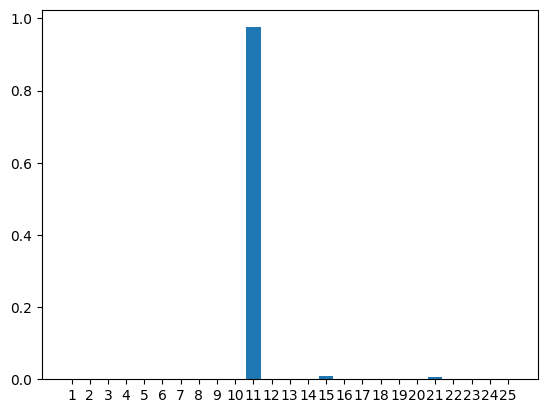

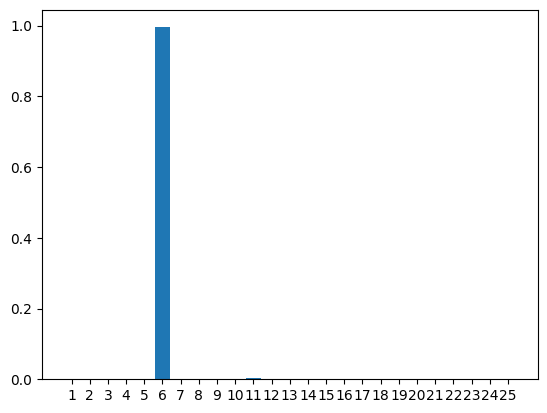

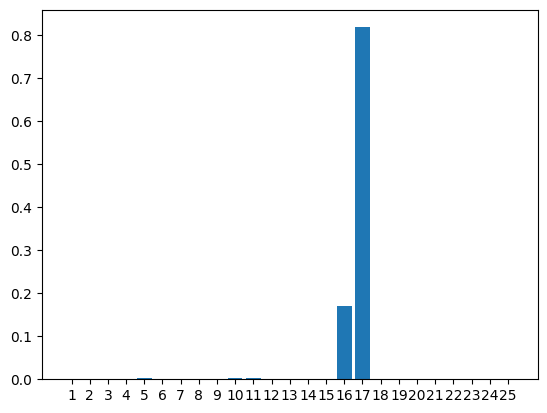

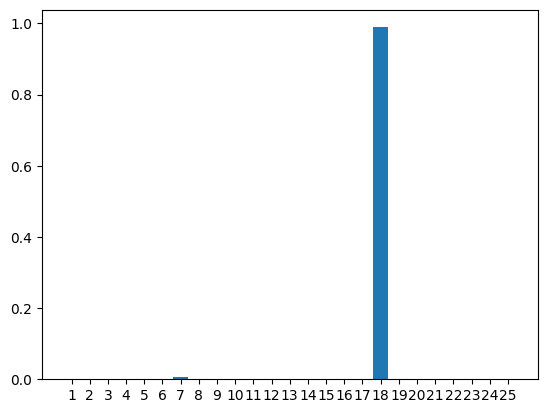

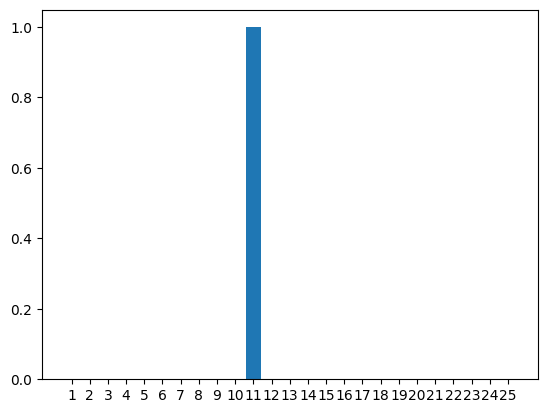

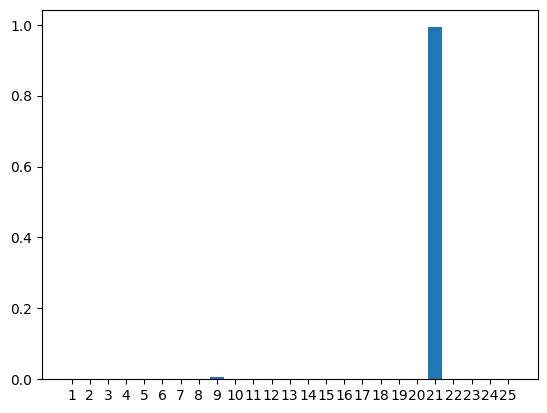

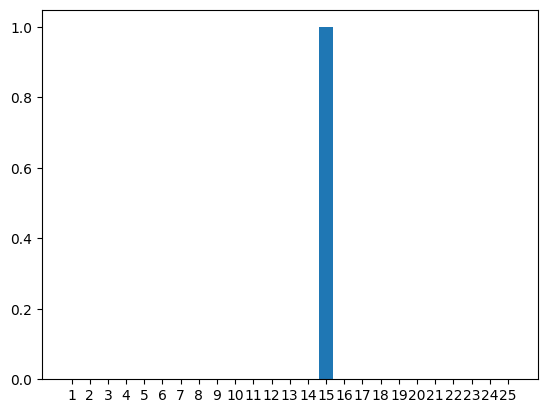

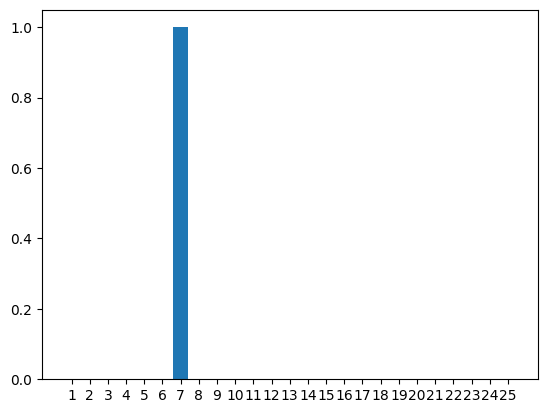

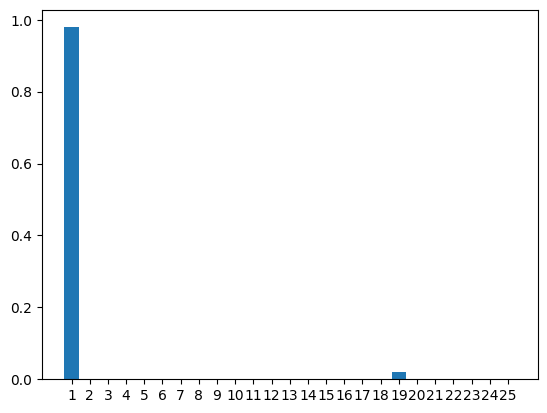

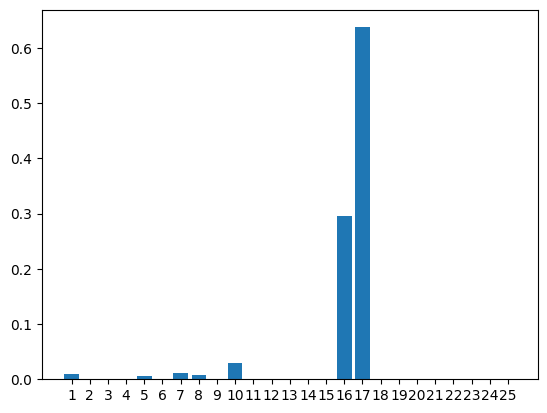

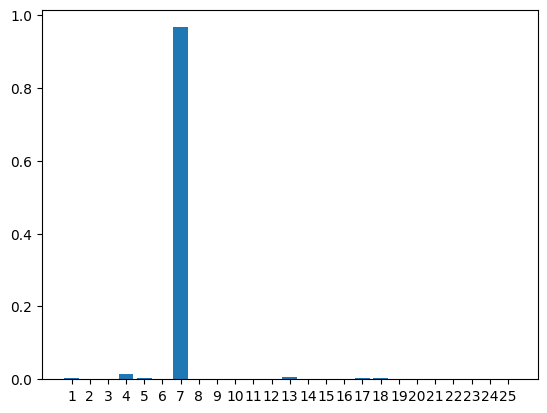

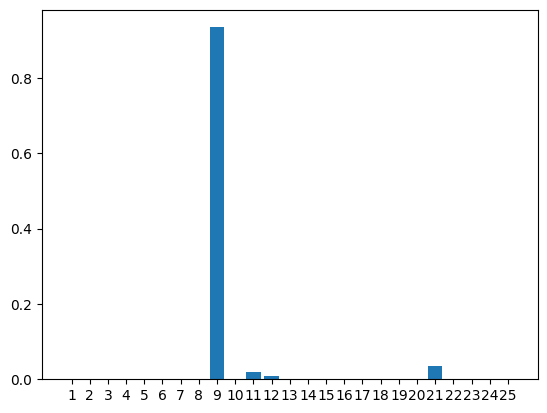

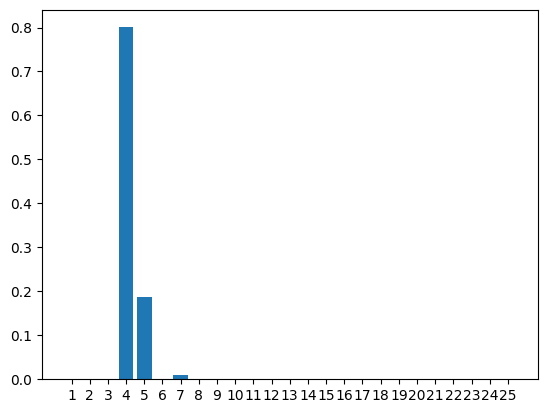

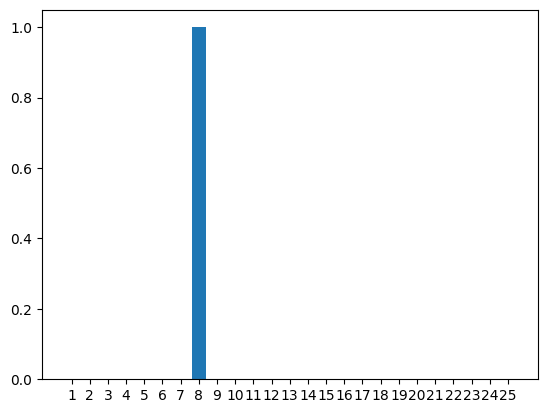

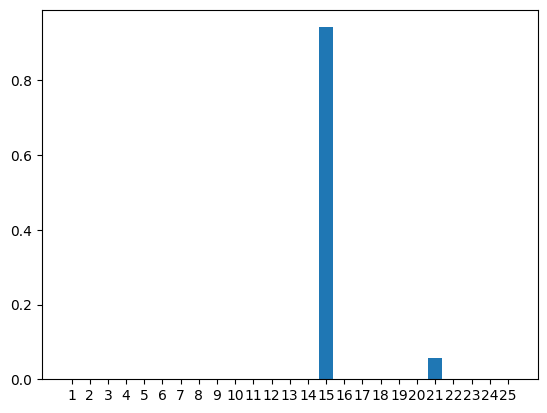

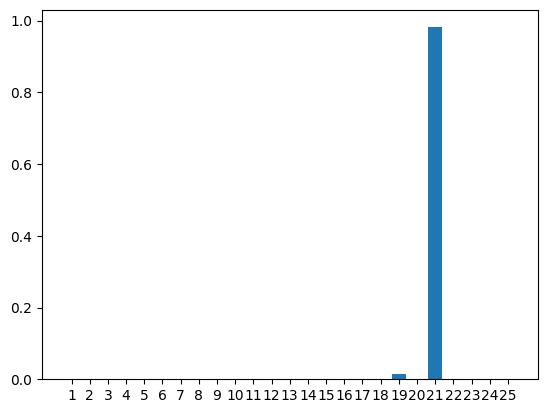

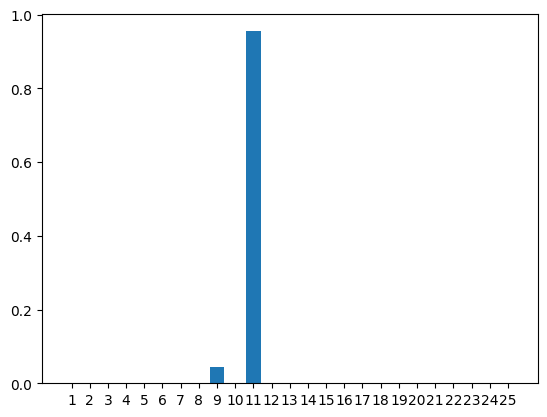

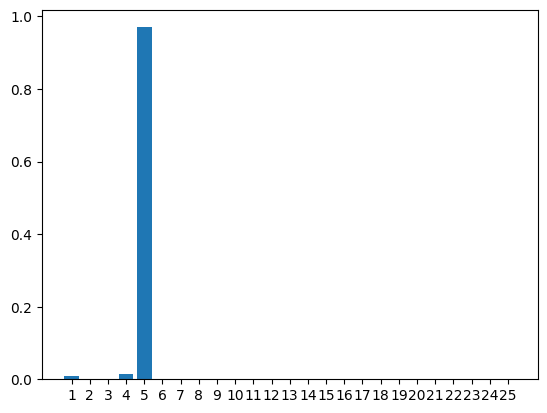

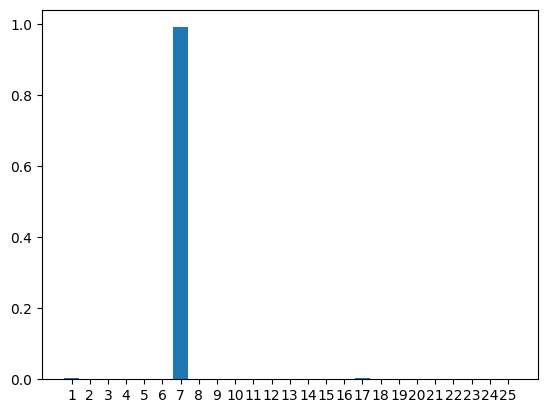

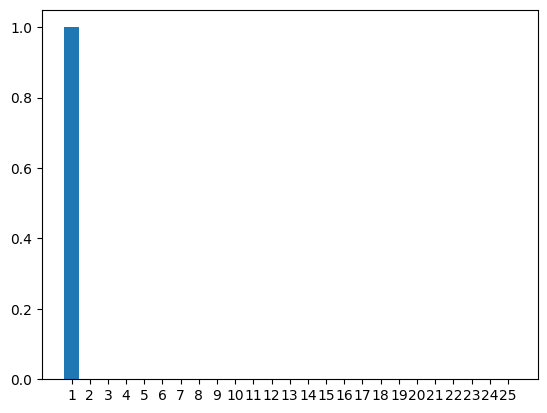

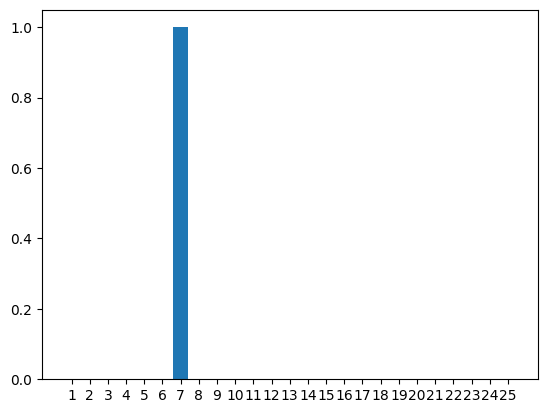

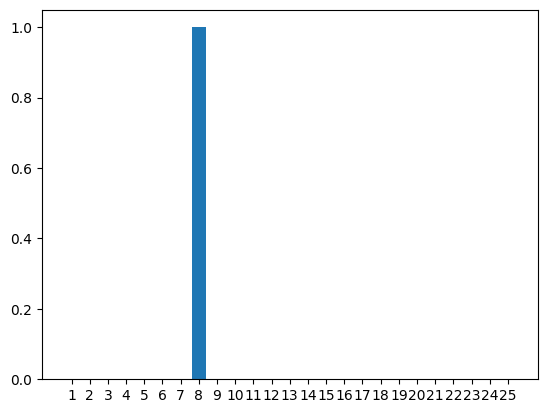

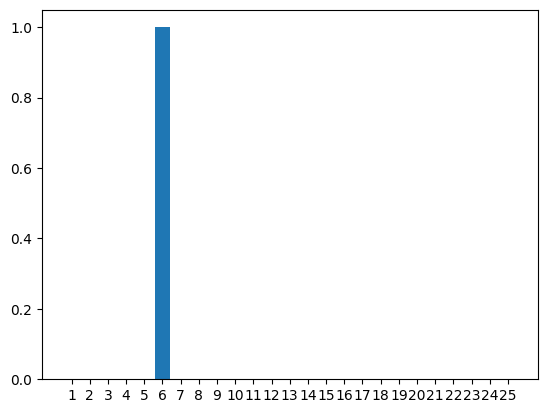

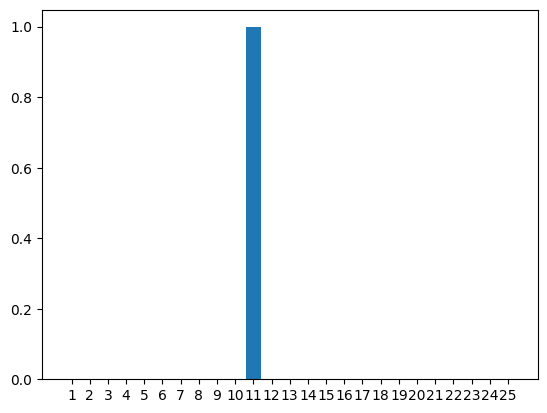

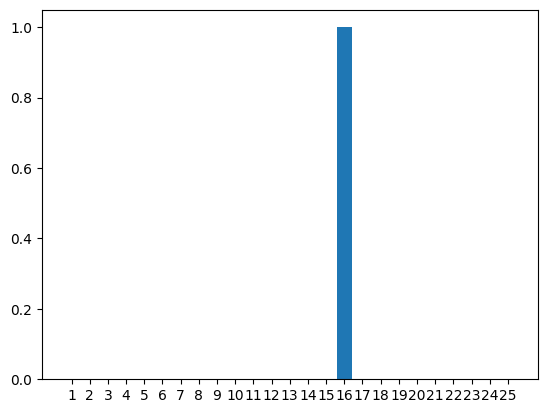

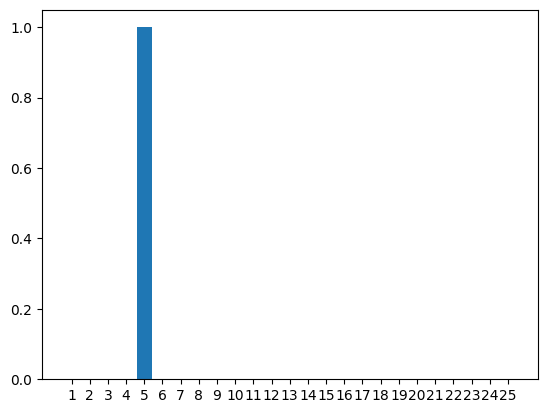

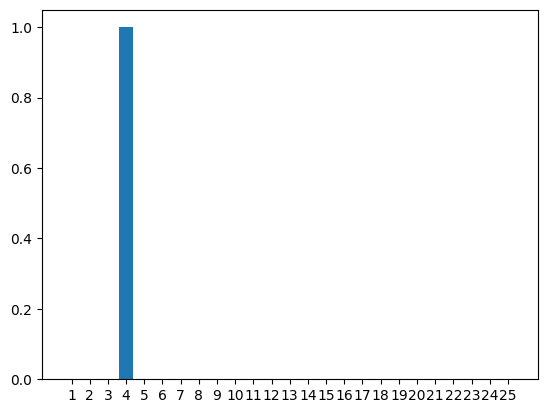

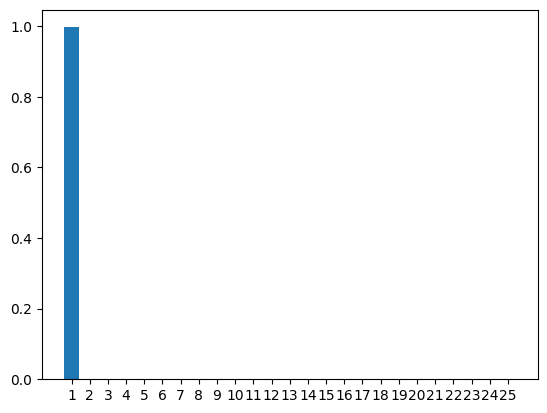

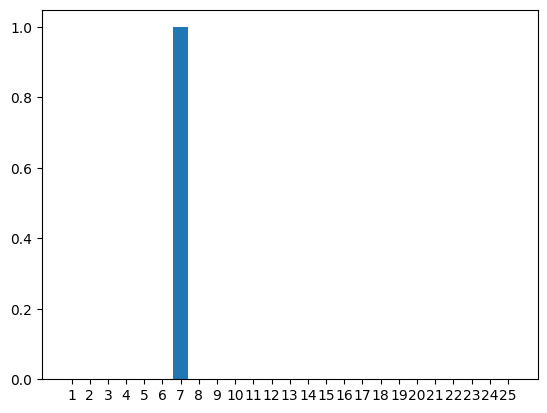

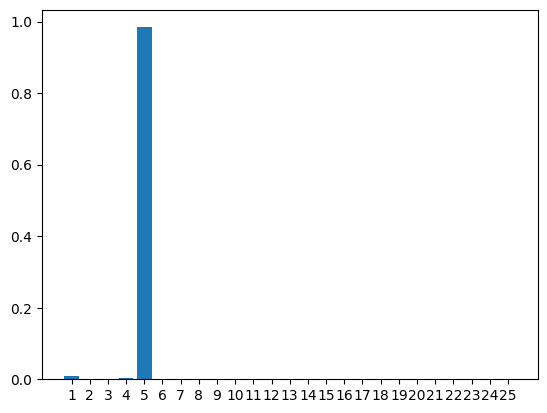

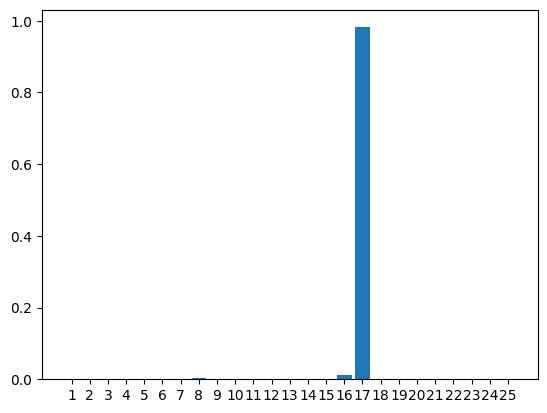

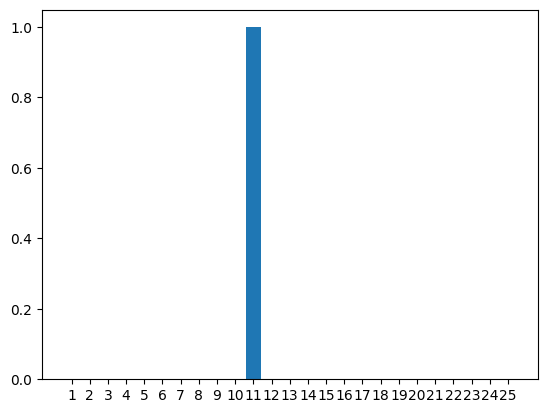

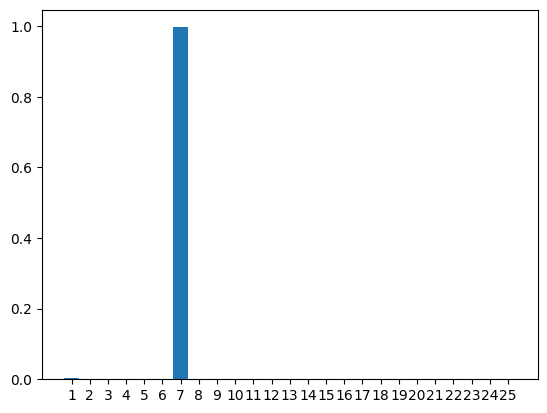

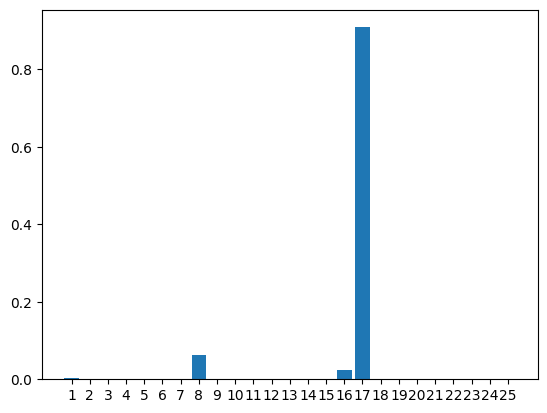

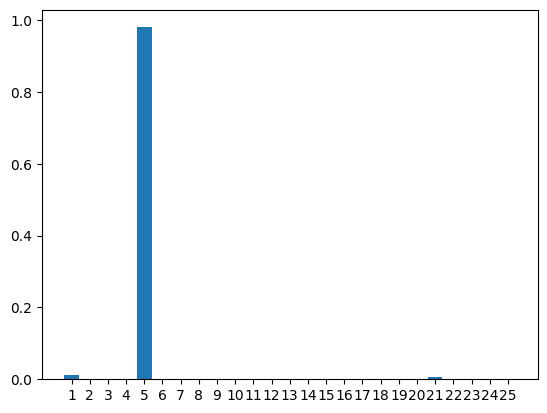

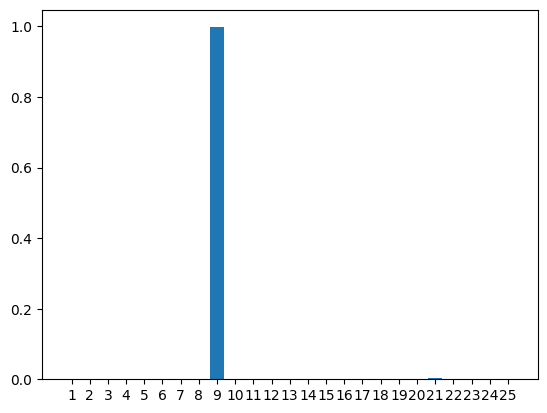

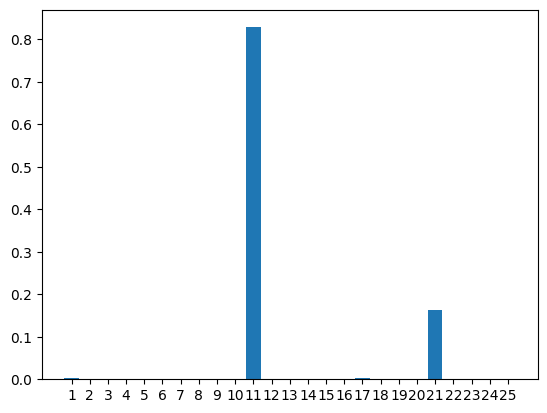

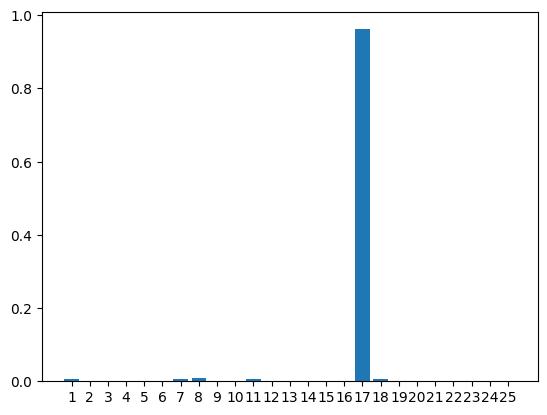

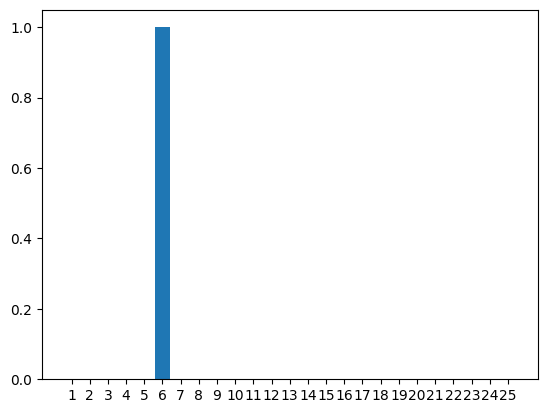

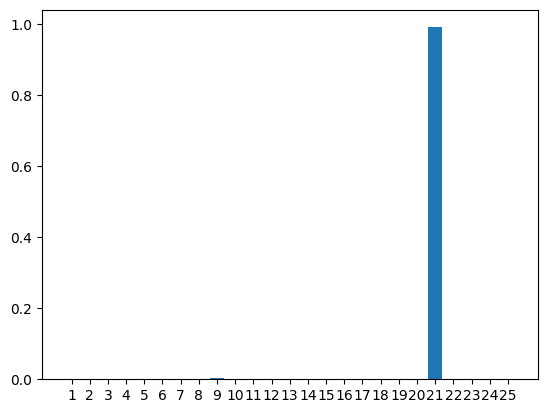

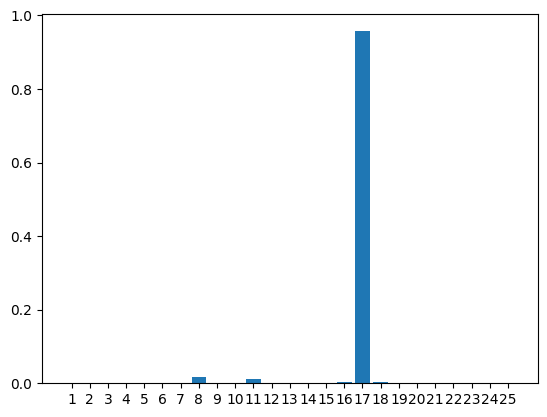

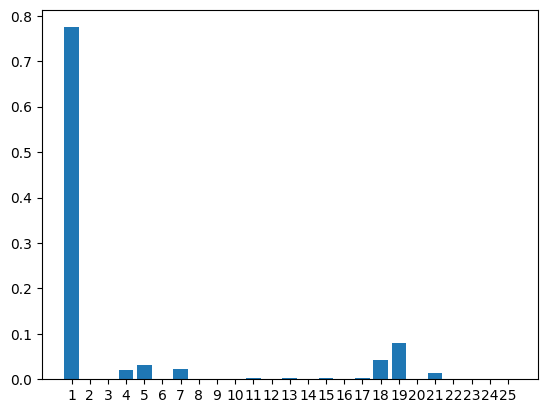

In [66]:
trial[0] = trial[0]
for i in range (trial[0].shape[0]):
    plt.figure(i)
    values = range(1,26)
    plt.bar(values, trial[0][i])
    plt.xticks(values)


(array([[256.,   2.,   1.,   0.,   0.,   0.,   1.,   2.,   3.,  30.],
        [295.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [293.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.],
        [267.,   1.,   0.,   1.,   1.,   1.,   1.,   3.,   2.,  18.],
        [272.,   4.,   1.,   1.,   2.,   1.,   1.,   1.,   0.,  12.],
        [280.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  14.],
        [260.,   0.,   2.,   0.,   2.,   0.,   0.,   1.,   2.,  28.],
        [288.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   6.],
        [285.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   8.],
        [291.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   2.],
        [267.,   0.,   0.,   1.,   0.,   1.,   0.,   1.,   1.,  24.],
        [289.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   5.],
        [291.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.],
        [295.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [265.,   1.,

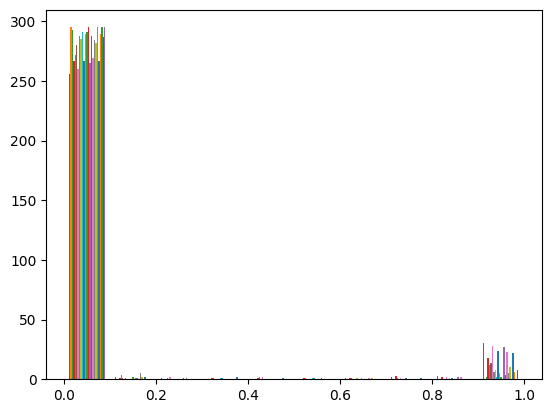

In [37]:
import matplotlib.pyplot as plt
plt.hist(trial[0].cpu().numpy())

In [ ]:
ppls

[1.1093523975226194,
 1.3546412129455534,
 1.4608945242549805,
 1.5811412256202073,
 1.2384789600264823,
 1.2383372060254232,
 1.028340908753786,
 1.0726525713189197,
 1.9246185062504064,
 2.231954203585639,
 6.996385844194631,
 1.2148802356594532,
 1.293335467441674,
 1.9344423284416556,
 1.6934221805775351,
 1.2095888569614586,
 1.7841935144816286,
 1.416304992520914,
 1.238869505591279,
 1.1840506591286943,
 1.0707621638007923,
 1.476590963264118,
 1.0463115101457332,
 1.2822290936059324,
 1.2333852284224465,
 1.2030172364505396,
 1.530120491199975,
 1.3349156421949862,
 1.1651654764717283,
 2.2863006510341934,
 1.584962195894043,
 1.0909245015262052,
 2.367622390836269,
 1.692071824082985,
 1.3961979140914542,
 1.6605085850169092,
 1.5586657999169926,
 1.6301311441325959,
 1.3171209436192577,
 1.0606854945717297,
 1.208579660499097,
 1.409139212350207,
 1.1394970933947746,
 1.9933609663751068,
 1.3331917138159546,
 1.1497126891480314,
 1.1767613852671868,
 1.2484036744423408,
 1.49

In [80]:
range_limits = [x for x in range(0, 400, 50)]
counts = {r: 0 for r in range_limits}
hacc_totals = counts.copy()
counts_ppl = [counts.copy() for _ in range(full_output.shape[0])]
ppl_totals = [counts.copy() for _ in range(full_output.shape[0])]

hard_accs = []
ppls = []

for sample_i in range(full_output.shape[0]): # each sample in batch
    if begAAindex[sample_i] == 0:
        y_pred = full_output[sample_i][:-1]
        y_actual = input_tensor[sample_i][1:] - vocab_len + 26
    else: # if there is a keyword
        y_pred = full_output[sample_i][begAAindex[sample_i]-1:padIndex[sample_i]-1]
        y_actual = input_tensor[sample_i][begAAindex[sample_i]:padIndex[sample_i]]  - vocab_len + 26

    total_correct = 0
    total_ent = 0
    y_pred = F.softmax(y_pred, dim=1)

    # calculate perplexity
    for ii in range(0,y_pred.shape[0]): # each token in available tokens

        # Determine the current range based on ii
        current_range = max([r for r in range_limits if ii >= r])
        ent = torch.log(y_pred[ii][y_actual[ii]]).item()
        total_ent+=ent
        ppl_totals[sample_i][current_range] += ent
        counts_ppl[sample_i][current_range] += 1

        hacc_totals[current_range] += (y_pred[ii].argmax() == y_actual[ii]).item()
        total_correct += (y_pred[ii].argmax() == y_actual[ii]).item()
        counts[current_range] += 1
        


    ppl = np.exp(-total_ent/y_pred.shape[0])
    ppls.append(ppl)

    hard_accs.append(total_correct / len(y_pred))


In [83]:
ppl_totals

[{0: -13.588241403961575,
  50: -2.5654858051531733,
  100: -1.6074247866698101,
  150: -7.929309291677782,
  200: -2.994349587301258,
  250: -1.9292328511780852,
  300: 0,
  350: 0},
 {0: -21.53927395360438,
  50: -9.17839100119727,
  100: -14.335151423397292,
  150: -13.320261253182252,
  200: -16.46291994551393,
  250: -15.921455323892587,
  300: 0,
  350: 0},
 {0: -20.01067261358395,
  50: -16.153516157087267,
  100: -19.95792290670215,
  150: -17.282146243494935,
  200: -20.485591207116613,
  250: -16.034342297385592,
  300: 0,
  350: 0},
 {0: -25.76557323321788,
  50: -8.616889239664829,
  100: -25.18657287791575,
  150: -13.44771583185684,
  200: -21.733177970589622,
  250: -38.11266633847663,
  300: 0,
  350: 0},
 {0: -34.06364948872215,
  50: -2.9605477357908967,
  100: -1.3881420096940928,
  150: -2.653385219949996,
  200: 0,
  250: 0,
  300: 0,
  350: 0},
 {0: -14.0771277533687,
  50: -7.176728350648773,
  100: -9.79617637062438,
  150: -12.179633786189925,
  200: -6.1510921

In [64]:
ppls_range = counts.copy()
counter = counts.copy()
for i in range(full_output.shape[0]):
    for r in range_limits:
        if counts_ppl[i][r] > 0:
            avg_ppl_range = np.exp(-ppl_totals[i][r] / counts_ppl[i][r])
            ppls_range[r] += avg_ppl_range
            counter[r] += 1

for r in range_limits:
    if counter[r] > 0:
        ppls_range[r] /= counter[r]
    else:
        ppls_range[r] = None

ppls_range = list(ppls_range.values())

hard_accs_range = []
for r in range_limits:
    if counts[r] > 0:
        avg_acc_range = hacc_totals[r] / counts[r]
        hard_accs_range.append(avg_acc_range)

    else:
        hard_accs_range.append(None)


In [66]:
hard_accs_range

[0.8094228751311647,
 0.8830010493179433,
 0.889099645928174,
 0.8827894121398958,
 0.8555454648654784,
 0.8267391711981998,
 0.7541195476575121,
 0.6768901569186876]

In [49]:
np.array(hard_accs).std()

0.11642228613856777

In [46]:
full_output[]

torch.Size([953, 497, 25])

In [44]:
np.log(np.array(ppls))

array([0.10377642, 0.30353663, 0.37904894, 0.45814688, 0.21388398,
       0.21376952, 0.02794674, 0.07013462, 0.65472777, 0.80287753,
       1.94539371, 0.1946455 , 0.25722452, 0.65981908, 0.52675144,
       0.19028051, 0.5789665 , 0.34805136, 0.21419927, 0.16894132,
       0.0683707 , 0.38973603, 0.04527113, 0.24860004, 0.20976261,
       0.18483276, 0.42534648, 0.2888681 , 0.15286312, 0.82693508,
       0.46056056, 0.0870255 , 0.86188624, 0.52595371, 0.33375277,
       0.50712393, 0.4438302 , 0.48866047, 0.27544825, 0.05891539,
       0.18944584, 0.34297903, 0.13058702, 0.68982214, 0.28757585,
       0.13951208, 0.16276608, 0.22186567, 0.40189844, 0.10143133,
       0.53425439, 0.22482372, 0.1314372 , 0.40640599, 0.61884471,
       1.19560381, 0.36287106, 0.58627643, 0.09737821, 0.21890717,
       0.72878259, 0.39566103, 0.02570247, 0.12156208, 0.33904128,
       0.58466161, 0.2576047 , 0.71806998, 0.13788328, 0.56471204,
       0.20762153, 1.24940215, 0.48000703, 0.20799883, 0.32203

In [ ]:
ppls_range = counts.copy()
counter = counts.copy()
for i in range(len(ppl_totals)):
    for r in range_limits:
        if counts_ppl[i][r] > 0:
            avg_ppl_range = np.exp(-ppl_totals[i][r] / counts_ppl[i][r])
            counter[r] += 1
            ppls_range[r] += avg_ppl_range

for r in range_limits:
    if counter[r] > 0:
        ppls_range[r] /= counter[r]
    else:
        ppls_range[r] = None

ppls_range = ppls_range.values()


In [38]:
hard_accs_range = []
for r in range_limits:
    if counts[r] > 0:
        avg_acc_range = hacc_totals[r] / counts[r]
        hard_accs_range.append(avg_acc_range)

    else:
        hard_accs_range.append(None)

In [39]:
ppls_range, hard_accs_range

(dict_values([0.9910032840345486, 0.9923365121650676, 0.9924236384000372, 0.9922361804012219, 0.9890904289344635, 0.9749882230709013, 0.8715034769282097, 0.8352622071509258]),
 [0.5843258757356025,
  0.5418200957254358,
  0.5369983661308152,
  0.541786270336442,
  0.5555272167711808,
  0.5718030724145698,
  0.6248746098895934,
  0.7019785730322385])

In [ ]:
from __future__ import print_function
from __future__ import division
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import sys
import torch
import tqdm
import pdb
import numpy as np
import platform
import hashlib
import pytorch_transformer
import re
import argparse
import tensorflow as tf
from tensorflow.python import pywrap_tensorflow
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from transformProtein import transformProtein
from ProteinDataset import ProteinDataset
from torch.utils.data import Dataset, DataLoader
import pickle
import time

load_model_path = '/home/amadani/proteinlm/model_nov19/' # just the folder itself

seq_length = 511
embedding_dim = 1280
num_layers = 36
vocab_loc = '/home/amadani/proteinlm/protein-lm/mapping_files/vocab.txt'

num_workers = 0
batch_size = 20
num_batches_eval = 300

use_py3 = platform.python_version()[0] == '3'
vocab = open(vocab_loc).readlines() if not use_py3 else open(vocab_loc, encoding='utf-8').read().split('\n')[:-1]
vocab = list(map(lambda x: x.split(' ')[0], vocab))
vocab_size = len(vocab)
print('-----vocab size',vocab_size,'------')

class TiedEmbeddingSoftmax(torch.nn.Module):

  def __init__(self, vocab_size=vocab_size, embedding_size=embedding_dim, **kwargs):
    super(TiedEmbeddingSoftmax, self).__init__()
    self.w = torch.nn.Parameter(torch.normal(0., 1e-2, size=(vocab_size, embedding_size)))
    self.b = torch.nn.Parameter(torch.zeros(vocab_size))

  def forward(self, inputs, embed=True):
    if embed:
      return torch.nn.functional.embedding(inputs, self.w)
    else:
      return torch.tensordot(inputs, self.w.t(), 1) + self.b

class CTRLmodel(torch.nn.Module):
  def __init__(self):
    super(CTRLmodel,self).__init__()
    self.tied_embedding_softmax = TiedEmbeddingSoftmax()
    self.encoder = pytorch_transformer.Encoder()

  def forward(self, inputs):
    x = self.tied_embedding_softmax(inputs, embed = True)
    x = self.encoder(x)
    x = self.tied_embedding_softmax(x, embed = False)
    return x

  def loadCheckpoint(self, model_path, num_layers):
    pytorch_model_hash = hashlib.md5(model_path.encode('utf-8')).hexdigest()

    if os.path.exists(pytorch_model_hash):
      print('Found PyTorch checkpoint @', pytorch_model_hash)
      print('Loading instead of converting from TensorFlow')
      checkpoint = torch.load(pytorch_model_hash)
      self.tied_embedding_softmax.load_state_dict(checkpoint['softmax'])
      self.encoder.load_state_dict(checkpoint['encoder'])

      self.tied_embedding_softmax.to('cuda')
      self.encoder.to('cuda')

    else:
      print('Could not find PyTorch checkpoint')
      print('Converting weights and will store the PyTorch checkpoint as ', pytorch_model_hash)
      chkpt_for_reader = model_path # '.'.join(model_path.split('.')[:-1])
      reader = pywrap_tensorflow.NewCheckpointReader(chkpt_for_reader)

      self.tied_embedding_softmax.w = torch.nn.Parameter(torch.tensor(reader.get_tensor('w')).to('cuda'))
      self.tied_embedding_softmax.b = torch.nn.Parameter(torch.tensor(reader.get_tensor('b')).to('cuda'))

      list_of_variables = list(filter(lambda x: ('Adagrad' not in x) and ('Adam' not in x), reader.get_variable_to_shape_map().keys()))

      str2parameter = lambda x: torch.nn.Parameter(torch.tensor(reader.get_tensor(x)).t().to('cuda'))
      
      self.encoder.layernorm.weight = str2parameter('encoder/layer_normalization_'+str(int(num_layers*2))+'/gamma')
      self.encoder.layernorm.bias = str2parameter('encoder/layer_normalization_'+str(int(num_layers*2))+'/beta')
      for i in tqdm.tqdm(range(num_layers)):
        if i==0:
          layer_variables = sorted(filter(lambda x: 'layer/' in x, list_of_variables))
        else:
          layer_variables = sorted(filter(lambda x: 'layer_'+str(i)+'/' in x, list_of_variables))
        
        current_layer = getattr(self.encoder, 'layer'+str(i))
        
        current_layer.layernorm1.bias = str2parameter(layer_variables[0])
        current_layer.layernorm1.weight = str2parameter(layer_variables[1])

        current_layer.layernorm2.bias = str2parameter(layer_variables[2])
        current_layer.layernorm2.weight = str2parameter(layer_variables[3])


        current_layer.multi_head_attention.Wq.bias = str2parameter(layer_variables[4])
        current_layer.multi_head_attention.Wq.weight = str2parameter(layer_variables[5])
        current_layer.multi_head_attention.Wk.bias = str2parameter(layer_variables[6])
        current_layer.multi_head_attention.Wk.weight = str2parameter(layer_variables[7])
        current_layer.multi_head_attention.Wv.bias = str2parameter(layer_variables[8])
        current_layer.multi_head_attention.Wv.weight = str2parameter(layer_variables[9])
        current_layer.multi_head_attention.dense.bias = str2parameter(layer_variables[10])
        current_layer.multi_head_attention.dense.weight = str2parameter(layer_variables[11])
        current_layer.ffn[0].bias = str2parameter(layer_variables[12])
        current_layer.ffn[0].weight = str2parameter(layer_variables[13])
        current_layer.ffn[2].bias = str2parameter(layer_variables[14])
        current_layer.ffn[2].weight = str2parameter(layer_variables[15])
      
      #torch.save({'softmax': self.tied_embedding_softmax.state_dict(),'encoder': self.encoder.state_dict(),}, 
      #           pytorch_model_hash)




transformObj = transformProtein(maxSampleLength = seq_length+1, selectSwiss = 1.0, selectTrembl = 1.0, 
                                maxTaxaPerSample = 3, maxKwPerSample = 5, dropRate = 0.0)

def getBLOSUM(matrix_filename = '/home/amadani/proteinlm/protein-lm/blosum62.txt'):
    with open(matrix_filename) as matrix_file:
        matrix = matrix_file.read()
    lines = matrix.strip().split('\n')

    header = lines.pop(0)
    columns = header.split()
    matrix = {}

    for row in lines:
        entries = row.split()
        row_name = entries.pop(0)
        matrix[row_name] = {}

        if len(entries) != len(columns):
            raise Exception('Improper entry number in row')
        for column_name in columns:
            matrix[row_name][column_name] = entries.pop(0)
    return matrix
blosum = getBLOSUM()

# add U and O amino acids. U substitutes with C. O substitutes with K. make it symmetric.
# remove '*' entries
# change blosum['X']['X'] with 1
del blosum['*']
blosum['X']['X'] = 1
for i in blosum.keys():
    del blosum[i]['*']
    for j in blosum[i].keys():
        blosum[i][j]=int(blosum[i][j])
    blosum[i]['O']= -3
    blosum[i]['U']= -3
blosum['O']={i:-3 for i in blosum.keys()}
blosum['U']={i:-3 for i in blosum.keys()}

blosum['O']['O']=2
blosum['O']['K']=1
blosum['K']['O']=0

blosum['U']['U']=2
blosum['U']['C']=1
blosum['C']['U']=0

ckpt_nums = set([re.split('-|\.',i)[2] for i in os.listdir(load_model_path) if i.startswith('model.ckpt')])

if os.path.exists(load_model_path+'evals.p'):
    with open(load_model_path+'evals.p','rb') as handle:
        evals_dict = pickle.load(handle)
else:
    evals_dict = {}

for trainortest in ['train0.p','test.p']:
    for ckptnum in ckpt_nums:
        curr_model_path = load_model_path+'model.ckpt-'+ckptnum
        # check if ckpt has been evaluated already
        if (ckptnum in evals_dict) and (trainortest in evals_dict[ckptnum]):
            continue

        model = CTRLmodel()
        print('model initialized')
        reader = model.loadCheckpoint(model_path=curr_model_path, num_layers = num_layers)
        print('previous checkpoint loaded')
        model = model.cuda()
        optimizer = torch.optim.Adam(model.parameters()) #lr, betas


        pklpath = '/home/amadani/proteinlm/data/train_test_pkl/'
        pklpath = pklpath + trainortest
        firstAAidx = vocab_size - 26

        chunk_dataset = ProteinDataset(pklpath, firstAAidx = firstAAidx, evalTransform = transformObj)
        dataloader = DataLoader(chunk_dataset, shuffle = False, batch_size = batch_size,
                                num_workers = num_workers, pin_memory = True) #TODO pinmem?

        model.eval()
        ppls = []
        hard_accs = []
        soft_accs = []

        soft_accs_along_seq = {i:[] for i in range(300)}

        t1 = time.time()
        with torch.no_grad():
            for i, (sample, labels, existence, padIndex, begAAindex) in zip(range(num_batches_eval),dataloader):
                sample = sample.cuda()
                output = model(sample)

                output = output[:,:,:-1] # remove pad token logits

                for sample_i in range(output.shape[0]): # each sample in batch
                    y_pred, y_actual = output[sample_i], labels[sample_i]
                    y_pred = y_pred[begAAindex[sample_i]:padIndex[sample_i]-1]
                    y_actual = y_actual[begAAindex[sample_i]:padIndex[sample_i]-1]

                    y_pred = F.softmax(y_pred,dim=1)

                    # calculate perplexity
                    ent = torch.log(y_pred[0][y_actual[0]])
                    for ii in range(1,y_pred.shape[0]): # each token in available tokens
                        ent+=torch.log(y_pred[ii][y_actual[ii]])
                    ppl = torch.exp(-ent/y_pred.shape[0])
                    ppls.append(ppl.item())            

                    # below needs to convert to cpu so will slow down calculation
                    y_pred = y_pred.cpu().numpy()
                    y_actual = y_actual.numpy()

                    # examine distribution of predicted AAs
                    if (i==0) and (sample_i==0):
                        aa_probs = np.sum(y_pred,axis=0)[-25:]
                        total_num_AAs = y_pred.shape[0]
                    else:
                        aa_probs += np.sum(y_pred,axis=0)[-25:]
                        total_num_AAs += y_pred.shape[0]

                    # calculate hard accuracy
                    y_pred_idx = np.argmax(y_pred,axis=1)
                    hard_accs.append(sum(y_pred_idx==y_actual)*1.0/y_pred_idx.shape[0])

                    # calculate soft accuracy
                    tp = 0.
                    for iii in range(y_actual.shape[0]):
                        if y_pred_idx[iii] >= len(vocab)-26:
                            if blosum[vocab[y_actual[iii]]][vocab[y_pred_idx[iii]]] >= 0:
                                tp += 1
                                # for accuracy along seq
                                if iii in soft_accs_along_seq:
                                    soft_accs_along_seq[iii].append(1)
                            elif iii in soft_accs_along_seq:
                                soft_accs_along_seq[iii].append(0)
                    soft_accs.append(tp/y_actual.shape[0])


                print(ckptnum,trainortest.split('.')[0], 'batch ',i,'\tTime',str(round(time.time()-t1,3)), '\tMean ppl',str(round(np.mean(ppls),3)),'\tMean hard acc',
                      str(round(np.mean(hard_accs),3)),'\tMean soft acc',str(round(np.mean(soft_accs),3)))
                t1=time.time()
        # save dict
        sample_dict = {'ppls':ppls, 'hard_accs':hard_accs, 'soft_accs':soft_accs, 
                       'soft_accs_along_seq':soft_accs_along_seq, 'aa_probs':aa_probs}
                       
        if ckptnum in evals_dict:
            evals_dict[ckptnum][trainortest]=sample_dict
        else:
            evals_dict[ckptnum]={trainortest:sample_dict}
        with open(load_model_path+'evals.p','wb') as handle:
            pickle.dump(evals_dict,handle)


In [3]:
# paths to the saved .p files
query = "PF00959"
random_selection_file = os.path.join("data", "random_selection_2000_" + query + ".p")
data_file = os.path.join("data", "filtered_data_" + query + ".p")

# Reload random_selection from the .p file
with open(random_selection_file, "rb") as file:
    random_selection = pickle.load(file)

# Reload filtered_data from the .p file
#filtered_data = False
#with open(data_file, "rb") as file:
#    filtered_data = pickle.load(file)

# Print or use the reloaded datasets as needed
print("Random Selection:")
for entry in random_selection:
    print(entry["sequence"])
    print(len(random_selection))
    break

#print("---")

#print("Filtered Data:")
#for entry in filtered_data:
#    print(entry["sequence"])

Random Selection:
{'metadata': {'accession': 'A0A376DZW2', 'id': 'A0A376DZW2_9ENTR', 'source_organism': {'taxId': '1074000', 'scientificName': 'Cronobacter universalis NCTC 9529', 'fullName': 'Cronobacter universalis NCTC 9529'}, 'name': 'Lysozyme', 'description': None, 'length': 150, 'sequence': 'MANIPTNTGMPGVELIKSFEGLRLDKYQDAVGKWTIGYGHLILPNENFTRALTLQEAEDLLRADLGMTERGIRQMVKVDLNQNQFDALVSFAFNVGLGNLQSSTLLRLLNQGSYREAADQLLRWNKAGGNVLAGLTRRREAERLLFLTAL', 'proteome': None, 'gene': 'NCTC9529_00542', 'go_terms': [{'identifier': 'GO:0003796', 'name': 'lysozyme activity', 'category': {'code': 'F', 'name': 'molecular_function'}}, {'identifier': 'GO:0009253', 'name': 'peptidoglycan catabolic process', 'category': {'code': 'P', 'name': 'biological_process'}}, {'identifier': 'GO:0016998', 'name': 'cell wall macromolecule catabolic process', 'category': {'code': 'P', 'name': 'biological_process'}}], 'protein_evidence': 3, 'source_database': 'unreviewed', 'is_fragment': False, 'ida_accession': 'b8801d01

In [4]:
'''query = "PF00959"
random_selection_file = os.path.join("data", "sampled_data_validation_2000_" + query + ".p")
data_file = os.path.join("data", "filtered_data_" + query + ".p")

# Reload random_selection from the .p file
random_selection = False
with open(random_selection_file, "rb") as file:
    random_selection = pickle.load(file)

# Reload filtered_data from the .p file
#filtered_data = False
#with open(data_file, "rb") as file:
#    filtered_data = pickle.load(file)

# Print or use the reloaded datasets as needed
print("Random Selection:")
#random_selection = random_selection[0:100]
for entry in random_selection:
    print(entry["sequence"])
    print(len(random_selection))
    break'''


'query = "PF00959"\nrandom_selection_file = os.path.join("data", "sampled_data_validation_2000_" + query + ".p")\ndata_file = os.path.join("data", "filtered_data_" + query + ".p")\n\n# Reload random_selection from the .p file\nrandom_selection = False\nwith open(random_selection_file, "rb") as file:\n    random_selection = pickle.load(file)\n\n# Reload filtered_data from the .p file\n#filtered_data = False\n#with open(data_file, "rb") as file:\n#    filtered_data = pickle.load(file)\n\n# Print or use the reloaded datasets as needed\nprint("Random Selection:")\n#random_selection = random_selection[0:100]\nfor entry in random_selection:\n    print(entry["sequence"])\n    print(len(random_selection))\n    break'

In [5]:
import ete3
ncbi = ete3.NCBITaxa()
# to update the taxonomic local database use:
# ncbi.update_taxonomy_database()
'''taxon_id = 505
lineage = ncbi.get_lineage(taxon_id)
print(lineage)
print(type(lineage))'''

'taxon_id = 505\nlineage = ncbi.get_lineage(taxon_id)\nprint(lineage)\nprint(type(lineage))'

In [6]:
count = 0
inner_count = 0
for entry in random_selection:
    taxid = int(entry['metadata']['source_organism']['taxId']) # taxonomy id from NCBI
    inner_count = 0
    #print(taxid)
    try:
        tax_lineage1 = ncbi.get_lineage(taxid)
        # remove root taxonomy id
        tax_lineage1 = [element for element in tax_lineage1 if element not in [1, 2, 131567, 10239]]
        #tax_lineage2 = tokenizer.taxa_to_lineage[taxid] # make lineage in ncbi ids
        #print(tax_lineage1)
        res = []
        for ite in tax_lineage1:
            try:
                tmp = tokenizer.taxa_to_ctrl_idx[ite]
                res.append(tmp)
            except:
                inner_count += 1
        if res == [] and inner_count >= 1:
            count += 1
    except:
        count += 1
        print("FATAL taxa conversion")
        #tax_lineage = [tokenizer.taxa_to_ctrl_idx[ite] for ite in tax_lineage1] # now translated as ctrl code indices
print("Tax lineage problems:", count)
    # break

Tax lineage problems: 84


<p>To evaluate the generated sequence using teacher forcing:

Generate the Sequence: The transformer model with teacher forcing generates the complete sequence. 
At each time step, we provide the true input sequence (+ 1 versus previous step), as input to the model.

</p>

In [ ]:
penalty = 0
topk = 1
generator = GeneratorManager(curr_model_path, penalty=penalty, topk=topk)

predicted = []
true_tokens_index_in_probs_all = []
tokens_probs_all = []
true_value = []
for entry in random_selection:
    input_seq = entry['sequence']['metadata']['sequence']
    #print(input_seq)
    '''
    taxid = int(entry['metadata']['source_organism']['taxId']) # taxonomy id from NCBI
    try:
        tax_lineage = ncbi.get_lineage(taxid)
        # remove root taxonomy id
        tax_lineage = [element for element in tax_lineage1 if element not in [1, 2, 131567, 10239]]
        res = []
        inner_count = 0
        for ite in tax_lineage:
            try:
                tmp = tokenizer.taxa_to_ctrl_idx[ite]
                res.append(tmp)
            except:
                inner_count += 1
        if res == [] and inner_count >= 1:
            print("ALERT: error in taxonmy conversions for entry: ", taxid)
        tax_lineage = res
    except:
        print("FATAL taxa conversion for entry: ", taxid)
        # tax_lineage = tokenizer.taxa_to_lineage[taxid] # make lineage in ncbi ids
        # tax_lineage = [tokenizer.taxa_to_ctrl_idx[ite] for ite in tax_lineage] # now translated as ctrl code indices
    '''
    # FOR TESTIG the code:
    # input_seq = input_seq[0:24]
    
    # if no tax keys:
    tax_lineage = [0]
    #print(input_seq)
    
    #try:
    # res, tokens_prob = teacher_forcing_generation(input_seq, tax_lineage)
    res, tokens_prob, offset = generator.after_n_generation(input_seq, tax_lineage, 20)
    #except:
    #    print("ALERT: skipped for error the entry: ", entry['metadata']['accession'])
    #    continue
    # print("Input: ", input_seq)
    # print("Res: ", res)
    true_value.append(input_seq)
    true_tokens_index_in_prob = []
    true_tokens_index_in_probs_all.append(true_tokens_index_in_prob)
    tokens_probs_all.append(tokens_prob)
    predicted.append(input_seq[:offset] + res)

    # FOR TESTIG:
    break
    
    

MODEL SIZE: 
1280
Found PyTorch checkpoint at  ckpt/training_ckpt_4/model_only_state_dict_v0Last_lr0001.pth
GPU aviable. Previous checkpoint loaded in GPU


In [ ]:
print(len(predicted))

In [ ]:
print(predicted)

In [ ]:
# Create a directory named "ID_test_data" in the current working directory if it doesn't exist
data_dir = "PF00959_generalModel_after_50_proteins_2000_p_0_k_1_key_only_0"
query = "PF00959"
os.makedirs(data_dir, exist_ok=True)

# TODO, salvare tokens_prob e true_tokens_index_in_prob
tokens_probs_data_file = os.path.join(data_dir, "tokens_probs_data_" + query + ".p")
with open(tokens_probs_data_file, "wb") as file:
    pickle.dump(tokens_probs_all, file)
    
true_tokens_index_data_file = os.path.join(data_dir, "true_tokens_index_data_" + query + ".p")
with open(true_tokens_index_data_file, "wb") as file:
    pickle.dump(true_tokens_index_in_probs_all, file)

# Save ID_test_data as a .p file
predicted_data_file = os.path.join(data_dir, "predicted_data_" + query + ".p")
with open(predicted_data_file, "wb") as file:
    pickle.dump(predicted, file)
    
# Save ID_test_data as a .p file
true_data_file = os.path.join(data_dir, "true_data_" + query + ".p")
with open(true_data_file, "wb") as file:
    pickle.dump(true_value, file)
torch.cuda.empty_cache()

In [7]:
import blosum as bl
print(bl.BLOSUM(62))
#show the matrix


BLOSUM(62, default=-inf, {'A': defaultdict(<function BLOSUM.__init__.<locals>.<lambda> at 0x7f10505d56c0>, {'A': 4.0, 'R': -1.0, 'N': -2.0, 'D': -2.0, 'C': 0.0, 'Q': -1.0, 'E': -1.0, 'G': 0.0, 'H': -2.0, 'I': -1.0, 'L': -1.0, 'K': -1.0, 'M': -1.0, 'F': -2.0, 'P': -1.0, 'S': 1.0, 'T': 0.0, 'W': -3.0, 'Y': -2.0, 'V': 0.0, 'B': -2.0, 'J': -1.0, 'Z': -1.0, 'X': -1.0, '*': -4.0}), 'R': defaultdict(<function BLOSUM.__init__.<locals>.<lambda> at 0x7f10505d5440>, {'A': -1.0, 'R': 5.0, 'N': 0.0, 'D': -2.0, 'C': -3.0, 'Q': 1.0, 'E': 0.0, 'G': -2.0, 'H': 0.0, 'I': -3.0, 'L': -2.0, 'K': 2.0, 'M': -1.0, 'F': -3.0, 'P': -2.0, 'S': -1.0, 'T': -1.0, 'W': -3.0, 'Y': -2.0, 'V': -3.0, 'B': -1.0, 'J': -2.0, 'Z': 0.0, 'X': -1.0, '*': -4.0}), 'N': defaultdict(<function BLOSUM.__init__.<locals>.<lambda> at 0x7f10505d58a0>, {'A': -2.0, 'R': 0.0, 'N': 6.0, 'D': 1.0, 'C': -3.0, 'Q': 0.0, 'E': 0.0, 'G': 0.0, 'H': 1.0, 'I': -3.0, 'L': -3.0, 'K': 0.0, 'M': -2.0, 'F': -3.0, 'P': -2.0, 'S': 1.0, 'T': 0.0, 'W': -4.0,